In [1]:
import os
import glob
from pathlib import Path

In [2]:
import IPython.display as ipd
import librosa
import librosa.display

In [3]:
import numpy as np
import pandas as pd

In [4]:
import pickle

In [5]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import regularizers

In [6]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [7]:
from matplotlib.pyplot import figure

In [8]:
import nlpaug

import nlpaug.augmenter.audio as naa

from nlpaug.util.audio.visualizer import AudioVisualizer

import IPython.display as ipd
import librosa
import librosa.display
import numpy as np

In [11]:
import opensmile
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

In [12]:
pathToSession = "iemocap/iemocap/IEMOCAP/"
sessions = os.listdir(pathToSession)

In [13]:
sessions

['Session1', 'Session2', 'Session3', 'Session4', 'Session5']

In [14]:
path = Path(pathToSession)

In [15]:
pathToEmotionLabels = path / sessions[0]  / "dialog/EmoEvaluation"

In [16]:
fileNames = pathToEmotionLabels.glob("*.txt")

In [17]:
filePaths = list(fileNames)

In [18]:
def getUtterancePath(utteranceFileName, session):
    sessionNumber = session
    folderName = utteranceFileName[: -5]
    audioFileName = utteranceFileName + ".wav"
    utterancePath = path / sessions[sessionNumber] / "sentences/wav" / folderName / audioFileName
    return utterancePath

In [19]:
def getMFCCFeatures(file):
    audio, sampleRate = librosa.load(file, res_type='kaiser_fast') 
    mfccsFeatures = librosa.feature.mfcc(y = audio, sr = sampleRate, n_mfcc=40)
    mfccsScaledFeatures = np.mean(mfccsFeatures.T,axis=0)
    
    aug = naa.NoiseAug()
    augmented_data = aug.augment(audio)
    augmentedMFCC = librosa.feature.mfcc(y = augmented_data, sr = sampleRate, n_mfcc=40)
    augmentedScaledMFCC = np.mean(augmentedMFCC.T,axis=0)
    return mfccsScaledFeatures, augmentedScaledMFCC

In [22]:
def getOpenSmileFeatures(file):
    openSmileFeature = smile.process_file(file)
    
    openSmileAugmentedFeature = smile
    return openSmileFeature.iloc[0].to_numpy()

# Extracting MFCC features and openSmile features

In [32]:
preprocessedFeature = dict()

for j, session in  enumerate(sessions):
    pathToEmotionLabels = path / sessions[j] / "dialog/EmoEvaluation"
    fileNames = pathToEmotionLabels.glob("*.txt")
    filePaths = list(fileNames)
    utterances = []
    emotions = []
    mfcc = []
    egemaps = []
    for i in  range(len(filePaths)):

        file = open(filePaths[i], "r")

        lines = file.readlines()

        previousLine = None

        for line in lines:
            if previousLine is not None and previousLine.isspace():
                timeStamp, utteranceFileName, emotion, valence = line.strip().split("\t")
                #print(timeStamp, utterance, emotion, valence)
                if emotion in ['ang', 'hap', 'exc', 'sad', 'neu']:
                    utteranceFilePath = getUtterancePath(utteranceFileName, j)
                    mfccFeature, augmentedMFCC = getMFCCFeatures(utteranceFilePath)
                    egemapsFeature, augmentedEGEMAPS = getOpenSmileFeatures(utteranceFilePath)
                    utterances.append(utteranceFileName)
                    if emotion == 'exc':
                        emotion = 'hap'
                    emotions.append(emotion)
                    mfcc.append(mfccFeature)
                    egemaps.append(egemapsFeature)

            previousLine = line

        file.close()
    utterances, emotions, mfcc, egemaps = np.array(utterances), np.array(emotions), np.array(mfcc), np.array(egemaps)
    preprocessedFeature[sessions[j]] = {
                                        'utterances' : utterances,
                                         'emotions'  : emotions,
                                            'mfcc'   : mfcc,
                                            'egemaps': egemaps
        
                                        }

# Count of total utterances

In [33]:
totalUtterances = 0
for i in range(5):
    totalUtterances += preprocessedFeature['Session' + str(i + 1)]['utterances'].shape[0]
totalUtterances

5531

In [34]:
utterances, emotions, mfcc , egemap= np.array(utterances), np.array(emotions), np.array(mfcc), np.array(egemaps)

In [35]:
utterances.shape, emotions.shape, mfcc.shape, egemap.shape

((1241,), (1241,), (1241, 40), (1241, 88))

In [36]:
preprocessedFeature['Session1']['emotions']

array(['neu', 'neu', 'neu', ..., 'ang', 'ang', 'ang'], dtype='<U3')

In [37]:
preprocessedFeature['Session1']['egemaps']

array([[ 3.7039505e+01,  4.3355003e-02,  3.5528027e+01, ...,
         5.0666666e-01,  3.4778666e-01, -3.7741989e+01],
       [ 3.3765965e+01,  2.8573306e-02,  3.2794121e+01, ...,
         5.9499997e-01,  6.4999998e-02, -3.5053116e+01],
       [ 3.3930016e+01,  8.0025852e-02,  3.1300814e+01, ...,
         8.4666663e-01,  9.5073074e-01, -3.7175972e+01],
       ...,
       [ 2.8549953e+01,  1.1805910e-01,  2.6399265e+01, ...,
         2.7166665e-01,  2.4721223e-01, -2.8987110e+01],
       [ 3.2337185e+01,  6.2897891e-02,  3.0730671e+01, ...,
         1.2000000e-01,  7.7244200e-02, -2.2316116e+01],
       [ 4.4081638e+01,  1.0912292e-01,  4.0206905e+01, ...,
         6.1923072e-02,  3.9712351e-02, -5.5679383e+00]], dtype=float32)

# Dumping features into pickle file

In [38]:
output = open('preprocessedData.pkl', 'wb')
pickle.dump(preprocessedFeature, output)
output.close()

# Loading pickle file

In [23]:
preprocessedData = pd.read_pickle('preprocessedData.pkl')

In [24]:
preprocessedData['Session1']

{'utterances': array(['Ses01F_impro01_F000', 'Ses01F_impro01_F001',
        'Ses01F_impro01_F002', ..., 'Ses01M_script03_2_M041',
        'Ses01M_script03_2_M042', 'Ses01M_script03_2_M043'], dtype='<U22'),
 'emotions': array(['neu', 'neu', 'neu', ..., 'ang', 'ang', 'ang'], dtype='<U3'),
 'mfcc': array([[-4.37747681e+02,  1.34942413e+02, -3.02650871e+01, ...,
         -1.39866662e+00,  9.38637614e-01, -5.80187738e-02],
        [-4.41837555e+02,  1.38867813e+02, -2.25567398e+01, ...,
          7.22913086e-01,  8.36742043e-01,  1.94474721e+00],
        [-4.56016785e+02,  1.51629944e+02, -2.35639362e+01, ...,
         -1.34707808e+00,  2.89174509e+00,  2.86774755e+00],
        ...,
        [-3.38399384e+02,  1.39897446e+02, -4.08438530e+01, ...,
         -2.86946386e-01,  1.96302593e+00,  4.73775387e-01],
        [-2.43341309e+02,  1.70493271e+02, -6.83669662e+01, ...,
         -1.58677208e+00,  2.63676810e+00,  3.34893489e+00],
        [-3.32681007e+01,  1.21225914e+02, -9.40811157e+01, .

In [25]:
for i in range(5):
    print(preprocessedData['Session' + str(i + 1)]['mfcc'].shape)
    
print("\n\n")
for i in range(5):
    print(preprocessedData['Session' + str(i + 1)]['egemaps'].shape)

(1085, 40)
(1023, 40)
(1151, 40)
(1031, 40)
(1241, 40)



(1085, 88)
(1023, 88)
(1151, 88)
(1031, 88)
(1241, 88)


# Data Matrix

In [26]:
X = np.vstack([preprocessedData['Session1']['mfcc'], preprocessedData['Session2']['mfcc'], preprocessedData['Session3']['mfcc'],preprocessedData['Session4']['mfcc'], preprocessedData['Session5']['mfcc']])

In [27]:
XwithOSF =  np.vstack([preprocessedData['Session1']['egemaps'], preprocessedData['Session2']['egemaps'], preprocessedData['Session3']['egemaps'],preprocessedData['Session4']['egemaps'], preprocessedData['Session5']['egemaps']])

In [28]:
emotionLabel = np.hstack([preprocessedData['Session1']['emotions'], preprocessedData['Session2']['emotions'], preprocessedData['Session3']['emotions'],preprocessedData['Session4']['emotions'], preprocessedData['Session5']['emotions']])

In [29]:
emotionDictionary = {
                        'ang': 0,
                        'hap': 1,
                        'sad': 2,
                        'neu': 3
                    }

In [30]:
y = np.array([emotionDictionary[x] for x in emotionLabel])

In [31]:
y

array([3, 3, 3, ..., 0, 0, 0])

# Standardized Data Matrix

In [32]:
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
XStandardized = (X - mean)/std

In [33]:
XStandardized

array([[-0.20629992, -0.6277208 ,  0.3557442 , ..., -0.56041884,
        -0.46139047, -0.6850866 ],
       [-0.2528504 , -0.41029584,  0.8573091 , ...,  0.4080541 ,
        -0.51008725,  0.28744045],
       [-0.41423687,  0.29658884,  0.7917731 , ..., -0.53686935,
         0.47201657,  0.735642  ],
       ...,
       [ 3.1174755 , -1.538863  , -3.0048418 , ..., -0.21990906,
        -1.5822868 , -1.2921685 ],
       [ 3.104748  , -1.5272093 , -2.759729  , ..., -0.3336529 ,
        -0.894068  , -0.771282  ],
       [ 2.9514258 , -2.090957  , -1.9092447 , ...,  0.1418193 ,
        -0.3515615 , -0.4352568 ]], dtype=float32)

In [34]:
mean = np.mean(XwithOSF, axis = 0)
std = np.std(XwithOSF, axis = 0)
XOSFStandardized = (XwithOSF - mean)/std

In [35]:
XOSFStandardized

array([[ 0.70679903, -1.1846285 ,  0.97643566, ...,  0.5001063 ,
         0.3411194 , -0.27067003],
       [ 0.21973091, -1.4213027 ,  0.55522734, ...,  0.7680356 ,
        -0.9780982 ,  0.0323658 ],
       [ 0.24413997, -0.5974803 ,  0.32515597, ...,  1.5313815 ,
         3.1538916 , -0.20687993],
       ...,
       [ 1.2207618 , -0.1281352 ,  1.0874274 , ..., -0.6373296 ,
        -0.66043764,  2.5615435 ],
       [ 1.1818202 , -0.09476164,  1.1572901 , ..., -0.7978344 ,
        -1.1173229 ,  2.5974731 ],
       [ 1.2224406 ,  0.41392335,  1.1470678 , ..., -0.6095256 ,
        -0.05422089,  2.695266  ]], dtype=float32)

# Creation of 5 Fold

In [36]:
firstChunk = [0, preprocessedData['Session1']['mfcc'].shape[0]]
secondChunk = [firstChunk[1], preprocessedData['Session2']['mfcc'].shape[0] + firstChunk[1]]
thirdChunk = [secondChunk[1], preprocessedData['Session3']['mfcc'].shape[0] + secondChunk[1]]
fourthChunk = [thirdChunk[1], preprocessedData['Session4']['mfcc'].shape[0] + thirdChunk[1]]
fifthChunk = [fourthChunk[1], preprocessedData['Session5']['mfcc'].shape[0] + fourthChunk[1]]

In [37]:
firstChunk, secondChunk, thirdChunk, fourthChunk, fifthChunk

([0, 1085], [1085, 2108], [2108, 3259], [3259, 4290], [4290, 5531])

In [38]:
def get5Folds(XStandardized):
    train = dict()
    test = dict()

    train[0] = {
                "XTrain" : np.vstack([XStandardized[secondChunk[0] : secondChunk[1]],
                                    XStandardized[thirdChunk[0] : thirdChunk[1]],
                                    XStandardized[fourthChunk[0] : fourthChunk[1]],
                                    XStandardized[fifthChunk[0] : fifthChunk[1]]]),
               "yTrain" : np.hstack([y[secondChunk[0] : secondChunk[1]],
                                    y[thirdChunk[0] : thirdChunk[1]],
                                    y[fourthChunk[0] : fourthChunk[1]],
                                    y[fifthChunk[0] : fifthChunk[1]]
                                   ])
                }

    test[0] = {
                "XTest" : XStandardized[firstChunk[0] : firstChunk[1]],
                "yTest" : y[firstChunk[0] : firstChunk[1]]

              }

    train[1] = {
                "XTrain" : np.vstack([XStandardized[firstChunk[0] : firstChunk[1]],
                                    XStandardized[thirdChunk[0] : thirdChunk[1]],
                                    XStandardized[fourthChunk[0] : fourthChunk[1]],
                                    XStandardized[fifthChunk[0] : fifthChunk[1]]]),
               "yTrain" : np.hstack([y[firstChunk[0] : firstChunk[1]],
                                    y[thirdChunk[0] : thirdChunk[1]],
                                    y[fourthChunk[0] : fourthChunk[1]],
                                    y[fifthChunk[0] : fifthChunk[1]]
                                   ])
                }

    test[1] = {
                "XTest" : XStandardized[secondChunk[0] : secondChunk[1]],
                "yTest" : y[secondChunk[0] : secondChunk[1]]

              }

    train[2] = {
                "XTrain" : np.vstack([XStandardized[firstChunk[0] : firstChunk[1]],
                                    XStandardized[secondChunk[0] : secondChunk[1]],
                                    XStandardized[fourthChunk[0] : fourthChunk[1]],
                                    XStandardized[fifthChunk[0] : fifthChunk[1]]]),
               "yTrain" : np.hstack([y[firstChunk[0] : firstChunk[1]],
                                    y[secondChunk[0] : secondChunk[1]],
                                    y[fourthChunk[0] : fourthChunk[1]],
                                    y[fifthChunk[0] : fifthChunk[1]]
                                   ])
            }

    test[2] = {
                "XTest" : XStandardized[thirdChunk[0] : thirdChunk[1]],
                "yTest" : y[thirdChunk[0] : thirdChunk[1]]

              }

    train[3] = {
                "XTrain" : np.vstack([XStandardized[firstChunk[0] : firstChunk[1]],
                                    XStandardized[secondChunk[0] : secondChunk[1]],
                                    XStandardized[thirdChunk[0] : thirdChunk[1]],
                                    XStandardized[fifthChunk[0] : fifthChunk[1]]]),
               "yTrain" : np.hstack([y[firstChunk[0] : firstChunk[1]],
                                    y[secondChunk[0] : secondChunk[1]],
                                    y[thirdChunk[0] : thirdChunk[1]],
                                    y[fifthChunk[0] : fifthChunk[1]]
                                   ])
                }

    test[3] = {
                "XTest" : XStandardized[fourthChunk[0] : fourthChunk[1]],
                "yTest" : y[fourthChunk[0] : fourthChunk[1]]

              }


    train[4] = {
                "XTrain" : np.vstack([XStandardized[firstChunk[0] : firstChunk[1]],
                                    XStandardized[secondChunk[0] : secondChunk[1]],
                                    XStandardized[thirdChunk[0] : thirdChunk[1]],
                                    XStandardized[fourthChunk[0] : fourthChunk[1]]]),
               "yTrain" : np.hstack([y[firstChunk[0] : firstChunk[1]],
                                    y[secondChunk[0] : secondChunk[1]],
                                    y[thirdChunk[0] : thirdChunk[1]],
                                    y[fourthChunk[0] : fourthChunk[1]]
                                   ])
                }

    test[4] = {
                "XTest" : XStandardized[fifthChunk[0] : fifthChunk[1]],
                "yTest" : y[fifthChunk[0] : fifthChunk[1]]

              }
    return train, test

In [39]:
train, test = get5Folds(XStandardized)
trainOSF, testOSF = get5Folds(XOSFStandardized)

In [40]:
def getLossAndAccuracyCurve(learningHistory, supTitle=""):
    figure(figsize=(10, 4), dpi=80)
    # loss curve
    plt.subplot(1, 2, 1)
    plt.plot(learningHistory.history['loss'])
    plt.plot(learningHistory.history['val_loss'])
    plt.title('Loss Curve')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(learningHistory.history['accuracy'])
    plt.plot(learningHistory.history['val_accuracy'])
    plt.title('Accuracy Curve')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.suptitle(supTitle)
    plt.show()

In [41]:
def getLAACurves(history):
    getLossAndAccuracyCurve(history[0], "[Training Set : Session2, Session3, Session4, Session5], Test Set : [Session1]")
    getLossAndAccuracyCurve(history[1], "[Training Set : Session1, Session3, Session4, Session5], Test Set : [Session2]")
    getLossAndAccuracyCurve(history[2], "[Training Set : Session1, Session2, Session4, Session5], Test Set : [Session3]")
    getLossAndAccuracyCurve(history[3], "[Training Set : Session1, Session2, Session3, Session5], Test Set : [Session4]")
    getLossAndAccuracyCurve(history[4], "[Training Set : Session1, Session2, Session3, Session4], Test Set : [Session5]")

In [42]:
def fourClassAverageF1Scores(test, testChunk, model):
    
    xTestCNN = np.expand_dims(test[testChunk]["XTest"], axis=2)
    
    yPredicted = np.argmax(model.predict(xTestCNN), axis = -1)

    angry, happy, sad, neutral =  f1_score(test[testChunk]["yTest"], yPredicted, average=None)

    print("Class    |   Average F1 Score")
    print("-------------------------------")
    print("Angry    |  ", angry)
    print("Happy    |  ", happy)
    print("Sad      |  ", sad)
    print("Neutral  |  ", neutral)
    
    return [angry, happy, sad, neutral]

In [43]:
def MacroF1Scores(test, testChunk, model):
    
    xTestCNN = np.expand_dims(test[testChunk]["XTest"], axis=2)
    
    yPredicted = np.argmax(model.predict(xTestCNN), axis = -1)

    macroF1Score =  f1_score(test[testChunk]["yTest"], yPredicted, average="macro")

    print("Macro F1 Score : ", macroF1Score)
    
    return macroF1Score

In [44]:
def MicroF1Scores(test, testChunk, model):
    
    xTestCNN = np.expand_dims(test[testChunk]["XTest"], axis=2)
    
    yPredicted = np.argmax(model.predict(xTestCNN), axis = -1)

    microF1Score =  f1_score(test[testChunk]["yTest"], yPredicted, average="micro")

    #print("Micro F1 Score : ", microF1Score)
    
    return microF1Score

In [45]:
def getAccuracy(test, chunk, model):
    
    xTestCNN = np.expand_dims(test[chunk]["XTest"], axis=2)
    
    yPredicted = np.argmax(model.predict(xTestCNN), axis = -1)

    accuracy = accuracy_score(test[chunk]["yTest"], yPredicted)
    
    print("Accuracy Score : ", accuracy)
    
    return accuracy

In [46]:
def getMetricScores(test, chunk, model):
    
    f1Scores = fourClassAverageF1Scores(test, chunk, model)
    
    print("\n\n-------------------------------")
    macroF1Score = MacroF1Scores(test, chunk, model)
    
    #print("\n\n-------------------------------")
    microF1Score = MicroF1Scores(test, chunk, model)
    
    print("\n\n-------------------------------")
    accuracy = getAccuracy(test, chunk, model)
    
    return f1Scores, macroF1Score, microF1Score, accuracy

In [47]:
def getScores(test, model):
    
    print("1. [Training Set : Session2, Session3, Session4, Session5], Test Set : [Session1]\n")
    print("Metric Scores of the model using above scenario:")
    f1Scores_0, macroF1_0, microF1_0, accuracy0 = getMetricScores(test, 0, model[0])
    
    print("\n-------------------------------------------------------------------------------------------------\n")

    print("2. [Training Set : Session1, Session3, Session4, Session5], Test Set : [Session2]\n")
    print("Metric Scores of the model using above scenario:")
    f1Scores_1, macroF1_1, microF1_1, accuracy1 = getMetricScores(test, 1, model[1])
    print("\n-------------------------------------------------------------------------------------------------\n")

    
    print("3. [Training Set : Session1, Session2, Session4, Session5], Test Set : [Session3]\n")
    print("Metric Scores of the model using above scenario:")
    f1Scores_2, macroF1_2, microF1_2, accuracy2 = getMetricScores(test, 2, model[2])
    print("\n-------------------------------------------------------------------------------------------------\n")

    print("4. [Training Set : Session1, Session2, Session3, Session5], Test Set : [Session4]\n")
    print("Metric Scores of the model using above scenario:")
    f1Scores_3, macroF1_3, microF1_3, accuracy3 = getMetricScores(test, 3, model[3])
    print("\n-------------------------------------------------------------------------------------------------\n")

    print("5. [Training Set : Session1, Session2, Session3, Session4], Test Set : [Session5]\n")
    print("Metric Scores of the model using above scenario:")
    f1Scores_4, macroF1_4, microF1_4, accuracy4 = getMetricScores(test, 4, model[4])
    print("\n-------------------------------------------------------------------------------------------------\n")
    
    print("Averaging Metric scores across all models resulting out of 5 fold Cross Validation:")
    print("\n-------------------------------------------------------------------------------------------------\n")
    averageF1ScoreAngry = (f1Scores_0[0] + f1Scores_1[0] + f1Scores_2[0] + f1Scores_3[0] + f1Scores_4[0]) / 5
    averageF1ScoreHappy = (f1Scores_0[1] + f1Scores_1[1] + f1Scores_2[1] + f1Scores_3[1] + f1Scores_4[1]) / 5
    averageF1ScoreSad = (f1Scores_0[2] + f1Scores_1[2] + f1Scores_2[2] + f1Scores_3[2] + f1Scores_4[2]) / 5
    averageF1ScoreNeutral = (f1Scores_0[3] + f1Scores_1[3] + f1Scores_2[3] + f1Scores_3[3] + f1Scores_4[3]) / 5
    
    
    print("Class    |   Average(Average F1 Score)")
    print("-------------------------------")
    print("Angry    |  ", averageF1ScoreAngry)
    print("Happy    |  ", averageF1ScoreHappy)
    print("Sad      |  ", averageF1ScoreSad)
    print("Neutral  |  ", averageF1ScoreNeutral)
    
    print("----------------------------------------------------------------------------------------------------\n")
    averageMacroF1Score = (macroF1_0 + macroF1_1 + macroF1_2 + macroF1_3 + macroF1_4) / 5
    
    print("Average Macro F1 Score : ", averageMacroF1Score)
    
    #averageMicroF1Score = (microF1_0 + microF1_1 + microF1_2 + microF1_3 + microF1_4) / 5
    
    #print("Average Micro F1 Score : ", averageMicroF1Score)
    
    averageAccuracy = (accuracy0 + accuracy1 + accuracy2 + accuracy3 + accuracy4) / 5 
    
    print("Average Accuracy Score : ", averageAccuracy)

# Model - 1

In [48]:
def firstModel(chunk, batchSize, epoc, train, test, featureVectorSize):
    
    tf.random.set_seed(42)
    
    xTrainCNN = np.expand_dims(train[chunk]["XTrain"], axis=2)
    xTestCNN = np.expand_dims(test[chunk]["XTest"], axis=2)

    yTrainCNN = keras.utils.to_categorical(train[chunk]["yTrain"])
    yTestCNN = keras.utils.to_categorical(test[chunk]["yTest"])
    
    # model
    model = Sequential()

    model.add(Conv1D(64, 5,padding='same',
        input_shape=(featureVectorSize,1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(4)))
    
    model.add(Conv1D(128, 5,padding='same',))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(4)))
    
    model.add(Conv1D(256, 5,padding='same',))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07)
    
    #model compilation
    model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])
    
    
    #model history
    history=model.fit(xTrainCNN, yTrainCNN, batch_size = batchSize, epochs = epoc, validation_data=(xTestCNN, yTestCNN))
              
    return model, history
    

In [106]:
print("Training and testing on Chunk : 1-------------------------")
model10, history10 = firstModel(0, 32, 100, train, test, 40)    

print("Training and testing on Chunk : 2-------------------------")
model11, history11 = firstModel(1, 32, 100, train, test, 40)   

print("Training and testing on Chunk : 3-------------------------")
model12, history12 = firstModel(2, 32, 100, train, test, 40)     

print("Training and testing on Chunk : 4-------------------------")
model13, history13 = firstModel(3, 32, 100, train, test, 40)     

print("Training and testing on Chunk : 5-------------------------")
model14, history14 = firstModel(4, 32, 100, train, test, 40)     

Training and testing on Chunk : 1-------------------------
Epoch 1/100
139/139 [==============================] - 3s 13ms/step - loss: 1.3437 - accuracy: 0.3314 - val_loss: 1.2554 - val_accuracy: 0.4378
Epoch 2/100
139/139 [==============================] - 1s 9ms/step - loss: 1.2353 - accuracy: 0.4072 - val_loss: 1.1668 - val_accuracy: 0.4627
Epoch 3/100
139/139 [==============================] - 1s 9ms/step - loss: 1.1630 - accuracy: 0.4619 - val_loss: 1.1257 - val_accuracy: 0.4700
Epoch 4/100
139/139 [==============================] - 1s 9ms/step - loss: 1.1462 - accuracy: 0.4571 - val_loss: 1.1274 - val_accuracy: 0.4525
Epoch 5/100
139/139 [==============================] - 1s 7ms/step - loss: 1.1216 - accuracy: 0.4669 - val_loss: 1.1058 - val_accuracy: 0.4691
Epoch 6/100
139/139 [==============================] - 1s 6ms/step - loss: 1.1089 - accuracy: 0.4897 - val_loss: 1.1054 - val_accuracy: 0.4700
Epoch 7/100
139/139 [==============================] - 1s 6ms/step - loss: 1.1129 

141/141 [==============================] - 1s 6ms/step - loss: 1.0745 - accuracy: 0.5068 - val_loss: 1.0911 - val_accuracy: 0.4936
Epoch 14/100
141/141 [==============================] - 1s 6ms/step - loss: 1.0602 - accuracy: 0.5290 - val_loss: 1.0932 - val_accuracy: 0.4995
Epoch 15/100
141/141 [==============================] - 1s 6ms/step - loss: 1.0595 - accuracy: 0.5245 - val_loss: 1.1070 - val_accuracy: 0.4995
Epoch 16/100
141/141 [==============================] - 1s 6ms/step - loss: 1.0641 - accuracy: 0.5185 - val_loss: 1.0854 - val_accuracy: 0.5015
Epoch 17/100
141/141 [==============================] - 1s 6ms/step - loss: 1.0586 - accuracy: 0.5123 - val_loss: 1.1009 - val_accuracy: 0.4868
Epoch 18/100
141/141 [==============================] - 1s 6ms/step - loss: 1.0398 - accuracy: 0.5398 - val_loss: 1.1106 - val_accuracy: 0.4839
Epoch 19/100
141/141 [==============================] - 1s 6ms/step - loss: 1.0347 - accuracy: 0.5375 - val_loss: 1.0714 - val_accuracy: 0.5112
Epoch

Epoch 70/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8788 - accuracy: 0.6423 - val_loss: 1.0410 - val_accuracy: 0.5132
Epoch 71/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8713 - accuracy: 0.6315 - val_loss: 1.0749 - val_accuracy: 0.5015
Epoch 72/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8792 - accuracy: 0.6287 - val_loss: 1.0446 - val_accuracy: 0.5142
Epoch 73/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8658 - accuracy: 0.6366 - val_loss: 1.0336 - val_accuracy: 0.5210
Epoch 74/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8546 - accuracy: 0.6522 - val_loss: 1.0336 - val_accuracy: 0.5210
Epoch 75/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8716 - accuracy: 0.6395 - val_loss: 1.0544 - val_accuracy: 0.5191
Epoch 76/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8688 - accuracy: 0.6486 - val_loss: 1.0292 - val_accuracy:

Epoch 83/100
137/137 [==============================] - 1s 6ms/step - loss: 0.8100 - accuracy: 0.6579 - val_loss: 1.1889 - val_accuracy: 0.4822
Epoch 84/100
137/137 [==============================] - 1s 6ms/step - loss: 0.8118 - accuracy: 0.6651 - val_loss: 1.1948 - val_accuracy: 0.4822
Epoch 85/100
137/137 [==============================] - 1s 6ms/step - loss: 0.7858 - accuracy: 0.6744 - val_loss: 1.1920 - val_accuracy: 0.4891
Epoch 86/100
137/137 [==============================] - 1s 6ms/step - loss: 0.7976 - accuracy: 0.6692 - val_loss: 1.2043 - val_accuracy: 0.4648
Epoch 87/100
137/137 [==============================] - 1s 6ms/step - loss: 0.7718 - accuracy: 0.6833 - val_loss: 1.1908 - val_accuracy: 0.4839
Epoch 88/100
137/137 [==============================] - 1s 6ms/step - loss: 0.8139 - accuracy: 0.6717 - val_loss: 1.1876 - val_accuracy: 0.4857
Epoch 89/100
137/137 [==============================] - 1s 6ms/step - loss: 0.8169 - accuracy: 0.6639 - val_loss: 1.1885 - val_accuracy:

Epoch 96/100
141/141 [==============================] - 1s 6ms/step - loss: 0.7757 - accuracy: 0.6853 - val_loss: 1.2096 - val_accuracy: 0.4568
Epoch 97/100
141/141 [==============================] - 1s 6ms/step - loss: 0.7589 - accuracy: 0.6922 - val_loss: 1.2307 - val_accuracy: 0.4520
Epoch 98/100
141/141 [==============================] - 1s 6ms/step - loss: 0.7791 - accuracy: 0.6809 - val_loss: 1.2415 - val_accuracy: 0.4433
Epoch 99/100
141/141 [==============================] - 1s 6ms/step - loss: 0.7895 - accuracy: 0.6877 - val_loss: 1.2079 - val_accuracy: 0.4520
Epoch 100/100
141/141 [==============================] - 1s 6ms/step - loss: 0.7887 - accuracy: 0.6792 - val_loss: 1.2181 - val_accuracy: 0.4549
Training and testing on Chunk : 5-------------------------
Epoch 1/100
135/135 [==============================] - 2s 7ms/step - loss: 1.3423 - accuracy: 0.3315 - val_loss: 1.2684 - val_accuracy: 0.4110
Epoch 2/100
135/135 [==============================] - 1s 6ms/step - loss: 1.

# Loss And Accuracy Curve for Model 1

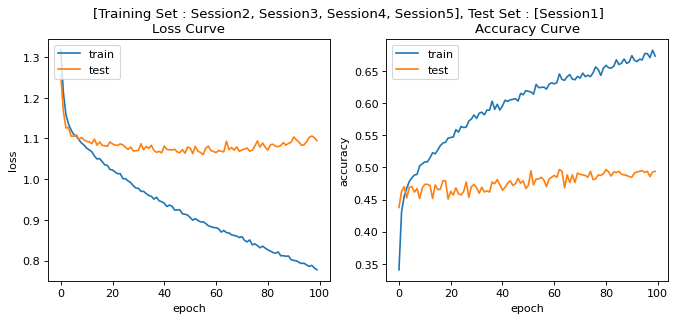

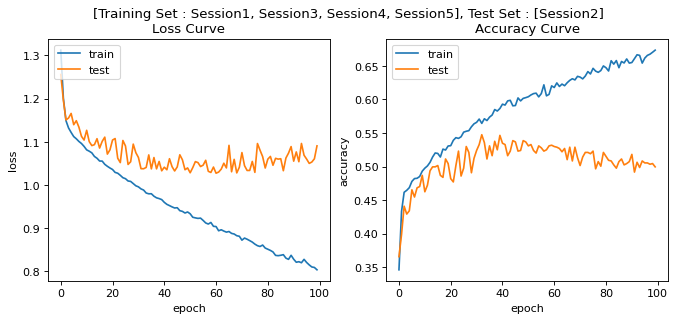

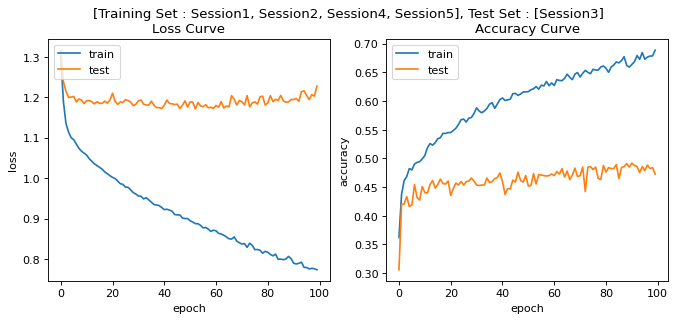

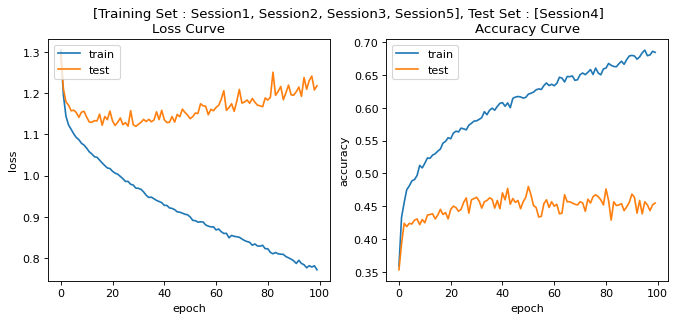

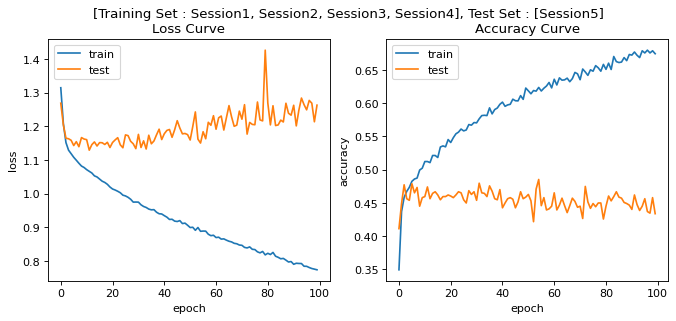

In [107]:
getLAACurves([history10, history11, history12, history13, history14]) 

# Refining Model 1(Early Stopping)

In [49]:
#
print("Training Model10 with Early Stopping for chunk : 1------------------")
model10Refined, refined10history = firstModel(0, 32, 56, train, test, 40)

#
print("Training Model11 with Early Stopping for chunk : 2------------------")
model11Refined, refined11history = firstModel(1, 32, 61, train, test, 40)

#
print("Training Model12 with Early Stopping for chunk : 3------------------")
model12Refined, refined12history = firstModel(2, 32, 53, train, test, 40)

#
print("Training Model13 with Early Stopping for chunk : 4------------------")
model13Refined, refined13history = firstModel(3, 32, 30, train, test, 40)

#
print("Training Model14 with Early Stopping for chunk : 5------------------")
model14Refined, refined14history = firstModel(4, 32, 12, train, test, 40)

Training Model10 with Early Stopping for chunk : 1------------------
Epoch 1/56
139/139 [==============================] - 3s 17ms/step - loss: 1.3437 - accuracy: 0.3314 - val_loss: 1.2554 - val_accuracy: 0.4378
Epoch 2/56
139/139 [==============================] - 1s 6ms/step - loss: 1.2353 - accuracy: 0.4072 - val_loss: 1.1668 - val_accuracy: 0.4627
Epoch 3/56
139/139 [==============================] - 1s 6ms/step - loss: 1.1630 - accuracy: 0.4619 - val_loss: 1.1257 - val_accuracy: 0.4700
Epoch 4/56
139/139 [==============================] - 1s 6ms/step - loss: 1.1462 - accuracy: 0.4571 - val_loss: 1.1274 - val_accuracy: 0.4525
Epoch 5/56
139/139 [==============================] - 1s 6ms/step - loss: 1.1216 - accuracy: 0.4669 - val_loss: 1.1058 - val_accuracy: 0.4691
Epoch 6/56
139/139 [==============================] - 1s 6ms/step - loss: 1.1089 - accuracy: 0.4897 - val_loss: 1.1054 - val_accuracy: 0.4700
Epoch 7/56
139/139 [==============================] - 1s 6ms/step - loss: 1.11

141/141 [==============================] - 2s 8ms/step - loss: 1.3416 - accuracy: 0.3146 - val_loss: 1.2555 - val_accuracy: 0.3656
Epoch 2/61
141/141 [==============================] - 1s 6ms/step - loss: 1.2174 - accuracy: 0.4191 - val_loss: 1.1961 - val_accuracy: 0.3988
Epoch 3/61
141/141 [==============================] - 1s 6ms/step - loss: 1.1563 - accuracy: 0.4555 - val_loss: 1.1504 - val_accuracy: 0.4409
Epoch 4/61
141/141 [==============================] - 1s 6ms/step - loss: 1.1238 - accuracy: 0.4658 - val_loss: 1.1549 - val_accuracy: 0.4291
Epoch 5/61
141/141 [==============================] - 1s 6ms/step - loss: 1.1293 - accuracy: 0.4593 - val_loss: 1.1655 - val_accuracy: 0.4340
Epoch 6/61
141/141 [==============================] - 1s 6ms/step - loss: 1.1018 - accuracy: 0.4813 - val_loss: 1.1394 - val_accuracy: 0.4653
Epoch 7/61
141/141 [==============================] - 1s 6ms/step - loss: 1.1079 - accuracy: 0.4755 - val_loss: 1.1487 - val_accuracy: 0.4545
Epoch 8/61
141/14

141/141 [==============================] - 1s 6ms/step - loss: 0.9097 - accuracy: 0.5943 - val_loss: 1.0316 - val_accuracy: 0.5249
Epoch 59/61
141/141 [==============================] - 1s 6ms/step - loss: 0.8887 - accuracy: 0.6232 - val_loss: 1.0290 - val_accuracy: 0.5308
Epoch 60/61
141/141 [==============================] - 1s 6ms/step - loss: 0.9121 - accuracy: 0.6206 - val_loss: 1.0414 - val_accuracy: 0.5318
Epoch 61/61
141/141 [==============================] - 1s 6ms/step - loss: 0.9032 - accuracy: 0.6231 - val_loss: 1.0272 - val_accuracy: 0.5298
Training Model12 with Early Stopping for chunk : 3------------------
Epoch 1/53
137/137 [==============================] - 2s 8ms/step - loss: 1.3336 - accuracy: 0.3453 - val_loss: 1.3163 - val_accuracy: 0.3058
Epoch 2/53
137/137 [==============================] - 1s 6ms/step - loss: 1.2131 - accuracy: 0.4181 - val_loss: 1.2389 - val_accuracy: 0.4196
Epoch 3/53
137/137 [==============================] - 1s 6ms/step - loss: 1.1291 - accu

Training Model13 with Early Stopping for chunk : 4------------------
Epoch 1/30
141/141 [==============================] - 2s 8ms/step - loss: 1.3367 - accuracy: 0.3397 - val_loss: 1.2990 - val_accuracy: 0.3531
Epoch 2/30
141/141 [==============================] - 1s 6ms/step - loss: 1.2178 - accuracy: 0.4250 - val_loss: 1.2112 - val_accuracy: 0.3928
Epoch 3/30
141/141 [==============================] - 1s 6ms/step - loss: 1.1546 - accuracy: 0.4535 - val_loss: 1.1792 - val_accuracy: 0.4239
Epoch 4/30
141/141 [==============================] - 1s 6ms/step - loss: 1.1338 - accuracy: 0.4720 - val_loss: 1.1710 - val_accuracy: 0.4190
Epoch 5/30
141/141 [==============================] - 1s 6ms/step - loss: 1.1207 - accuracy: 0.4749 - val_loss: 1.1573 - val_accuracy: 0.4239
Epoch 6/30
141/141 [==============================] - 1s 6ms/step - loss: 1.1123 - accuracy: 0.4908 - val_loss: 1.1589 - val_accuracy: 0.4229
Epoch 7/30
141/141 [==============================] - 1s 6ms/step - loss: 1.091

In [60]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


# Loss And Accuracy Curve for Refined Model 1

In [61]:
tf.keras.utils.plot_model(model10Refined)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


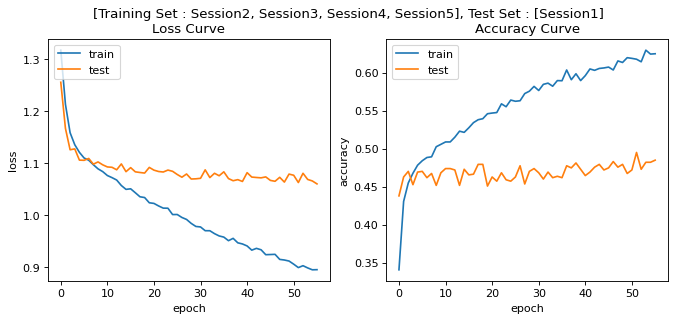

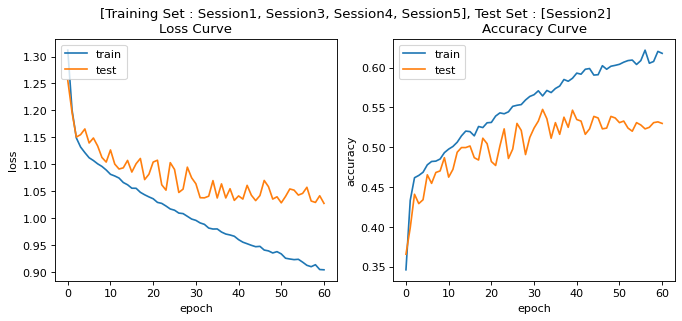

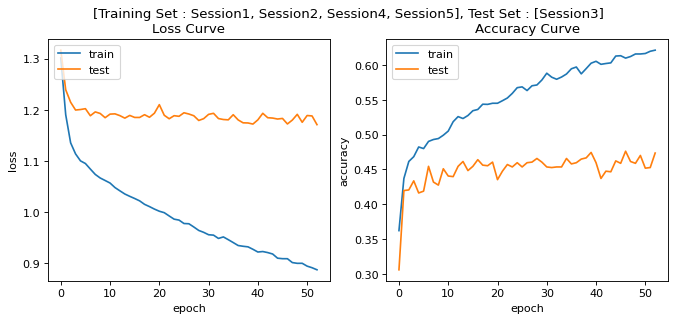

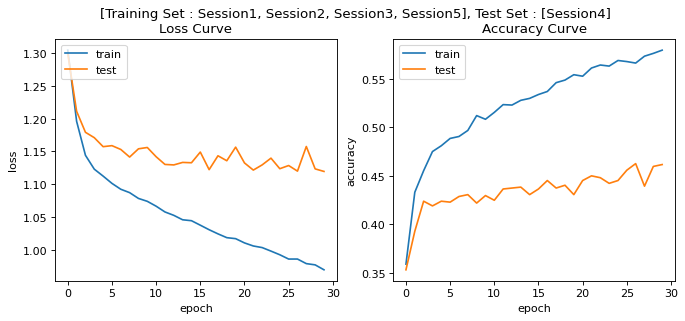

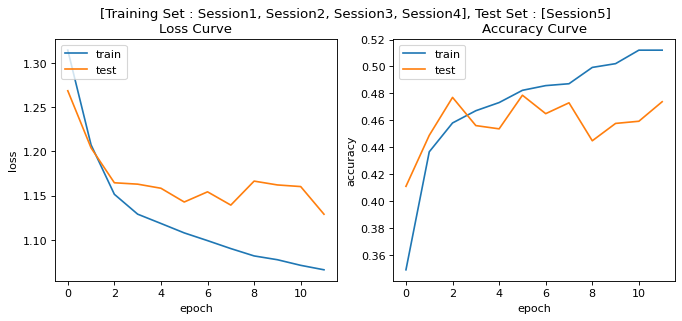

In [109]:
getLAACurves([refined10history, refined11history, refined12history, refined13history, refined14history]) 

# Refined Model 1 Scores across all iterations of 5 - fold

In [111]:
getScores(test, [model10Refined, model11Refined, model12Refined, model13Refined, model14Refined])

1. [Training Set : Session2, Session3, Session4, Session5], Test Set : [Session1]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.5393258426966292
Happy    |   0.38671874999999994
Sad      |   0.540045766590389
Neutral  |   0.48711340206185566


-------------------------------
Macro F1 Score :  0.4883009403372185


-------------------------------
Accuracy Score :  0.4847926267281106

-------------------------------------------------------------------------------------------------

2. [Training Set : Session1, Session3, Session4, Session5], Test Set : [Session2]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.5045045045045046
Happy    |   0.4992389649923896
Sad      |   0.6165803108808291
Neutral  |   0.5223880597014926


-------------------------------
Macro F1 Score :  0.535677960019804


-------------------------------
Accuracy 

# Experiment with OpenSmile Features

In [98]:
print("Training and testing on Chunk : 1-------------------------")
modelOSF10, historyOSF10 = firstModel(0, 32, 100, trainOSF, testOSF, 88)     #  55 epoch --> early stopping

print("Training and testing on Chunk : 2-------------------------")
modelOSF11, historyOSF11 = firstModel(1, 32, 100, trainOSF, testOSF, 88)    #  48 or 50 epoch --> early stopping

print("Training and testing on Chunk : 3-------------------------")
modelOSF12, historyOSF12 = firstModel(2, 32, 100, trainOSF, testOSF, 88)     # 59 epoch ----> early stopping

print("Training and testing on Chunk : 4-------------------------")
modelOSF13, historyOSF13 = firstModel(3, 32, 100, trainOSF, testOSF, 88)     # 69 epoch ----> early stopping

print("Training and testing on Chunk : 5-------------------------")
modelOSF14, historyOSF14 = firstModel(4, 32, 100, trainOSF, testOSF, 88)     # 55 epoch ----> early stopping

Training and testing on Chunk : 1-------------------------
Epoch 1/100
139/139 [==============================] - 3s 14ms/step - loss: 1.3429 - accuracy: 0.3500 - val_loss: 1.1992 - val_accuracy: 0.4618
Epoch 2/100
139/139 [==============================] - 1s 9ms/step - loss: 1.2203 - accuracy: 0.4384 - val_loss: 1.1478 - val_accuracy: 0.4636
Epoch 3/100
139/139 [==============================] - 1s 10ms/step - loss: 1.1504 - accuracy: 0.4940 - val_loss: 1.1055 - val_accuracy: 0.4876
Epoch 4/100
139/139 [==============================] - 1s 9ms/step - loss: 1.1052 - accuracy: 0.5032 - val_loss: 1.1195 - val_accuracy: 0.4452
Epoch 5/100
139/139 [==============================] - 1s 10ms/step - loss: 1.0934 - accuracy: 0.5142 - val_loss: 1.1574 - val_accuracy: 0.4553
Epoch 6/100
139/139 [==============================] - 1s 10ms/step - loss: 1.0660 - accuracy: 0.5377 - val_loss: 1.0936 - val_accuracy: 0.4876
Epoch 7/100
139/139 [==============================] - 1s 10ms/step - loss: 1.0

141/141 [==============================] - 1s 10ms/step - loss: 1.0133 - accuracy: 0.5546 - val_loss: 1.0135 - val_accuracy: 0.5865
Epoch 14/100
141/141 [==============================] - 1s 10ms/step - loss: 0.9953 - accuracy: 0.5751 - val_loss: 0.9886 - val_accuracy: 0.6168
Epoch 15/100
141/141 [==============================] - 1s 9ms/step - loss: 1.0058 - accuracy: 0.5588 - val_loss: 0.9857 - val_accuracy: 0.6070
Epoch 16/100
141/141 [==============================] - 1s 9ms/step - loss: 1.0102 - accuracy: 0.5507 - val_loss: 0.9776 - val_accuracy: 0.6139
Epoch 17/100
141/141 [==============================] - 1s 9ms/step - loss: 1.0103 - accuracy: 0.5445 - val_loss: 0.9745 - val_accuracy: 0.5992
Epoch 18/100
141/141 [==============================] - 1s 9ms/step - loss: 0.9879 - accuracy: 0.5743 - val_loss: 0.9844 - val_accuracy: 0.5699
Epoch 19/100
141/141 [==============================] - 1s 9ms/step - loss: 0.9933 - accuracy: 0.5766 - val_loss: 0.9734 - val_accuracy: 0.5914
Epo

Epoch 70/100
141/141 [==============================] - 1s 9ms/step - loss: 0.8016 - accuracy: 0.6710 - val_loss: 0.9260 - val_accuracy: 0.5973
Epoch 71/100
141/141 [==============================] - 1s 9ms/step - loss: 0.7978 - accuracy: 0.6722 - val_loss: 0.9406 - val_accuracy: 0.5865
Epoch 72/100
141/141 [==============================] - 1s 9ms/step - loss: 0.8160 - accuracy: 0.6638 - val_loss: 0.9298 - val_accuracy: 0.5924
Epoch 73/100
141/141 [==============================] - 1s 9ms/step - loss: 0.7946 - accuracy: 0.6636 - val_loss: 0.9220 - val_accuracy: 0.5982
Epoch 74/100
141/141 [==============================] - 1s 10ms/step - loss: 0.7973 - accuracy: 0.6780 - val_loss: 0.9389 - val_accuracy: 0.5836
Epoch 75/100
141/141 [==============================] - 1s 9ms/step - loss: 0.8165 - accuracy: 0.6751 - val_loss: 0.9394 - val_accuracy: 0.5816
Epoch 76/100
141/141 [==============================] - 1s 9ms/step - loss: 0.7955 - accuracy: 0.6789 - val_loss: 0.9290 - val_accuracy

Epoch 83/100
137/137 [==============================] - 1s 9ms/step - loss: 0.7475 - accuracy: 0.6932 - val_loss: 1.1818 - val_accuracy: 0.5161
Epoch 84/100
137/137 [==============================] - 1s 9ms/step - loss: 0.7344 - accuracy: 0.7013 - val_loss: 1.1678 - val_accuracy: 0.5161
Epoch 85/100
137/137 [==============================] - 1s 9ms/step - loss: 0.7127 - accuracy: 0.7128 - val_loss: 1.1798 - val_accuracy: 0.5056
Epoch 86/100
137/137 [==============================] - 1s 9ms/step - loss: 0.7419 - accuracy: 0.6909 - val_loss: 1.1738 - val_accuracy: 0.5169
Epoch 87/100
137/137 [==============================] - 1s 9ms/step - loss: 0.7154 - accuracy: 0.7154 - val_loss: 1.1628 - val_accuracy: 0.5169
Epoch 88/100
137/137 [==============================] - 1s 9ms/step - loss: 0.7373 - accuracy: 0.7028 - val_loss: 1.1658 - val_accuracy: 0.5126
Epoch 89/100
137/137 [==============================] - 1s 9ms/step - loss: 0.7414 - accuracy: 0.6997 - val_loss: 1.1879 - val_accuracy:

Epoch 96/100
141/141 [==============================] - 1s 9ms/step - loss: 0.7243 - accuracy: 0.6979 - val_loss: 1.0343 - val_accuracy: 0.5306
Epoch 97/100
141/141 [==============================] - 1s 9ms/step - loss: 0.7071 - accuracy: 0.7100 - val_loss: 1.0304 - val_accuracy: 0.5238
Epoch 98/100
141/141 [==============================] - 1s 9ms/step - loss: 0.7183 - accuracy: 0.7107 - val_loss: 1.0574 - val_accuracy: 0.5150
Epoch 99/100
141/141 [==============================] - 1s 9ms/step - loss: 0.7154 - accuracy: 0.7176 - val_loss: 1.0326 - val_accuracy: 0.5315
Epoch 100/100
141/141 [==============================] - 1s 9ms/step - loss: 0.7197 - accuracy: 0.7152 - val_loss: 1.0242 - val_accuracy: 0.5315
Training and testing on Chunk : 5-------------------------
Epoch 1/100
135/135 [==============================] - 2s 11ms/step - loss: 1.3330 - accuracy: 0.3553 - val_loss: 1.2647 - val_accuracy: 0.4416
Epoch 2/100
135/135 [==============================] - 1s 10ms/step - loss: 

# Loss and Accuracy curve of Model 1 with OpenSmile features

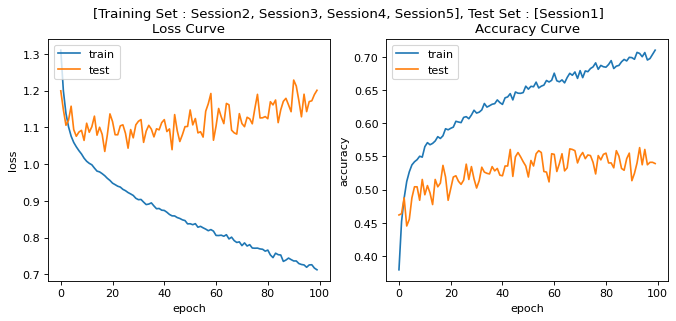

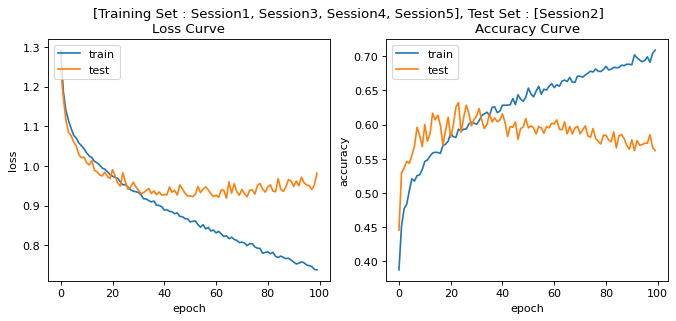

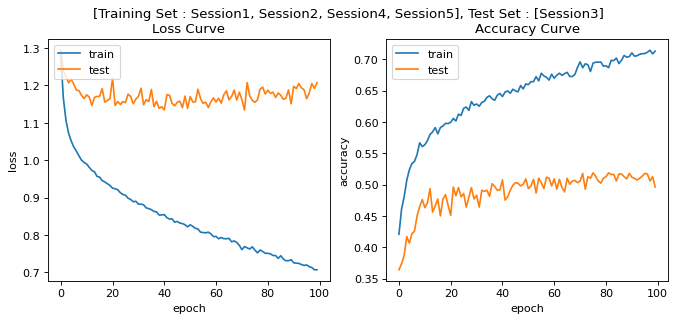

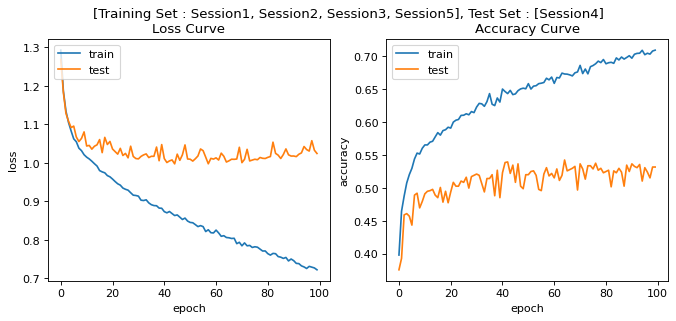

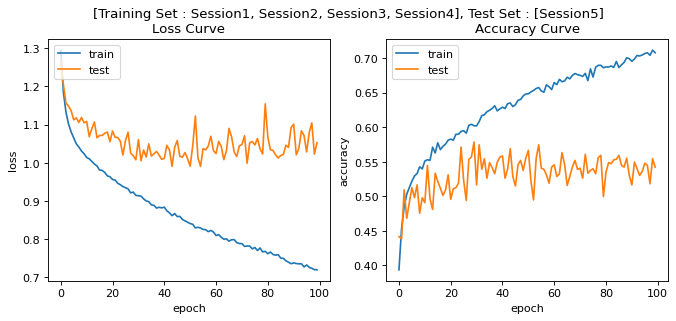

In [100]:
getLAACurves([historyOSF10, historyOSF11, historyOSF12, historyOSF13, historyOSF14]) 

In [112]:
print("Training and testing on Chunk : 1-------------------------")
modelOSRefinedF10, historyOSRefinedF10 = firstModel(0, 32, 18, trainOSF, testOSF, 88)     

print("Training and testing on Chunk : 2-------------------------")
modelOSRefinedF11, historyOSRefinedF11 = firstModel(1, 32, 65, trainOSF, testOSF, 88)    

print("Training and testing on Chunk : 3-------------------------")
modelOSRefinedF12, historyOSRefinedF12 = firstModel(2, 32, 72, trainOSF, testOSF, 88)     

print("Training and testing on Chunk : 4-------------------------")
modelOSRefinedF13, historyOSRefinedF13 = firstModel(3, 32, 45, trainOSF, testOSF, 88)     

print("Training and testing on Chunk : 5-------------------------")
modelOSRefinedF14, historyOSRefinedF14 = firstModel(4, 32, 55, trainOSF, testOSF, 88)     

Training and testing on Chunk : 1-------------------------
Epoch 1/18
139/139 [==============================] - 2s 11ms/step - loss: 1.3429 - accuracy: 0.3500 - val_loss: 1.1992 - val_accuracy: 0.4618
Epoch 2/18
139/139 [==============================] - 1s 9ms/step - loss: 1.2203 - accuracy: 0.4384 - val_loss: 1.1478 - val_accuracy: 0.4636
Epoch 3/18
139/139 [==============================] - 1s 9ms/step - loss: 1.1504 - accuracy: 0.4940 - val_loss: 1.1055 - val_accuracy: 0.4876
Epoch 4/18
139/139 [==============================] - 1s 9ms/step - loss: 1.1052 - accuracy: 0.5032 - val_loss: 1.1195 - val_accuracy: 0.4452
Epoch 5/18
139/139 [==============================] - 1s 9ms/step - loss: 1.0934 - accuracy: 0.5142 - val_loss: 1.1574 - val_accuracy: 0.4553
Epoch 6/18
139/139 [==============================] - 1s 9ms/step - loss: 1.0660 - accuracy: 0.5377 - val_loss: 1.0936 - val_accuracy: 0.4876
Epoch 7/18
139/139 [==============================] - 1s 9ms/step - loss: 1.0612 - accur

Epoch 31/72
137/137 [==============================] - 1s 10ms/step - loss: 0.8798 - accuracy: 0.6390 - val_loss: 1.1703 - val_accuracy: 0.4831
Epoch 32/72
137/137 [==============================] - 1s 10ms/step - loss: 0.8839 - accuracy: 0.6239 - val_loss: 1.1926 - val_accuracy: 0.4639
Epoch 33/72
137/137 [==============================] - 1s 10ms/step - loss: 0.8767 - accuracy: 0.6314 - val_loss: 1.1482 - val_accuracy: 0.4909
Epoch 34/72
137/137 [==============================] - 1s 9ms/step - loss: 0.8705 - accuracy: 0.6362 - val_loss: 1.1619 - val_accuracy: 0.4891
Epoch 35/72
137/137 [==============================] - 1s 9ms/step - loss: 0.8694 - accuracy: 0.6463 - val_loss: 1.1567 - val_accuracy: 0.4909
Epoch 36/72
137/137 [==============================] - 1s 9ms/step - loss: 0.8582 - accuracy: 0.6485 - val_loss: 1.1893 - val_accuracy: 0.4813
Epoch 37/72
137/137 [==============================] - 1s 9ms/step - loss: 0.8699 - accuracy: 0.6337 - val_loss: 1.1430 - val_accuracy: 0.5

Epoch 16/45
141/141 [==============================] - 1s 9ms/step - loss: 0.9804 - accuracy: 0.5880 - val_loss: 1.0603 - val_accuracy: 0.4850
Epoch 17/45
141/141 [==============================] - 1s 9ms/step - loss: 0.9806 - accuracy: 0.5804 - val_loss: 1.0263 - val_accuracy: 0.5005
Epoch 18/45
141/141 [==============================] - 1s 9ms/step - loss: 0.9653 - accuracy: 0.5914 - val_loss: 1.0660 - val_accuracy: 0.4782
Epoch 19/45
141/141 [==============================] - 1s 9ms/step - loss: 0.9639 - accuracy: 0.5878 - val_loss: 1.0475 - val_accuracy: 0.4947
Epoch 20/45
141/141 [==============================] - 1s 9ms/step - loss: 0.9523 - accuracy: 0.5962 - val_loss: 1.0554 - val_accuracy: 0.4772
Epoch 21/45
141/141 [==============================] - 1s 9ms/step - loss: 0.9458 - accuracy: 0.5978 - val_loss: 1.0357 - val_accuracy: 0.4937
Epoch 22/45
141/141 [==============================] - 1s 9ms/step - loss: 0.9572 - accuracy: 0.5950 - val_loss: 1.0291 - val_accuracy: 0.5082

Epoch 28/55
135/135 [==============================] - 1s 9ms/step - loss: 0.9306 - accuracy: 0.5972 - val_loss: 1.0252 - val_accuracy: 0.5536
Epoch 29/55
135/135 [==============================] - 1s 9ms/step - loss: 0.9288 - accuracy: 0.6014 - val_loss: 1.0186 - val_accuracy: 0.5568
Epoch 30/55
135/135 [==============================] - 1s 9ms/step - loss: 0.9197 - accuracy: 0.6038 - val_loss: 1.0078 - val_accuracy: 0.5786
Epoch 31/55
135/135 [==============================] - 1s 9ms/step - loss: 0.8894 - accuracy: 0.6152 - val_loss: 1.0607 - val_accuracy: 0.5165
Epoch 32/55
135/135 [==============================] - 1s 9ms/step - loss: 0.9130 - accuracy: 0.6035 - val_loss: 1.0052 - val_accuracy: 0.5745
Epoch 33/55
135/135 [==============================] - 1s 9ms/step - loss: 0.9086 - accuracy: 0.6199 - val_loss: 1.0334 - val_accuracy: 0.5391
Epoch 34/55
135/135 [==============================] - 1s 9ms/step - loss: 0.8806 - accuracy: 0.6320 - val_loss: 1.0151 - val_accuracy: 0.5544

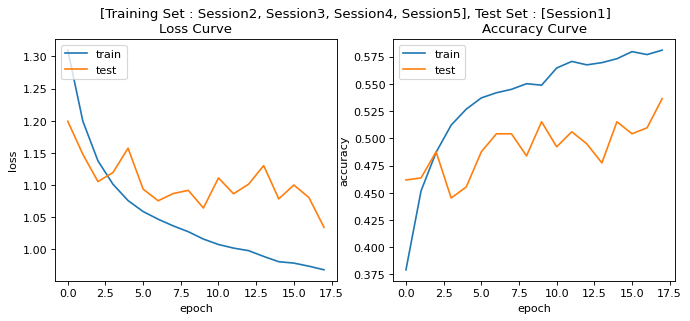

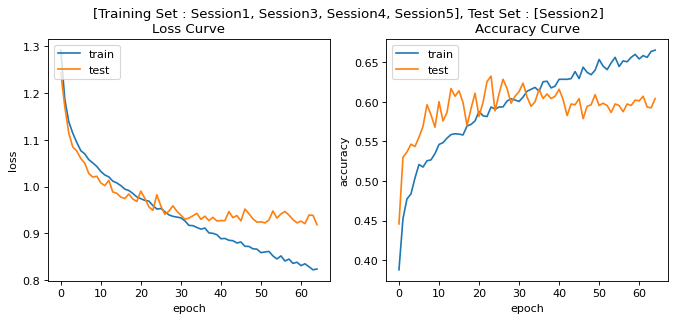

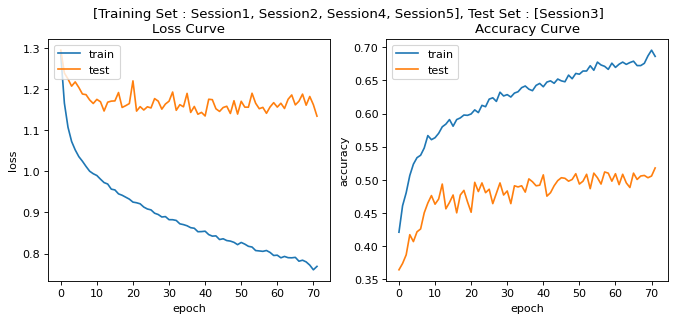

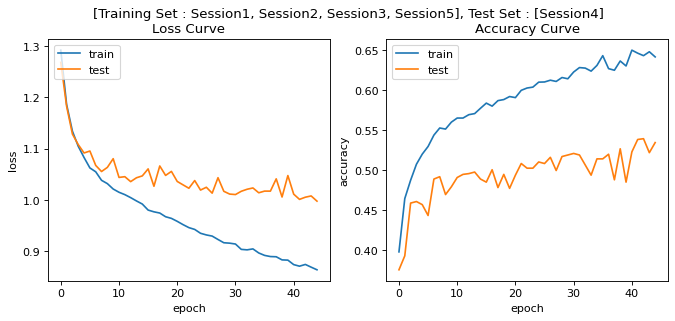

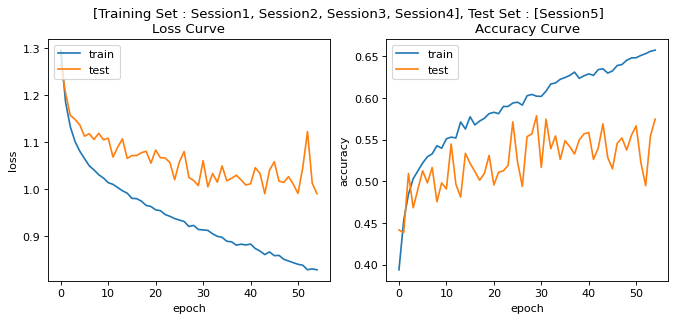

In [113]:
getLAACurves([historyOSRefinedF10, historyOSRefinedF11, historyOSRefinedF12, historyOSRefinedF13, historyOSRefinedF14]) 

In [114]:
getScores(testOSF, [modelOSRefinedF10, modelOSRefinedF11, modelOSRefinedF12, modelOSRefinedF13, modelOSRefinedF14])

1. [Training Set : Session2, Session3, Session4, Session5], Test Set : [Session1]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.6703296703296703
Happy    |   0.4337811900191939
Sad      |   0.5349397590361445
Neutral  |   0.5087209302325582


-------------------------------
Macro F1 Score :  0.5369428874043918


-------------------------------
Accuracy Score :  0.5364055299539171

-------------------------------------------------------------------------------------------------

2. [Training Set : Session1, Session3, Session4, Session5], Test Set : [Session2]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.5877862595419847
Happy    |   0.5601217656012177
Sad      |   0.6613756613756613
Neutral  |   0.6194926568758344


-------------------------------
Macro F1 Score :  0.6071940858486745


-------------------------------
Accuracy 

# Model - 2 (by reducing the complexity of Model 1)

In [117]:
def secondModel(chunk, batchSize, epoc, train, test, featureVectorSize):
    
    tf.random.set_seed(42)
    
    xTrainCNN = np.expand_dims(train[chunk]["XTrain"], axis=2)
    xTestCNN = np.expand_dims(test[chunk]["XTest"], axis=2)

    yTrainCNN = keras.utils.to_categorical(train[chunk]["yTrain"])
    yTestCNN = keras.utils.to_categorical(test[chunk]["yTest"])
    
    # model
    model = Sequential()

    model.add(Conv1D(16, 3,padding='same',
              input_shape=(featureVectorSize,1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(2)))

    model.add(Conv1D(32, 3,padding='same',))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(2)))

    model.add(Conv1D(64, 3,padding='same',))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(4))

    model.add(Activation('softmax'))

    opt = keras.optimizers.Adam(lr=0.00005, epsilon=1e-07)
    
    #model compilation
    model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])
    
    
    #model history
    history=model.fit(xTrainCNN, yTrainCNN, batch_size = batchSize, epochs = epoc, validation_data=(xTestCNN, yTestCNN))
              
    return model, history
    

In [118]:
print("\nTraining and testing on Chunk : 1-------------------------\n")
model20, history20 = secondModel(0, 32, 150, train, test, 40)     # 14 epoch --> early stopping

print("\nTraining and testing on Chunk : 2-------------------------\n")
model21, history21 = secondModel(1, 32, 150, train, test, 40)    # 75 epoch --> early stopping

print("\nTraining and testing on Chunk : 3-------------------------\n")
model22, history22 = secondModel(2, 32, 150, train, test, 40)     # 31 epoch ----> early stopping

print("\nTraining and testing on Chunk : 4-------------------------\n")
model23, history23 = secondModel(3, 32, 150, train, test, 40)     # 25 epoch ----> early stopping

print("\nTraining and testing on Chunk : 5-------------------------\n")
model24, history24 = secondModel(4, 32, 150, train, test, 40)     # 72 epoch ----> early stopping


Training and testing on Chunk : 1-------------------------

Epoch 1/150
139/139 [==============================] - 1s 4ms/step - loss: 1.3766 - accuracy: 0.2937 - val_loss: 1.3518 - val_accuracy: 0.2627
Epoch 2/150
139/139 [==============================] - 0s 3ms/step - loss: 1.3358 - accuracy: 0.3078 - val_loss: 1.3234 - val_accuracy: 0.2728
Epoch 3/150
139/139 [==============================] - 0s 3ms/step - loss: 1.3062 - accuracy: 0.3312 - val_loss: 1.2827 - val_accuracy: 0.3779
Epoch 4/150
139/139 [==============================] - 0s 3ms/step - loss: 1.2614 - accuracy: 0.3988 - val_loss: 1.2340 - val_accuracy: 0.4286
Epoch 5/150
139/139 [==============================] - 0s 3ms/step - loss: 1.2130 - accuracy: 0.4401 - val_loss: 1.1860 - val_accuracy: 0.4516
Epoch 6/150
139/139 [==============================] - 0s 3ms/step - loss: 1.1693 - accuracy: 0.4746 - val_loss: 1.1521 - val_accuracy: 0.4700
Epoch 7/150
139/139 [==============================] - 0s 3ms/step - loss: 1.1537

Epoch 114/150
139/139 [==============================] - 0s 3ms/step - loss: 0.9525 - accuracy: 0.5956 - val_loss: 1.0507 - val_accuracy: 0.5023
Epoch 115/150
139/139 [==============================] - 0s 3ms/step - loss: 0.9354 - accuracy: 0.6053 - val_loss: 1.0481 - val_accuracy: 0.5014
Epoch 116/150
139/139 [==============================] - 0s 3ms/step - loss: 0.9372 - accuracy: 0.6025 - val_loss: 1.0550 - val_accuracy: 0.4940
Epoch 117/150
139/139 [==============================] - 0s 3ms/step - loss: 0.9463 - accuracy: 0.5931 - val_loss: 1.0529 - val_accuracy: 0.4949
Epoch 118/150
139/139 [==============================] - 0s 3ms/step - loss: 0.9482 - accuracy: 0.5929 - val_loss: 1.0500 - val_accuracy: 0.5005
Epoch 119/150
139/139 [==============================] - 0s 3ms/step - loss: 0.9543 - accuracy: 0.5879 - val_loss: 1.0499 - val_accuracy: 0.5023
Epoch 120/150
139/139 [==============================] - 0s 3ms/step - loss: 0.9459 - accuracy: 0.6025 - val_loss: 1.0542 - val_ac

Epoch 77/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9867 - accuracy: 0.5622 - val_loss: 0.9962 - val_accuracy: 0.5709
Epoch 78/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9820 - accuracy: 0.5657 - val_loss: 1.0013 - val_accuracy: 0.5660
Epoch 79/150
141/141 [==============================] - 0s 3ms/step - loss: 1.0014 - accuracy: 0.5588 - val_loss: 1.0020 - val_accuracy: 0.5709
Epoch 80/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9882 - accuracy: 0.5832 - val_loss: 1.0077 - val_accuracy: 0.5582
Epoch 81/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9934 - accuracy: 0.5705 - val_loss: 1.0010 - val_accuracy: 0.5670
Epoch 82/150
141/141 [==============================] - 0s 3ms/step - loss: 1.0076 - accuracy: 0.5615 - val_loss: 1.0027 - val_accuracy: 0.5670
Epoch 83/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9794 - accuracy: 0.5812 - val_loss: 1.0026 - val_accuracy:

137/137 [==============================] - 0s 3ms/step - loss: 0.9986 - accuracy: 0.5581 - val_loss: 1.1544 - val_accuracy: 0.4883
Epoch 40/150
137/137 [==============================] - 0s 3ms/step - loss: 0.9949 - accuracy: 0.5641 - val_loss: 1.1557 - val_accuracy: 0.4891
Epoch 41/150
137/137 [==============================] - 0s 3ms/step - loss: 0.9885 - accuracy: 0.5638 - val_loss: 1.1606 - val_accuracy: 0.4874
Epoch 42/150
137/137 [==============================] - 0s 3ms/step - loss: 1.0007 - accuracy: 0.5641 - val_loss: 1.1606 - val_accuracy: 0.4857
Epoch 43/150
137/137 [==============================] - 0s 3ms/step - loss: 0.9782 - accuracy: 0.5727 - val_loss: 1.1607 - val_accuracy: 0.4848
Epoch 44/150
137/137 [==============================] - 0s 3ms/step - loss: 0.9874 - accuracy: 0.5526 - val_loss: 1.1558 - val_accuracy: 0.4935
Epoch 45/150
137/137 [==============================] - 0s 3ms/step - loss: 0.9967 - accuracy: 0.5570 - val_loss: 1.1555 - val_accuracy: 0.4839
Epoch

Epoch 96/150
137/137 [==============================] - 0s 3ms/step - loss: 0.9544 - accuracy: 0.5706 - val_loss: 1.1443 - val_accuracy: 0.5004
Epoch 97/150
137/137 [==============================] - 0s 3ms/step - loss: 0.9395 - accuracy: 0.5919 - val_loss: 1.1421 - val_accuracy: 0.4996
Epoch 98/150
137/137 [==============================] - 0s 3ms/step - loss: 0.9385 - accuracy: 0.5946 - val_loss: 1.1438 - val_accuracy: 0.4978
Epoch 99/150
137/137 [==============================] - 0s 3ms/step - loss: 0.9272 - accuracy: 0.5957 - val_loss: 1.1471 - val_accuracy: 0.4996
Epoch 100/150
137/137 [==============================] - 0s 3ms/step - loss: 0.9250 - accuracy: 0.6093 - val_loss: 1.1432 - val_accuracy: 0.5013
Epoch 101/150
137/137 [==============================] - 0s 3ms/step - loss: 0.9434 - accuracy: 0.6049 - val_loss: 1.1424 - val_accuracy: 0.4996
Epoch 102/150
137/137 [==============================] - 0s 3ms/step - loss: 0.9366 - accuracy: 0.5951 - val_loss: 1.1471 - val_accura

141/141 [==============================] - 0s 3ms/step - loss: 0.9766 - accuracy: 0.5775 - val_loss: 1.1031 - val_accuracy: 0.4627
Epoch 60/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9986 - accuracy: 0.5661 - val_loss: 1.0950 - val_accuracy: 0.4617
Epoch 61/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9723 - accuracy: 0.5814 - val_loss: 1.0918 - val_accuracy: 0.4646
Epoch 62/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9751 - accuracy: 0.5776 - val_loss: 1.1003 - val_accuracy: 0.4588
Epoch 63/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9634 - accuracy: 0.5821 - val_loss: 1.0858 - val_accuracy: 0.4656
Epoch 64/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9612 - accuracy: 0.5782 - val_loss: 1.0925 - val_accuracy: 0.4617
Epoch 65/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9542 - accuracy: 0.5842 - val_loss: 1.0912 - val_accuracy: 0.4704
Epoch

Epoch 116/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9332 - accuracy: 0.5947 - val_loss: 1.0932 - val_accuracy: 0.4568
Epoch 117/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9409 - accuracy: 0.5942 - val_loss: 1.0908 - val_accuracy: 0.4646
Epoch 118/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9295 - accuracy: 0.6226 - val_loss: 1.1009 - val_accuracy: 0.4665
Epoch 119/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9348 - accuracy: 0.5958 - val_loss: 1.1007 - val_accuracy: 0.4694
Epoch 120/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9460 - accuracy: 0.5994 - val_loss: 1.1038 - val_accuracy: 0.4753
Epoch 121/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9421 - accuracy: 0.6036 - val_loss: 1.1043 - val_accuracy: 0.4694
Epoch 122/150
141/141 [==============================] - 0s 3ms/step - loss: 0.9251 - accuracy: 0.5948 - val_loss: 1.0938 - val_ac

Epoch 79/150
135/135 [==============================] - 0s 3ms/step - loss: 0.9695 - accuracy: 0.5614 - val_loss: 1.0775 - val_accuracy: 0.5342
Epoch 80/150
135/135 [==============================] - 0s 3ms/step - loss: 0.9716 - accuracy: 0.5780 - val_loss: 1.0803 - val_accuracy: 0.5278
Epoch 81/150
135/135 [==============================] - 0s 3ms/step - loss: 0.9638 - accuracy: 0.5904 - val_loss: 1.0778 - val_accuracy: 0.5294
Epoch 82/150
135/135 [==============================] - 0s 3ms/step - loss: 0.9695 - accuracy: 0.5771 - val_loss: 1.0742 - val_accuracy: 0.5359
Epoch 83/150
135/135 [==============================] - 0s 3ms/step - loss: 0.9717 - accuracy: 0.5868 - val_loss: 1.0909 - val_accuracy: 0.5125
Epoch 84/150
135/135 [==============================] - 0s 3ms/step - loss: 0.9673 - accuracy: 0.5766 - val_loss: 1.0785 - val_accuracy: 0.5286
Epoch 85/150
135/135 [==============================] - 0s 3ms/step - loss: 0.9652 - accuracy: 0.5612 - val_loss: 1.0833 - val_accuracy:

# Loss And Accuracy Curve for Model 2

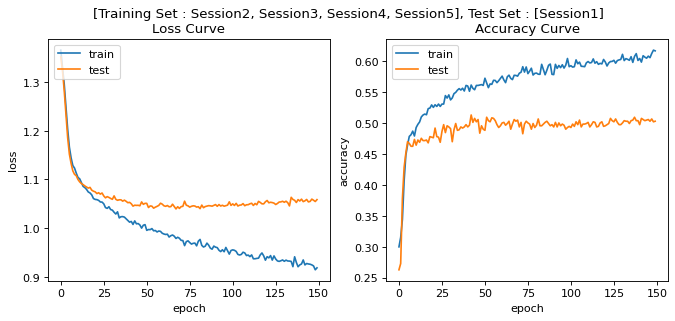

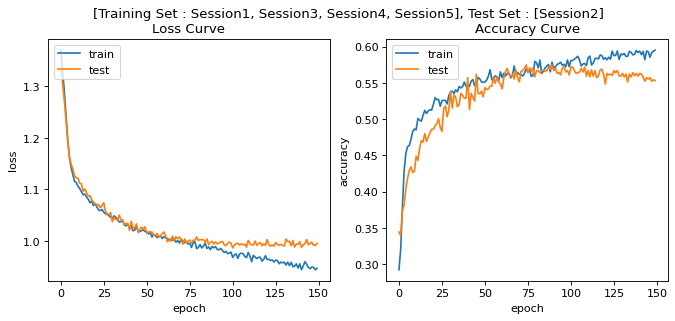

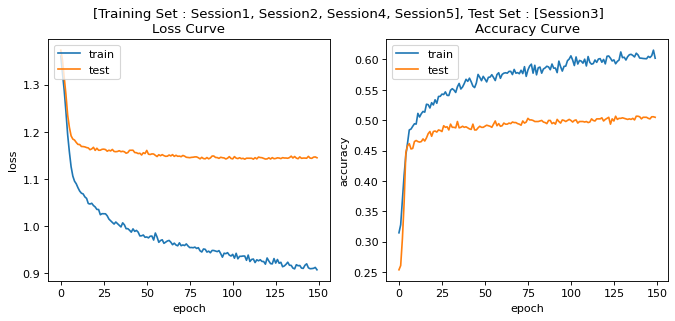

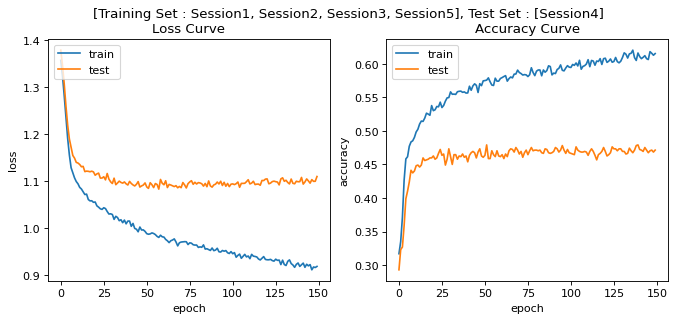

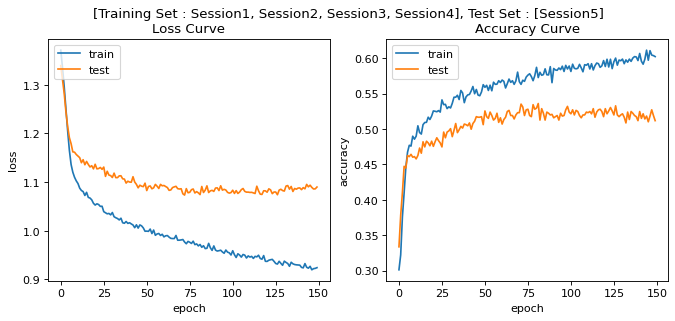

In [119]:
getLAACurves([history20, history21, history22, history23, history24]) 

# Refining Model2 

In [120]:
#
print("\nTraining Model20 with Early Stopping for chunk : 1------------------\n")
model20Refined, refined20history = secondModel(0, 32, 68, train, test, 40)

#
print("\nTraining Model21 with Early Stopping for chunk : 2------------------\n")
model21Refined, refined21history = secondModel(1, 32, 101, train, test, 40)

#
print("\nTraining Model22 with Early Stopping for chunk : 3------------------\n")
model22Refined, refined22history = secondModel(2, 32, 108, train, test, 40)

#
print("\nTraining Model23 with Early Stopping for chunk : 4------------------\n")
model23Refined, refined23history = secondModel(3, 32, 58, train, test, 40)

#
print("\nTraining Model24 with Early Stopping for chunk : 5------------------\n")
model24Refined, refined24history = secondModel(4, 32, 73, train, test, 40)


Training Model20 with Early Stopping for chunk : 1------------------

Epoch 1/68
139/139 [==============================] - 2s 9ms/step - loss: 1.3766 - accuracy: 0.2937 - val_loss: 1.3518 - val_accuracy: 0.2627
Epoch 2/68
139/139 [==============================] - 1s 5ms/step - loss: 1.3358 - accuracy: 0.3078 - val_loss: 1.3234 - val_accuracy: 0.2728
Epoch 3/68
139/139 [==============================] - 1s 5ms/step - loss: 1.3062 - accuracy: 0.3312 - val_loss: 1.2827 - val_accuracy: 0.3779
Epoch 4/68
139/139 [==============================] - 1s 5ms/step - loss: 1.2614 - accuracy: 0.3988 - val_loss: 1.2340 - val_accuracy: 0.4286
Epoch 5/68
139/139 [==============================] - 1s 5ms/step - loss: 1.2130 - accuracy: 0.4401 - val_loss: 1.1860 - val_accuracy: 0.4516
Epoch 6/68
139/139 [==============================] - 1s 5ms/step - loss: 1.1693 - accuracy: 0.4746 - val_loss: 1.1521 - val_accuracy: 0.4700
Epoch 7/68
139/139 [==============================] - 1s 5ms/step - loss: 1.1

Epoch 58/68
139/139 [==============================] - 1s 5ms/step - loss: 1.0166 - accuracy: 0.5547 - val_loss: 1.0467 - val_accuracy: 0.4977
Epoch 59/68
139/139 [==============================] - 1s 5ms/step - loss: 0.9918 - accuracy: 0.5719 - val_loss: 1.0513 - val_accuracy: 0.4931
Epoch 60/68
139/139 [==============================] - 1s 5ms/step - loss: 0.9963 - accuracy: 0.5711 - val_loss: 1.0493 - val_accuracy: 0.4959
Epoch 61/68
139/139 [==============================] - 1s 5ms/step - loss: 1.0099 - accuracy: 0.5601 - val_loss: 1.0459 - val_accuracy: 0.5005
Epoch 62/68
139/139 [==============================] - 1s 5ms/step - loss: 0.9626 - accuracy: 0.5827 - val_loss: 1.0449 - val_accuracy: 0.5014
Epoch 63/68
139/139 [==============================] - 1s 5ms/step - loss: 0.9958 - accuracy: 0.5642 - val_loss: 1.0465 - val_accuracy: 0.4968
Epoch 64/68
139/139 [==============================] - 1s 5ms/step - loss: 0.9902 - accuracy: 0.5701 - val_loss: 1.0439 - val_accuracy: 0.4995

137/137 [==============================] - 2s 7ms/step - loss: 1.3764 - accuracy: 0.3021 - val_loss: 1.3732 - val_accuracy: 0.2537
Epoch 2/108
137/137 [==============================] - 1s 5ms/step - loss: 1.3269 - accuracy: 0.3296 - val_loss: 1.3515 - val_accuracy: 0.2606
Epoch 3/108
137/137 [==============================] - 1s 5ms/step - loss: 1.2902 - accuracy: 0.3762 - val_loss: 1.3162 - val_accuracy: 0.3050
Epoch 4/108
137/137 [==============================] - 1s 5ms/step - loss: 1.2588 - accuracy: 0.3980 - val_loss: 1.2788 - val_accuracy: 0.3640
Epoch 5/108
137/137 [==============================] - 1s 5ms/step - loss: 1.2053 - accuracy: 0.4305 - val_loss: 1.2352 - val_accuracy: 0.4466
Epoch 6/108
137/137 [==============================] - 1s 5ms/step - loss: 1.1643 - accuracy: 0.4550 - val_loss: 1.2093 - val_accuracy: 0.4579
Epoch 7/108
137/137 [==============================] - 1s 5ms/step - loss: 1.1304 - accuracy: 0.4848 - val_loss: 1.1913 - val_accuracy: 0.4613
Epoch 8/108

137/137 [==============================] - 1s 5ms/step - loss: 0.9662 - accuracy: 0.5726 - val_loss: 1.1512 - val_accuracy: 0.4909
Epoch 59/108
137/137 [==============================] - 1s 5ms/step - loss: 0.9679 - accuracy: 0.5789 - val_loss: 1.1490 - val_accuracy: 0.4944
Epoch 60/108
137/137 [==============================] - 1s 5ms/step - loss: 0.9581 - accuracy: 0.5706 - val_loss: 1.1513 - val_accuracy: 0.4900
Epoch 61/108
137/137 [==============================] - 1s 5ms/step - loss: 0.9552 - accuracy: 0.5791 - val_loss: 1.1492 - val_accuracy: 0.4909
Epoch 62/108
137/137 [==============================] - 1s 5ms/step - loss: 0.9616 - accuracy: 0.5733 - val_loss: 1.1478 - val_accuracy: 0.4952
Epoch 63/108
137/137 [==============================] - 1s 5ms/step - loss: 0.9950 - accuracy: 0.5576 - val_loss: 1.1481 - val_accuracy: 0.4935
Epoch 64/108
137/137 [==============================] - 1s 5ms/step - loss: 0.9658 - accuracy: 0.5827 - val_loss: 1.1506 - val_accuracy: 0.4935
Epoch

Epoch 5/73
135/135 [==============================] - 1s 5ms/step - loss: 1.2102 - accuracy: 0.4565 - val_loss: 1.2142 - val_accuracy: 0.4448
Epoch 6/73
135/135 [==============================] - 1s 5ms/step - loss: 1.1804 - accuracy: 0.4504 - val_loss: 1.1912 - val_accuracy: 0.4625
Epoch 7/73
135/135 [==============================] - 1s 5ms/step - loss: 1.1441 - accuracy: 0.4593 - val_loss: 1.1788 - val_accuracy: 0.4609
Epoch 8/73
135/135 [==============================] - 1s 5ms/step - loss: 1.1162 - accuracy: 0.4708 - val_loss: 1.1620 - val_accuracy: 0.4641
Epoch 9/73
135/135 [==============================] - 1s 5ms/step - loss: 1.1091 - accuracy: 0.4822 - val_loss: 1.1614 - val_accuracy: 0.4601
Epoch 10/73
135/135 [==============================] - 1s 5ms/step - loss: 1.0962 - accuracy: 0.4929 - val_loss: 1.1567 - val_accuracy: 0.4609
Epoch 11/73
135/135 [==============================] - 1s 5ms/step - loss: 1.0895 - accuracy: 0.4930 - val_loss: 1.1535 - val_accuracy: 0.4577
Epoc

# Loss and Accuracy curve for Refined Model - 2

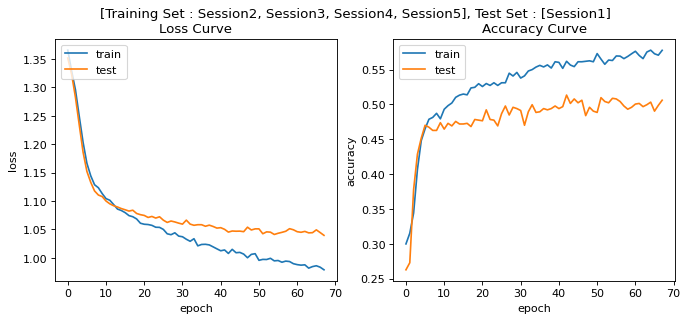

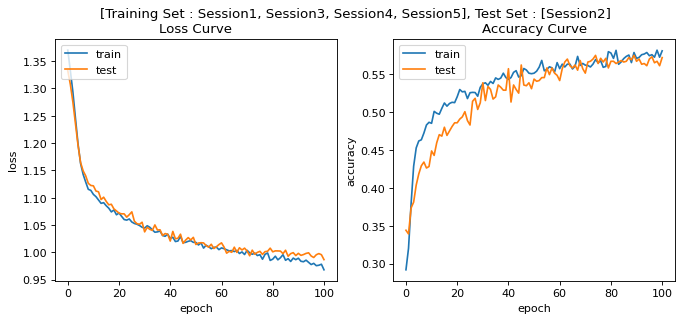

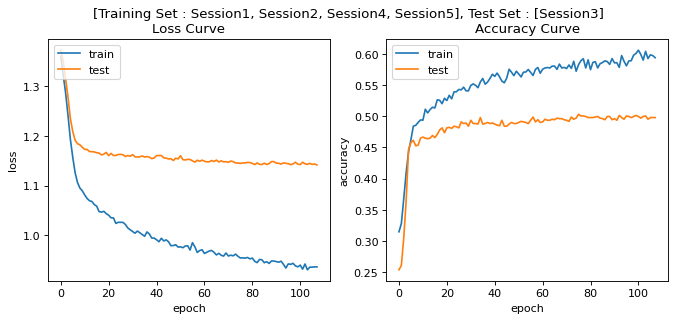

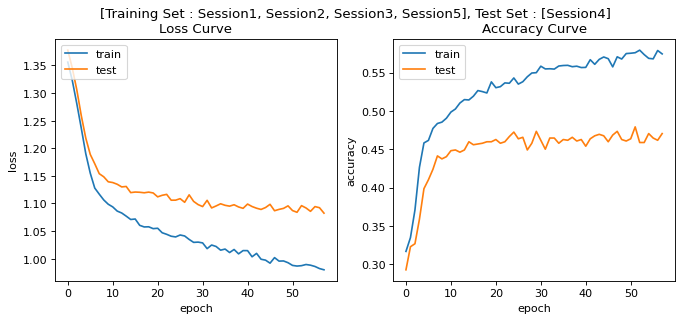

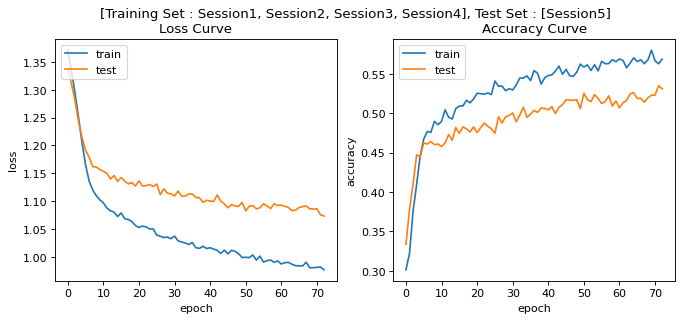

In [121]:
getLAACurves([refined20history, refined21history, refined22history, refined23history, refined24history]) 

# Refined Model 2 Scores across all iterations of 5 - fold

In [123]:
getScores(test, [model20Refined, model21Refined, model22Refined, model23Refined, model24Refined])

1. [Training Set : Session2, Session3, Session4, Session5], Test Set : [Session1]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.5726141078838174
Happy    |   0.36820083682008364
Sad      |   0.5330188679245282
Neutral  |   0.5343511450381679


-------------------------------
Macro F1 Score :  0.5020462394166494


-------------------------------
Accuracy Score :  0.5059907834101383

-------------------------------------------------------------------------------------------------

2. [Training Set : Session1, Session3, Session4, Session5], Test Set : [Session2]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.5387205387205387
Happy    |   0.5116279069767441
Sad      |   0.6436170212765957
Neutral  |   0.6016483516483516


-------------------------------
Macro F1 Score :  0.5739034546555575


-------------------------------
Accuracy

In [124]:
print("\nTraining and testing on Chunk : 1-------------------------\n")
modelOSF20, historyOSF20 = secondModel(0, 32, 150, trainOSF, testOSF, 88)     # 134 epoch --> early stopping

print("\nTraining and testing on Chunk : 2-------------------------\n")
modelOSF21, historyOSF21 = secondModel(1, 32, 150, trainOSF, testOSF, 88)    # 77 epoch --> early stopping

print("\nTraining and testing on Chunk : 3-------------------------\n")
modelOSF22, historyOSF22 = secondModel(2, 32, 150, trainOSF, testOSF, 88)     # 76 epoch ----> early stopping

print("\nTraining and testing on Chunk : 4-------------------------\n")
modelOSF23, historyOSF23 = secondModel(3, 32, 150, trainOSF, testOSF, 88)     # 61 epoch ----> early stopping

print("\nTraining and testing on Chunk : 5-------------------------\n")
modelOSF24, historyOSF24 = secondModel(4, 32, 150, trainOSF, testOSF, 88)     # 124 epoch ----> early stopping


Training and testing on Chunk : 1-------------------------

Epoch 1/150
139/139 [==============================] - 2s 10ms/step - loss: 1.3760 - accuracy: 0.3085 - val_loss: 1.3261 - val_accuracy: 0.3429
Epoch 2/150
139/139 [==============================] - 1s 6ms/step - loss: 1.3193 - accuracy: 0.3475 - val_loss: 1.2522 - val_accuracy: 0.4387
Epoch 3/150
139/139 [==============================] - 1s 6ms/step - loss: 1.2548 - accuracy: 0.4105 - val_loss: 1.1709 - val_accuracy: 0.5124
Epoch 4/150
139/139 [==============================] - 1s 6ms/step - loss: 1.1938 - accuracy: 0.4549 - val_loss: 1.1274 - val_accuracy: 0.4885
Epoch 5/150
139/139 [==============================] - 1s 6ms/step - loss: 1.1448 - accuracy: 0.4750 - val_loss: 1.1015 - val_accuracy: 0.4977
Epoch 6/150
139/139 [==============================] - 1s 6ms/step - loss: 1.1077 - accuracy: 0.5085 - val_loss: 1.0888 - val_accuracy: 0.4968
Epoch 7/150
139/139 [==============================] - 1s 6ms/step - loss: 1.085

Epoch 114/150
139/139 [==============================] - 1s 4ms/step - loss: 0.8822 - accuracy: 0.6190 - val_loss: 1.1319 - val_accuracy: 0.5419
Epoch 115/150
139/139 [==============================] - 1s 4ms/step - loss: 0.8763 - accuracy: 0.6380 - val_loss: 1.1252 - val_accuracy: 0.5429
Epoch 116/150
139/139 [==============================] - 1s 4ms/step - loss: 0.8490 - accuracy: 0.6418 - val_loss: 1.1108 - val_accuracy: 0.5493
Epoch 117/150
139/139 [==============================] - 1s 4ms/step - loss: 0.8693 - accuracy: 0.6257 - val_loss: 1.1391 - val_accuracy: 0.5419
Epoch 118/150
139/139 [==============================] - 1s 4ms/step - loss: 0.8709 - accuracy: 0.6383 - val_loss: 1.1215 - val_accuracy: 0.5512
Epoch 119/150
139/139 [==============================] - 1s 4ms/step - loss: 0.8732 - accuracy: 0.6270 - val_loss: 1.1372 - val_accuracy: 0.5456
Epoch 120/150
139/139 [==============================] - 1s 4ms/step - loss: 0.8996 - accuracy: 0.6212 - val_loss: 1.1445 - val_ac

Epoch 77/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9326 - accuracy: 0.5999 - val_loss: 0.9217 - val_accuracy: 0.5963
Epoch 78/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9050 - accuracy: 0.6097 - val_loss: 0.9279 - val_accuracy: 0.5914
Epoch 79/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9283 - accuracy: 0.5976 - val_loss: 0.9287 - val_accuracy: 0.5914
Epoch 80/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9176 - accuracy: 0.6082 - val_loss: 0.9350 - val_accuracy: 0.5836
Epoch 81/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9203 - accuracy: 0.5996 - val_loss: 0.9248 - val_accuracy: 0.5934
Epoch 82/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9159 - accuracy: 0.6122 - val_loss: 0.9301 - val_accuracy: 0.5865
Epoch 83/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9012 - accuracy: 0.6199 - val_loss: 0.9276 - val_accuracy:

137/137 [==============================] - 1s 4ms/step - loss: 0.9315 - accuracy: 0.6028 - val_loss: 1.1144 - val_accuracy: 0.5109
Epoch 40/150
137/137 [==============================] - 1s 4ms/step - loss: 0.9159 - accuracy: 0.5970 - val_loss: 1.1268 - val_accuracy: 0.5074
Epoch 41/150
137/137 [==============================] - 1s 4ms/step - loss: 0.9050 - accuracy: 0.6061 - val_loss: 1.1153 - val_accuracy: 0.5091
Epoch 42/150
137/137 [==============================] - 1s 4ms/step - loss: 0.9133 - accuracy: 0.6033 - val_loss: 1.1141 - val_accuracy: 0.5083
Epoch 43/150
137/137 [==============================] - 1s 4ms/step - loss: 0.9061 - accuracy: 0.6064 - val_loss: 1.1149 - val_accuracy: 0.5091
Epoch 44/150
137/137 [==============================] - 1s 4ms/step - loss: 0.9062 - accuracy: 0.6041 - val_loss: 1.1236 - val_accuracy: 0.5022
Epoch 45/150
137/137 [==============================] - 1s 4ms/step - loss: 0.9291 - accuracy: 0.6026 - val_loss: 1.1244 - val_accuracy: 0.5039
Epoch

Epoch 96/150
137/137 [==============================] - 1s 4ms/step - loss: 0.8932 - accuracy: 0.6160 - val_loss: 1.1254 - val_accuracy: 0.5178
Epoch 97/150
137/137 [==============================] - 1s 4ms/step - loss: 0.8451 - accuracy: 0.6445 - val_loss: 1.1242 - val_accuracy: 0.5117
Epoch 98/150
137/137 [==============================] - 1s 4ms/step - loss: 0.8531 - accuracy: 0.6314 - val_loss: 1.1237 - val_accuracy: 0.5195
Epoch 99/150
137/137 [==============================] - 1s 4ms/step - loss: 0.8521 - accuracy: 0.6413 - val_loss: 1.1424 - val_accuracy: 0.5126
Epoch 100/150
137/137 [==============================] - 1s 4ms/step - loss: 0.8585 - accuracy: 0.6352 - val_loss: 1.1260 - val_accuracy: 0.5169
Epoch 101/150
137/137 [==============================] - 1s 4ms/step - loss: 0.8693 - accuracy: 0.6241 - val_loss: 1.1201 - val_accuracy: 0.5195
Epoch 102/150
137/137 [==============================] - 1s 4ms/step - loss: 0.8604 - accuracy: 0.6259 - val_loss: 1.1141 - val_accura

Epoch 59/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9293 - accuracy: 0.6102 - val_loss: 0.9854 - val_accuracy: 0.5461
Epoch 60/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9346 - accuracy: 0.6006 - val_loss: 0.9792 - val_accuracy: 0.5509
Epoch 61/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9087 - accuracy: 0.6056 - val_loss: 0.9751 - val_accuracy: 0.5616
Epoch 62/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9047 - accuracy: 0.6129 - val_loss: 0.9839 - val_accuracy: 0.5509
Epoch 63/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9194 - accuracy: 0.5996 - val_loss: 0.9700 - val_accuracy: 0.5558
Epoch 64/150
141/141 [==============================] - ETA: 0s - loss: 0.9061 - accuracy: 0.60 - 1s 4ms/step - loss: 0.9065 - accuracy: 0.6084 - val_loss: 0.9810 - val_accuracy: 0.5461
Epoch 65/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9070 - accuracy:

135/135 [==============================] - 1s 4ms/step - loss: 1.0057 - accuracy: 0.5546 - val_loss: 1.0418 - val_accuracy: 0.5286
Epoch 22/150
135/135 [==============================] - 1s 4ms/step - loss: 0.9867 - accuracy: 0.5677 - val_loss: 1.0361 - val_accuracy: 0.5367
Epoch 23/150
135/135 [==============================] - 1s 4ms/step - loss: 0.9841 - accuracy: 0.5701 - val_loss: 1.0337 - val_accuracy: 0.5407
Epoch 24/150
135/135 [==============================] - 1s 4ms/step - loss: 0.9820 - accuracy: 0.5745 - val_loss: 1.0383 - val_accuracy: 0.5359
Epoch 25/150
135/135 [==============================] - 1s 4ms/step - loss: 0.9617 - accuracy: 0.5820 - val_loss: 1.0407 - val_accuracy: 0.5278
Epoch 26/150
135/135 [==============================] - 1s 4ms/step - loss: 0.9509 - accuracy: 0.5769 - val_loss: 1.0472 - val_accuracy: 0.5302
Epoch 27/150
135/135 [==============================] - 1s 4ms/step - loss: 0.9791 - accuracy: 0.5748 - val_loss: 1.0194 - val_accuracy: 0.5471
Epoch

Epoch 78/150
135/135 [==============================] - 1s 4ms/step - loss: 0.8920 - accuracy: 0.6136 - val_loss: 1.0181 - val_accuracy: 0.5399
Epoch 79/150
135/135 [==============================] - 1s 4ms/step - loss: 0.8943 - accuracy: 0.6119 - val_loss: 1.0136 - val_accuracy: 0.5399
Epoch 80/150
135/135 [==============================] - 1s 4ms/step - loss: 0.9108 - accuracy: 0.6152 - val_loss: 1.0109 - val_accuracy: 0.5415
Epoch 81/150
135/135 [==============================] - 1s 4ms/step - loss: 0.8971 - accuracy: 0.6095 - val_loss: 1.0059 - val_accuracy: 0.5552
Epoch 82/150
135/135 [==============================] - 1s 4ms/step - loss: 0.8839 - accuracy: 0.6343 - val_loss: 1.0067 - val_accuracy: 0.5536
Epoch 83/150
135/135 [==============================] - 1s 4ms/step - loss: 0.8854 - accuracy: 0.6221 - val_loss: 1.0201 - val_accuracy: 0.5423
Epoch 84/150
135/135 [==============================] - 1s 4ms/step - loss: 0.8941 - accuracy: 0.6181 - val_loss: 1.0078 - val_accuracy:

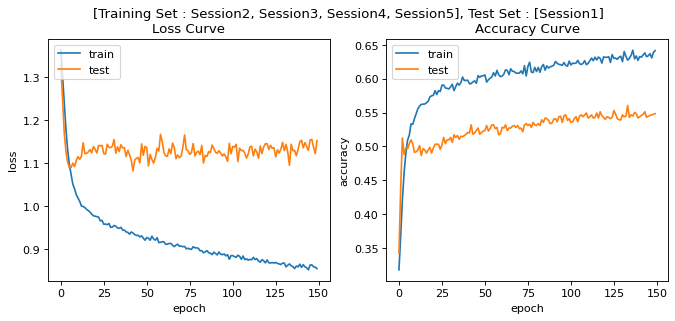

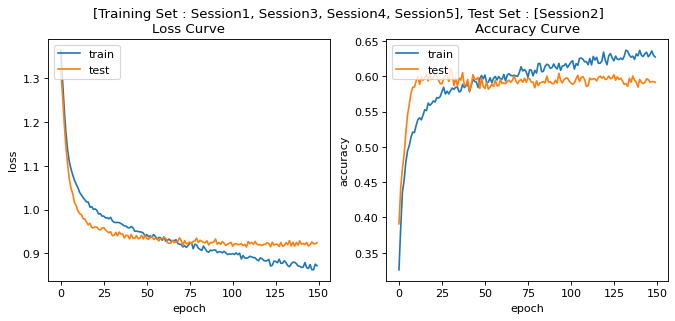

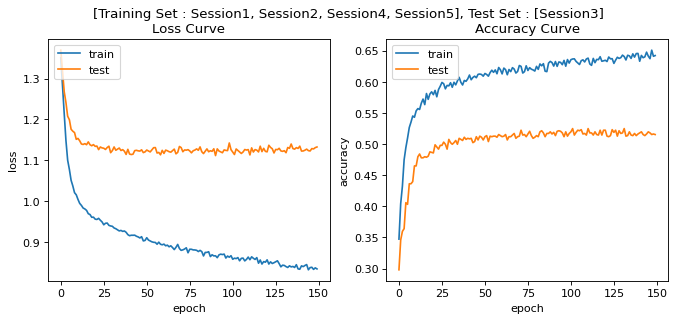

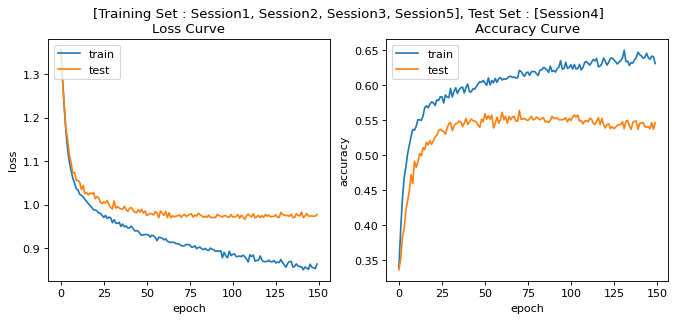

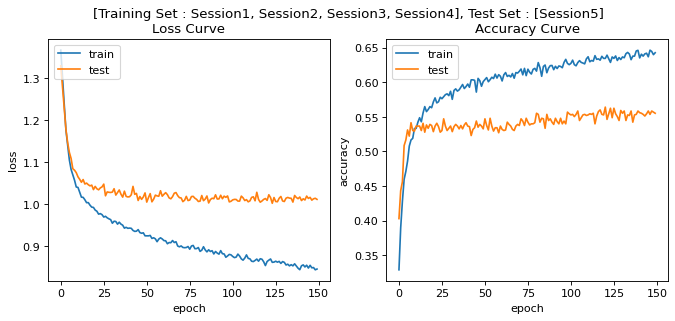

In [125]:
getLAACurves([historyOSF20, historyOSF21, historyOSF22, historyOSF23, historyOSF24]) 

In [124]:
print("Training and testing on Chunk : 1-------------------------")
modelOSRefinedF20, historyOSRefinedF20 = secondModel(0, 32, 43, trainOSF, testOSF, 88)    

print("Training and testing on Chunk : 2-------------------------")
modelOSRefinedF21, historyOSRefinedF21 = secondModel(1, 32, 109, trainOSF, testOSF, 88)    

print("Training and testing on Chunk : 3-------------------------")
modelOSRefinedF22, historyOSRefinedF22 = secondModel(2, 32, 91, trainOSF, testOSF, 88)    

print("Training and testing on Chunk : 4-------------------------")
modelOSRefinedF23, historyOSRefinedF23 = secondModel(3, 32, 108, trainOSF, testOSF, 88)     

print("Training and testing on Chunk : 5-------------------------")
modelOSRefinedF24, historyOSRefinedF24 = secondModel(4, 32, 87, trainOSF, testOSF, 88)     

Training and testing on Chunk : 1-------------------------
Epoch 1/43
139/139 [==============================] - 2s 10ms/step - loss: 1.3760 - accuracy: 0.3085 - val_loss: 1.3261 - val_accuracy: 0.3429
Epoch 2/43
139/139 [==============================] - 1s 7ms/step - loss: 1.3193 - accuracy: 0.3475 - val_loss: 1.2522 - val_accuracy: 0.4387
Epoch 3/43
139/139 [==============================] - 1s 7ms/step - loss: 1.2548 - accuracy: 0.4105 - val_loss: 1.1709 - val_accuracy: 0.5124
Epoch 4/43
139/139 [==============================] - 1s 7ms/step - loss: 1.1938 - accuracy: 0.4549 - val_loss: 1.1274 - val_accuracy: 0.4885
Epoch 5/43
139/139 [==============================] - 1s 7ms/step - loss: 1.1448 - accuracy: 0.4750 - val_loss: 1.1015 - val_accuracy: 0.4977
Epoch 6/43
139/139 [==============================] - 1s 7ms/step - loss: 1.1077 - accuracy: 0.5085 - val_loss: 1.0888 - val_accuracy: 0.4968
Epoch 7/43
139/139 [==============================] - 1s 7ms/step - loss: 1.0855 - accur

Epoch 71/109
141/141 [==============================] - 1s 7ms/step - loss: 0.9086 - accuracy: 0.6065 - val_loss: 0.9301 - val_accuracy: 0.5934
Epoch 72/109
141/141 [==============================] - 1s 7ms/step - loss: 0.9254 - accuracy: 0.6078 - val_loss: 0.9176 - val_accuracy: 0.5953
Epoch 73/109
141/141 [==============================] - 1s 7ms/step - loss: 0.9191 - accuracy: 0.5983 - val_loss: 0.9293 - val_accuracy: 0.5914
Epoch 74/109
141/141 [==============================] - 1s 7ms/step - loss: 0.8986 - accuracy: 0.6244 - val_loss: 0.9221 - val_accuracy: 0.5973
Epoch 75/109
141/141 [==============================] - 1s 7ms/step - loss: 0.9362 - accuracy: 0.5890 - val_loss: 0.9233 - val_accuracy: 0.5914
Epoch 76/109
141/141 [==============================] - 1s 7ms/step - loss: 0.9241 - accuracy: 0.5973 - val_loss: 0.9263 - val_accuracy: 0.5973
Epoch 77/109
141/141 [==============================] - 1s 7ms/step - loss: 0.9326 - accuracy: 0.5999 - val_loss: 0.9217 - val_accuracy:

137/137 [==============================] - 1s 7ms/step - loss: 0.8871 - accuracy: 0.6252 - val_loss: 1.1261 - val_accuracy: 0.5117
Epoch 76/91
137/137 [==============================] - 1s 7ms/step - loss: 0.8921 - accuracy: 0.6109 - val_loss: 1.1229 - val_accuracy: 0.5161
Epoch 77/91
137/137 [==============================] - 1s 7ms/step - loss: 0.8890 - accuracy: 0.6146 - val_loss: 1.1182 - val_accuracy: 0.5204
Epoch 78/91
137/137 [==============================] - 1s 7ms/step - loss: 0.8731 - accuracy: 0.6184 - val_loss: 1.1233 - val_accuracy: 0.5135
Epoch 79/91
137/137 [==============================] - 1s 7ms/step - loss: 0.8776 - accuracy: 0.6228 - val_loss: 1.1250 - val_accuracy: 0.5091
Epoch 80/91
137/137 [==============================] - 1s 7ms/step - loss: 0.8768 - accuracy: 0.6209 - val_loss: 1.1279 - val_accuracy: 0.5109
Epoch 81/91
137/137 [==============================] - 1s 7ms/step - loss: 0.8717 - accuracy: 0.6299 - val_loss: 1.1245 - val_accuracy: 0.5135
Epoch 82/91

Epoch 41/108
141/141 [==============================] - 1s 6ms/step - loss: 0.9549 - accuracy: 0.5932 - val_loss: 0.9913 - val_accuracy: 0.5441
Epoch 42/108
141/141 [==============================] - 1s 6ms/step - loss: 0.9359 - accuracy: 0.6026 - val_loss: 0.9928 - val_accuracy: 0.5480
Epoch 43/108
141/141 [==============================] - 1s 6ms/step - loss: 0.9584 - accuracy: 0.5905 - val_loss: 0.9865 - val_accuracy: 0.5519
Epoch 44/108
141/141 [==============================] - 1s 6ms/step - loss: 0.9561 - accuracy: 0.5914 - val_loss: 0.9827 - val_accuracy: 0.5500
Epoch 45/108
141/141 [==============================] - 1s 6ms/step - loss: 0.9516 - accuracy: 0.5896 - val_loss: 0.9810 - val_accuracy: 0.5490
Epoch 46/108
141/141 [==============================] - 1s 6ms/step - loss: 0.9364 - accuracy: 0.5968 - val_loss: 0.9881 - val_accuracy: 0.5480
Epoch 47/108
141/141 [==============================] - 1s 6ms/step - loss: 0.9266 - accuracy: 0.6091 - val_loss: 0.9824 - val_accuracy:

Epoch 98/108
141/141 [==============================] - 1s 7ms/step - loss: 0.8632 - accuracy: 0.6508 - val_loss: 0.9712 - val_accuracy: 0.5538
Epoch 99/108
141/141 [==============================] - 1s 7ms/step - loss: 0.8850 - accuracy: 0.6294 - val_loss: 0.9707 - val_accuracy: 0.5480
Epoch 100/108
141/141 [==============================] - 1s 7ms/step - loss: 0.8885 - accuracy: 0.6228 - val_loss: 0.9768 - val_accuracy: 0.5529
Epoch 101/108
141/141 [==============================] - 1s 7ms/step - loss: 0.8816 - accuracy: 0.6267 - val_loss: 0.9712 - val_accuracy: 0.5500
Epoch 102/108
141/141 [==============================] - 1s 7ms/step - loss: 0.8763 - accuracy: 0.6292 - val_loss: 0.9715 - val_accuracy: 0.5548
Epoch 103/108
141/141 [==============================] - 1s 7ms/step - loss: 0.8594 - accuracy: 0.6344 - val_loss: 0.9724 - val_accuracy: 0.5577
Epoch 104/108
141/141 [==============================] - 1s 7ms/step - loss: 0.8735 - accuracy: 0.6182 - val_loss: 0.9771 - val_accu

Epoch 47/87
135/135 [==============================] - 1s 7ms/step - loss: 0.9389 - accuracy: 0.5973 - val_loss: 1.0177 - val_accuracy: 0.5351
Epoch 48/87
135/135 [==============================] - 1s 7ms/step - loss: 0.9256 - accuracy: 0.6058 - val_loss: 1.0109 - val_accuracy: 0.5391
Epoch 49/87
135/135 [==============================] - 1s 7ms/step - loss: 0.9441 - accuracy: 0.5865 - val_loss: 1.0167 - val_accuracy: 0.5367
Epoch 50/87
135/135 [==============================] - 1s 7ms/step - loss: 0.9291 - accuracy: 0.5949 - val_loss: 1.0263 - val_accuracy: 0.5326
Epoch 51/87
135/135 [==============================] - 1s 7ms/step - loss: 0.9312 - accuracy: 0.6009 - val_loss: 1.0044 - val_accuracy: 0.5471
Epoch 52/87
135/135 [==============================] - 1s 7ms/step - loss: 0.9121 - accuracy: 0.6215 - val_loss: 1.0152 - val_accuracy: 0.5375
Epoch 53/87
135/135 [==============================] - 1s 7ms/step - loss: 0.9255 - accuracy: 0.6045 - val_loss: 1.0246 - val_accuracy: 0.5310

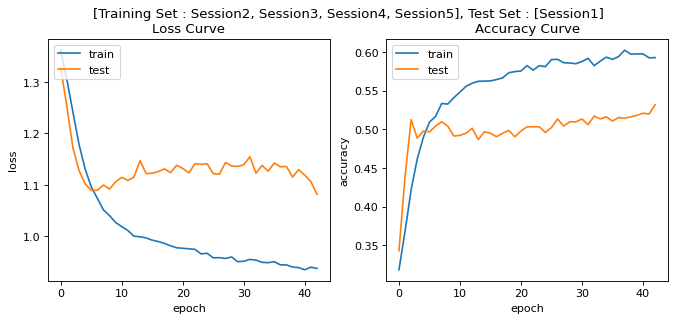

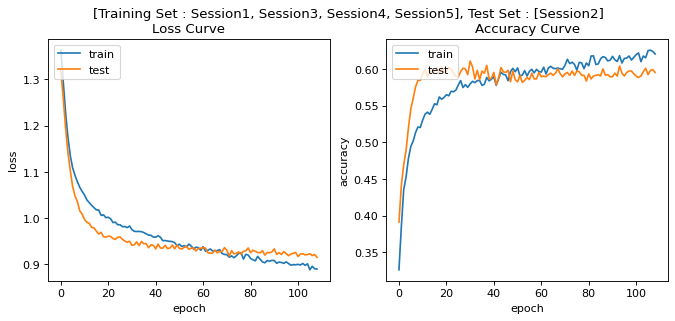

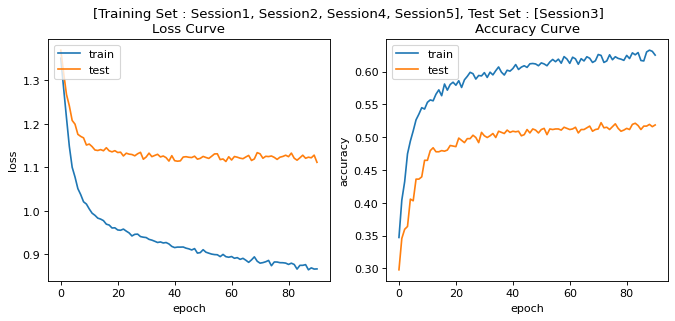

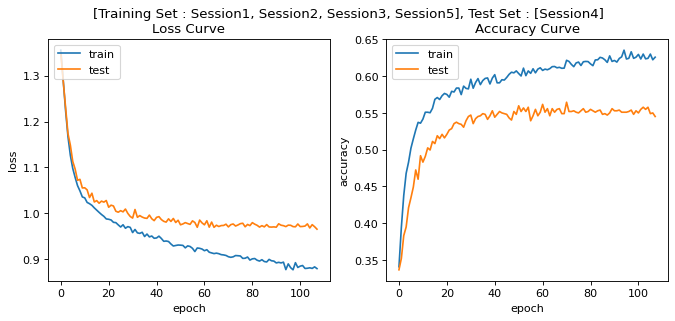

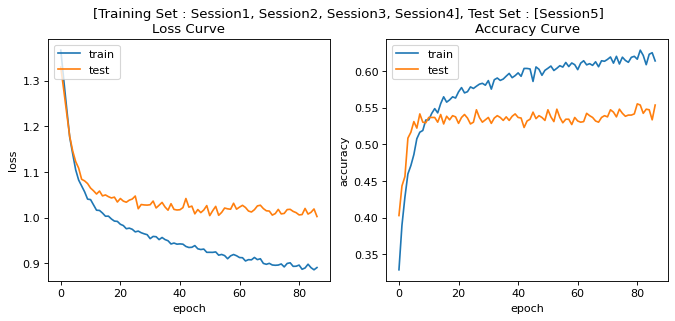

In [125]:
getLAACurves([historyOSRefinedF20, historyOSRefinedF21, historyOSRefinedF22, historyOSRefinedF23, historyOSRefinedF24]) 

In [126]:
getScores(testOSF, [modelOSRefinedF20, modelOSRefinedF21, modelOSRefinedF22, modelOSRefinedF23, modelOSRefinedF24])

1. [Training Set : Session2, Session3, Session4, Session5], Test Set : [Session1]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.6691729323308271
Happy    |   0.46453900709219853
Sad      |   0.5996055226824457
Neutral  |   0.40917107583774254


-------------------------------
Macro F1 Score :  0.5356221344858034


-------------------------------
Accuracy Score :  0.5317972350230414

-------------------------------------------------------------------------------------------------

2. [Training Set : Session1, Session3, Session4, Session5], Test Set : [Session2]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.6177606177606176
Happy    |   0.567251461988304
Sad      |   0.6481994459833794
Neutral  |   0.5876010781671159


-------------------------------
Macro F1 Score :  0.6052031509748543


-------------------------------
Accuracy

# Model - 3 

In [129]:
def thirdModel(chunk, batchSize, epoc, train, test, featureVectorSize):
    
    tf.random.set_seed(42)
    
    xTrainCNN = np.expand_dims(train[chunk]["XTrain"], axis=2)
    xTestCNN = np.expand_dims(test[chunk]["XTest"], axis=2)

    yTrainCNN = keras.utils.to_categorical(train[chunk]["yTrain"])
    yTestCNN = keras.utils.to_categorical(test[chunk]["yTest"])
    
    # model
    model = Sequential()

    model.add(Conv1D(8, 3,padding='same',
              input_shape=(featureVectorSize,1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(2)))

    model.add(Conv1D(16, 3,padding='same',))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(4))
    model.add(Activation('softmax'))

    opt = keras.optimizers.Adam(lr = 0.00005, epsilon = 1e-07)
    
    #model compilation
    model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])
    
    
    #model history
    history=model.fit(xTrainCNN, yTrainCNN, batch_size = batchSize, epochs = epoc, validation_data=(xTestCNN, yTestCNN))
              
    return model, history
    

In [349]:
print("\nTraining and testing on Chunk : 1-------------------------\n")
model30, history30 = thirdModel(0, 32, 200, train, test, 40)     # 43 epoch --> early stopping

print("\nTraining and testing on Chunk : 2-------------------------\n")
model31, history31 = thirdModel(1, 32, 300, train, test, 40)    # 250 epoch --> early stopping

print("\nTraining and testing on Chunk : 3-------------------------\n")
model32, history32 = thirdModel(2, 32, 200, train, test, 40)     # 73 epoch ----> early stopping

print("\nTraining and testing on Chunk : 4-------------------------\n")
model33, history33 = thirdModel(3, 32, 100, train, test, 40)     # 69 epoch ----> early stopping

print("\nTraining and testing on Chunk : 5-------------------------\n")
model34, history34 = thirdModel(4, 32, 200, train, test, 40)     # 135 epoch ----> early stopping


Training and testing on Chunk : 1-------------------------

Epoch 1/200
139/139 [==============================] - 1s 4ms/step - loss: 1.3952 - accuracy: 0.2950 - val_loss: 1.3561 - val_accuracy: 0.3078
Epoch 2/200
139/139 [==============================] - 0s 3ms/step - loss: 1.3554 - accuracy: 0.3151 - val_loss: 1.3348 - val_accuracy: 0.3226
Epoch 3/200
139/139 [==============================] - ETA: 0s - loss: 1.3278 - accuracy: 0.33 - 0s 2ms/step - loss: 1.3272 - accuracy: 0.3361 - val_loss: 1.3153 - val_accuracy: 0.3318
Epoch 4/200
139/139 [==============================] - 0s 3ms/step - loss: 1.3032 - accuracy: 0.3617 - val_loss: 1.2955 - val_accuracy: 0.3484
Epoch 5/200
139/139 [==============================] - 0s 3ms/step - loss: 1.2982 - accuracy: 0.3420 - val_loss: 1.2765 - val_accuracy: 0.3558
Epoch 6/200
139/139 [==============================] - 0s 3ms/step - loss: 1.2645 - accuracy: 0.3768 - val_loss: 1.2555 - val_accuracy: 0.3733
Epoch 7/200
139/139 [==================

139/139 [==============================] - ETA: 0s - loss: 1.0154 - accuracy: 0.56 - 0s 3ms/step - loss: 1.0141 - accuracy: 0.5627 - val_loss: 1.0792 - val_accuracy: 0.4857
Epoch 107/200
139/139 [==============================] - 0s 3ms/step - loss: 0.9955 - accuracy: 0.5687 - val_loss: 1.0804 - val_accuracy: 0.4802
Epoch 108/200
139/139 [==============================] - ETA: 0s - loss: 1.0285 - accuracy: 0.55 - 0s 3ms/step - loss: 1.0256 - accuracy: 0.5523 - val_loss: 1.0800 - val_accuracy: 0.4811
Epoch 109/200
139/139 [==============================] - 0s 3ms/step - loss: 0.9967 - accuracy: 0.5636 - val_loss: 1.0800 - val_accuracy: 0.4774
Epoch 110/200
139/139 [==============================] - 0s 3ms/step - loss: 1.0059 - accuracy: 0.5687 - val_loss: 1.0798 - val_accuracy: 0.4774
Epoch 111/200
139/139 [==============================] - 0s 3ms/step - loss: 1.0194 - accuracy: 0.5504 - val_loss: 1.0792 - val_accuracy: 0.4811
Epoch 112/200
139/139 [==============================] - 0s 

141/141 [==============================] - 0s 3ms/step - loss: 1.1586 - accuracy: 0.4564 - val_loss: 1.1271 - val_accuracy: 0.4643 - loss: 1.1606 - accuracy: 0.
Epoch 14/300
141/141 [==============================] - 0s 3ms/step - loss: 1.1424 - accuracy: 0.4752 - val_loss: 1.1172 - val_accuracy: 0.4712
Epoch 15/300
141/141 [==============================] - 0s 3ms/step - loss: 1.1339 - accuracy: 0.4821 - val_loss: 1.1096 - val_accuracy: 0.4761
Epoch 16/300
141/141 [==============================] - 0s 3ms/step - loss: 1.1308 - accuracy: 0.4784 - val_loss: 1.1028 - val_accuracy: 0.4800
Epoch 17/300
141/141 [==============================] - 0s 3ms/step - loss: 1.1276 - accuracy: 0.4730 - val_loss: 1.0998 - val_accuracy: 0.4712
Epoch 18/300
141/141 [==============================] - 0s 3ms/step - loss: 1.1126 - accuracy: 0.4899 - val_loss: 1.0942 - val_accuracy: 0.4731
Epoch 19/300
141/141 [==============================] - 0s 3ms/step - loss: 1.1130 - accuracy: 0.4773 - val_loss: 1.092

141/141 [==============================] - 0s 3ms/step - loss: 1.0321 - accuracy: 0.5442 - val_loss: 1.0144 - val_accuracy: 0.5494
Epoch 120/300
141/141 [==============================] - 0s 2ms/step - loss: 1.0335 - accuracy: 0.5317 - val_loss: 1.0146 - val_accuracy: 0.5474
Epoch 121/300
141/141 [==============================] - 0s 2ms/step - loss: 1.0277 - accuracy: 0.5525 - val_loss: 1.0163 - val_accuracy: 0.5445
Epoch 122/300
141/141 [==============================] - 0s 2ms/step - loss: 1.0206 - accuracy: 0.5452 - val_loss: 1.0124 - val_accuracy: 0.5474
Epoch 123/300
141/141 [==============================] - 0s 2ms/step - loss: 1.0474 - accuracy: 0.5350 - val_loss: 1.0129 - val_accuracy: 0.5474
Epoch 124/300
141/141 [==============================] - 0s 2ms/step - loss: 1.0171 - accuracy: 0.5511 - val_loss: 1.0125 - val_accuracy: 0.5543
Epoch 125/300
141/141 [==============================] - 0s 2ms/step - loss: 1.0036 - accuracy: 0.5566 - val_loss: 1.0109 - val_accuracy: 0.5552

Epoch 228/300
141/141 [==============================] - 0s 2ms/step - loss: 1.0007 - accuracy: 0.5607 - val_loss: 1.0002 - val_accuracy: 0.5679
Epoch 229/300
141/141 [==============================] - ETA: 0s - loss: 0.9814 - accuracy: 0.57 - 0s 2ms/step - loss: 0.9823 - accuracy: 0.5786 - val_loss: 0.9975 - val_accuracy: 0.5650
Epoch 230/300
141/141 [==============================] - 0s 2ms/step - loss: 1.0072 - accuracy: 0.5541 - val_loss: 0.9995 - val_accuracy: 0.5660
Epoch 231/300
141/141 [==============================] - 0s 2ms/step - loss: 1.0012 - accuracy: 0.5623 - val_loss: 1.0019 - val_accuracy: 0.5640
Epoch 232/300
141/141 [==============================] - 0s 3ms/step - loss: 1.0082 - accuracy: 0.5604 - val_loss: 0.9998 - val_accuracy: 0.5670
Epoch 233/300
141/141 [==============================] - 0s 2ms/step - loss: 1.0018 - accuracy: 0.5590 - val_loss: 0.9998 - val_accuracy: 0.5679
Epoch 234/300
141/141 [==============================] - 0s 2ms/step - loss: 0.9850 - ac

Epoch 282/300
141/141 [==============================] - 0s 2ms/step - loss: 0.9883 - accuracy: 0.5624 - val_loss: 0.9967 - val_accuracy: 0.5611
Epoch 283/300
141/141 [==============================] - 0s 2ms/step - loss: 0.9777 - accuracy: 0.5715 - val_loss: 0.9960 - val_accuracy: 0.5611
Epoch 284/300
141/141 [==============================] - 0s 2ms/step - loss: 0.9859 - accuracy: 0.5707 - val_loss: 0.9979 - val_accuracy: 0.5601
Epoch 285/300
141/141 [==============================] - 0s 3ms/step - loss: 0.9895 - accuracy: 0.5647 - val_loss: 0.9970 - val_accuracy: 0.5640
Epoch 286/300
141/141 [==============================] - 0s 2ms/step - loss: 0.9848 - accuracy: 0.5788 - val_loss: 0.9972 - val_accuracy: 0.5572
Epoch 287/300
141/141 [==============================] - 0s 3ms/step - loss: 0.9701 - accuracy: 0.5860 - val_loss: 0.9996 - val_accuracy: 0.5552
Epoch 288/300
141/141 [==============================] - ETA: 0s - loss: 0.9617 - accuracy: 0.57 - 0s 2ms/step - loss: 0.9635 - ac

Epoch 36/200
137/137 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.52 - 0s 3ms/step - loss: 1.0534 - accuracy: 0.5242 - val_loss: 1.1568 - val_accuracy: 0.4831
Epoch 37/200
137/137 [==============================] - 0s 2ms/step - loss: 1.0444 - accuracy: 0.5269 - val_loss: 1.1559 - val_accuracy: 0.4848
Epoch 38/200
137/137 [==============================] - 0s 2ms/step - loss: 1.0477 - accuracy: 0.5223 - val_loss: 1.1561 - val_accuracy: 0.4874
Epoch 39/200
137/137 [==============================] - 0s 2ms/step - loss: 1.0542 - accuracy: 0.5201 - val_loss: 1.1546 - val_accuracy: 0.4874
Epoch 40/200
137/137 [==============================] - ETA: 0s - loss: 1.0517 - accuracy: 0.50 - 0s 3ms/step - loss: 1.0511 - accuracy: 0.5093 - val_loss: 1.1548 - val_accuracy: 0.4883
Epoch 41/200
137/137 [==============================] - ETA: 0s - loss: 1.0396 - accuracy: 0.53 - 0s 2ms/step - loss: 1.0398 - accuracy: 0.5296 - val_loss: 1.1545 - val_accuracy: 0.4891
Epoch 42/2

Epoch 143/200
137/137 [==============================] - 0s 2ms/step - loss: 0.9794 - accuracy: 0.5803 - val_loss: 1.1454 - val_accuracy: 0.4909
Epoch 144/200
137/137 [==============================] - ETA: 0s - loss: 0.9704 - accuracy: 0.57 - 0s 3ms/step - loss: 0.9711 - accuracy: 0.5713 - val_loss: 1.1461 - val_accuracy: 0.4926
Epoch 145/200
137/137 [==============================] - 0s 2ms/step - loss: 0.9710 - accuracy: 0.5681 - val_loss: 1.1462 - val_accuracy: 0.4917
Epoch 146/200
137/137 [==============================] - 0s 2ms/step - loss: 0.9645 - accuracy: 0.5839 - val_loss: 1.1471 - val_accuracy: 0.4900
Epoch 147/200
137/137 [==============================] - 0s 2ms/step - loss: 0.9974 - accuracy: 0.5656 - val_loss: 1.1469 - val_accuracy: 0.4900
Epoch 148/200
137/137 [==============================] - 0s 3ms/step - loss: 0.9750 - accuracy: 0.5804 - val_loss: 1.1464 - val_accuracy: 0.4909
Epoch 149/200
137/137 [==============================] - 0s 3ms/step - loss: 0.9777 - ac

141/141 [==============================] - 0s 2ms/step - loss: 1.0278 - accuracy: 0.5416 - val_loss: 1.1402 - val_accuracy: 0.4413
Epoch 53/100
141/141 [==============================] - 0s 3ms/step - loss: 1.0429 - accuracy: 0.5292 - val_loss: 1.1413 - val_accuracy: 0.4423
Epoch 54/100
141/141 [==============================] - ETA: 0s - loss: 1.0254 - accuracy: 0.55 - 0s 3ms/step - loss: 1.0263 - accuracy: 0.5504 - val_loss: 1.1433 - val_accuracy: 0.4394
Epoch 55/100
141/141 [==============================] - 0s 2ms/step - loss: 1.0186 - accuracy: 0.5452 - val_loss: 1.1385 - val_accuracy: 0.4452
Epoch 56/100
141/141 [==============================] - 0s 3ms/step - loss: 1.0244 - accuracy: 0.5475 - val_loss: 1.1418 - val_accuracy: 0.4423
Epoch 57/100
141/141 [==============================] - 0s 2ms/step - loss: 1.0305 - accuracy: 0.5503 - val_loss: 1.1433 - val_accuracy: 0.4394
Epoch 58/100
141/141 [==============================] - 0s 2ms/step - loss: 1.0297 - accuracy: 0.5410 - val

Epoch 6/200
135/135 [==============================] - ETA: 0s - loss: 1.2700 - accuracy: 0.37 - 0s 3ms/step - loss: 1.2691 - accuracy: 0.3784 - val_loss: 1.2703 - val_accuracy: 0.3586
Epoch 7/200
135/135 [==============================] - 0s 3ms/step - loss: 1.2473 - accuracy: 0.3984 - val_loss: 1.2563 - val_accuracy: 0.3723
Epoch 8/200
135/135 [==============================] - 0s 3ms/step - loss: 1.2306 - accuracy: 0.4172 - val_loss: 1.2423 - val_accuracy: 0.3820
Epoch 9/200
135/135 [==============================] - ETA: 0s - loss: 1.2069 - accuracy: 0.43 - 0s 3ms/step - loss: 1.2062 - accuracy: 0.4387 - val_loss: 1.2293 - val_accuracy: 0.3932
Epoch 10/200
135/135 [==============================] - 0s 2ms/step - loss: 1.1811 - accuracy: 0.4629 - val_loss: 1.2196 - val_accuracy: 0.4053
Epoch 11/200
135/135 [==============================] - 0s 3ms/step - loss: 1.1710 - accuracy: 0.4582 - val_loss: 1.2109 - val_accuracy: 0.4166
Epoch 12/200
135/135 [==============================] - 

135/135 [==============================] - 0s 3ms/step - loss: 1.0424 - accuracy: 0.5382 - val_loss: 1.1493 - val_accuracy: 0.4585
Epoch 61/200
135/135 [==============================] - 0s 3ms/step - loss: 1.0422 - accuracy: 0.5318 - val_loss: 1.1488 - val_accuracy: 0.4601
Epoch 62/200
135/135 [==============================] - 0s 3ms/step - loss: 1.0445 - accuracy: 0.5277 - val_loss: 1.1493 - val_accuracy: 0.4641
Epoch 63/200
135/135 [==============================] - 0s 2ms/step - loss: 1.0385 - accuracy: 0.5244 - val_loss: 1.1499 - val_accuracy: 0.4585
Epoch 64/200
135/135 [==============================] - ETA: 0s - loss: 1.0182 - accuracy: 0.54 - 0s 3ms/step - loss: 1.0188 - accuracy: 0.5412 - val_loss: 1.1473 - val_accuracy: 0.4585
Epoch 65/200
135/135 [==============================] - 0s 3ms/step - loss: 1.0279 - accuracy: 0.5364 - val_loss: 1.1484 - val_accuracy: 0.4593
Epoch 66/200
135/135 [==============================] - 0s 2ms/step - loss: 1.0221 - accuracy: 0.5399 - val

Epoch 113/200
135/135 [==============================] - 0s 3ms/step - loss: 1.0069 - accuracy: 0.5647 - val_loss: 1.1415 - val_accuracy: 0.4762
Epoch 114/200
135/135 [==============================] - 0s 3ms/step - loss: 0.9992 - accuracy: 0.5596 - val_loss: 1.1410 - val_accuracy: 0.4786
Epoch 115/200
135/135 [==============================] - ETA: 0s - loss: 1.0075 - accuracy: 0.5517 ETA: 0s - loss: 1.0020 - accura - 0s 3ms/step - loss: 1.0070 - accuracy: 0.5526 - val_loss: 1.1450 - val_accuracy: 0.4722
Epoch 116/200
135/135 [==============================] - 0s 3ms/step - loss: 1.0038 - accuracy: 0.5546 - val_loss: 1.1444 - val_accuracy: 0.4722
Epoch 117/200
135/135 [==============================] - 0s 3ms/step - loss: 0.9960 - accuracy: 0.5580 - val_loss: 1.1409 - val_accuracy: 0.4746
Epoch 118/200
135/135 [==============================] - 0s 3ms/step - loss: 1.0169 - accuracy: 0.5460 - val_loss: 1.1403 - val_accuracy: 0.4730
Epoch 119/200
135/135 [==============================]

# Loss And Accuracy Curve for Model 3

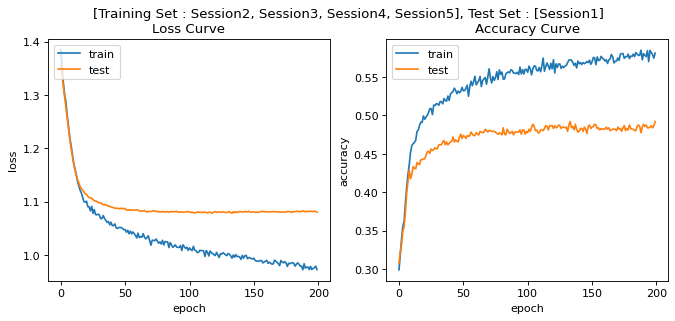

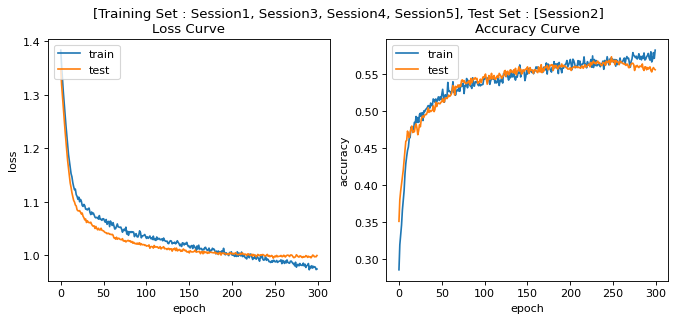

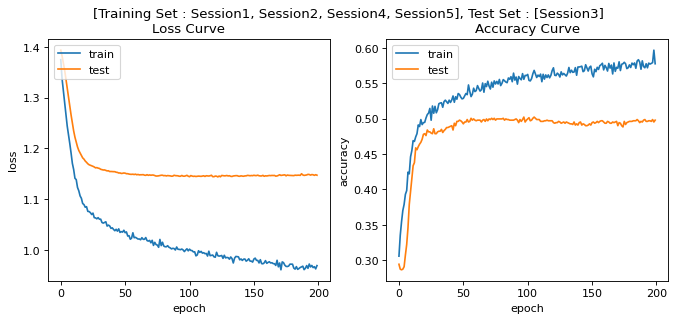

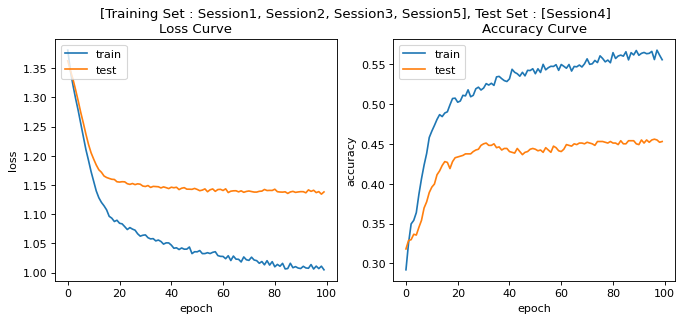

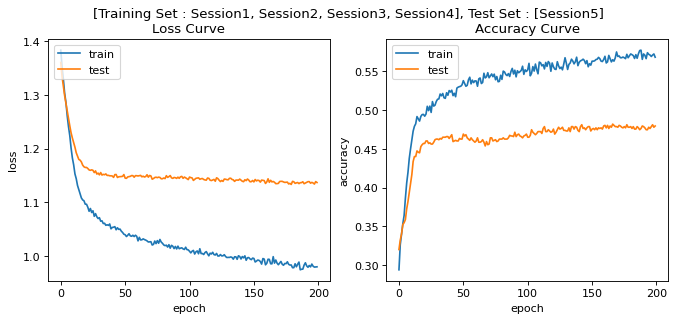

In [377]:
getLAACurves([history30, history31, history32, history33, history34]) 

# Refining Model3

In [130]:
#
print("\nTraining Model30 with Early Stopping for chunk : 1------------------\n")
model30Refined, refined30history = thirdModel(0, 32, 118, train, test, 40)

#
print("\nTraining Model31 with Early Stopping for chunk : 2------------------\n")
model31Refined, refined31history = thirdModel(1, 32, 293, train, test, 40)

#
print("\nTraining Model32 with Early Stopping for chunk : 3------------------\n")
model32Refined, refined32history = thirdModel(2, 32, 123, train, test, 40)

#
print("\nTraining Model33 with Early Stopping for chunk : 4------------------\n")
model33Refined, refined33history = thirdModel(3, 32, 99, train, test, 40)

#
print("\nTraining Model34 with Early Stopping for chunk : 5------------------\n")
model34Refined, refined34history = thirdModel(4, 32, 190, train, test, 40)


Training Model30 with Early Stopping for chunk : 1------------------

Epoch 1/118
139/139 [==============================] - 2s 7ms/step - loss: 1.3952 - accuracy: 0.2950 - val_loss: 1.3561 - val_accuracy: 0.3078
Epoch 2/118
139/139 [==============================] - 1s 5ms/step - loss: 1.3554 - accuracy: 0.3151 - val_loss: 1.3348 - val_accuracy: 0.3226
Epoch 3/118
139/139 [==============================] - 1s 4ms/step - loss: 1.3272 - accuracy: 0.3361 - val_loss: 1.3153 - val_accuracy: 0.3318
Epoch 4/118
139/139 [==============================] - 1s 4ms/step - loss: 1.3032 - accuracy: 0.3617 - val_loss: 1.2955 - val_accuracy: 0.3484
Epoch 5/118
139/139 [==============================] - 1s 4ms/step - loss: 1.2982 - accuracy: 0.3420 - val_loss: 1.2765 - val_accuracy: 0.3558
Epoch 6/118
139/139 [==============================] - 1s 4ms/step - loss: 1.2645 - accuracy: 0.3768 - val_loss: 1.2555 - val_accuracy: 0.3733
Epoch 7/118
139/139 [==============================] - 1s 4ms/step - lo

Epoch 114/118
139/139 [==============================] - 1s 4ms/step - loss: 1.0170 - accuracy: 0.5505 - val_loss: 1.0794 - val_accuracy: 0.4829
Epoch 115/118
139/139 [==============================] - 1s 4ms/step - loss: 1.0024 - accuracy: 0.5590 - val_loss: 1.0787 - val_accuracy: 0.4866
Epoch 116/118
139/139 [==============================] - 1s 4ms/step - loss: 0.9913 - accuracy: 0.5789 - val_loss: 1.0798 - val_accuracy: 0.4857
Epoch 117/118
139/139 [==============================] - 1s 4ms/step - loss: 1.0050 - accuracy: 0.5674 - val_loss: 1.0801 - val_accuracy: 0.4811
Epoch 118/118
139/139 [==============================] - 1s 4ms/step - loss: 1.0035 - accuracy: 0.5646 - val_loss: 1.0784 - val_accuracy: 0.4866

Training Model31 with Early Stopping for chunk : 2------------------

Epoch 1/293
141/141 [==============================] - 1s 5ms/step - loss: 1.3923 - accuracy: 0.2745 - val_loss: 1.3469 - val_accuracy: 0.3509
Epoch 2/293
141/141 [==============================] - 1s 4ms

Epoch 109/293
141/141 [==============================] - 1s 4ms/step - loss: 1.0396 - accuracy: 0.5513 - val_loss: 1.0137 - val_accuracy: 0.5513
Epoch 110/293
141/141 [==============================] - 1s 4ms/step - loss: 1.0253 - accuracy: 0.5446 - val_loss: 1.0185 - val_accuracy: 0.5435
Epoch 111/293
141/141 [==============================] - 1s 4ms/step - loss: 1.0332 - accuracy: 0.5475 - val_loss: 1.0154 - val_accuracy: 0.5455
Epoch 112/293
141/141 [==============================] - 1s 4ms/step - loss: 1.0335 - accuracy: 0.5429 - val_loss: 1.0163 - val_accuracy: 0.5484
Epoch 113/293
141/141 [==============================] - 1s 4ms/step - loss: 1.0238 - accuracy: 0.5538 - val_loss: 1.0154 - val_accuracy: 0.5435
Epoch 114/293
141/141 [==============================] - 1s 4ms/step - loss: 1.0378 - accuracy: 0.5299 - val_loss: 1.0160 - val_accuracy: 0.5435
Epoch 115/293
141/141 [==============================] - 1s 4ms/step - loss: 1.0350 - accuracy: 0.5385 - val_loss: 1.0134 - val_ac

141/141 [==============================] - 1s 4ms/step - loss: 0.9959 - accuracy: 0.5681 - val_loss: 1.0006 - val_accuracy: 0.5621
Epoch 222/293
141/141 [==============================] - 1s 4ms/step - loss: 1.0154 - accuracy: 0.5589 - val_loss: 1.0004 - val_accuracy: 0.5630
Epoch 223/293
141/141 [==============================] - 1s 4ms/step - loss: 1.0113 - accuracy: 0.5632 - val_loss: 1.0002 - val_accuracy: 0.5640
Epoch 224/293
141/141 [==============================] - 1s 4ms/step - loss: 1.0022 - accuracy: 0.5610 - val_loss: 1.0023 - val_accuracy: 0.5601
Epoch 225/293
141/141 [==============================] - 1s 4ms/step - loss: 0.9887 - accuracy: 0.5736 - val_loss: 0.9985 - val_accuracy: 0.5660
Epoch 226/293
141/141 [==============================] - 1s 4ms/step - loss: 0.9893 - accuracy: 0.5589 - val_loss: 1.0018 - val_accuracy: 0.5630
Epoch 227/293
141/141 [==============================] - 1s 4ms/step - loss: 0.9852 - accuracy: 0.5796 - val_loss: 1.0001 - val_accuracy: 0.5660

137/137 [==============================] - 1s 4ms/step - loss: 1.0511 - accuracy: 0.5093 - val_loss: 1.1548 - val_accuracy: 0.4883
Epoch 41/123
137/137 [==============================] - 1s 4ms/step - loss: 1.0398 - accuracy: 0.5296 - val_loss: 1.1545 - val_accuracy: 0.4891
Epoch 42/123
137/137 [==============================] - 1s 4ms/step - loss: 1.0496 - accuracy: 0.5169 - val_loss: 1.1544 - val_accuracy: 0.4900
Epoch 43/123
137/137 [==============================] - 1s 4ms/step - loss: 1.0244 - accuracy: 0.5529 - val_loss: 1.1544 - val_accuracy: 0.4839
Epoch 44/123
137/137 [==============================] - 1s 4ms/step - loss: 1.0367 - accuracy: 0.5223 - val_loss: 1.1533 - val_accuracy: 0.4935
Epoch 45/123
137/137 [==============================] - 1s 4ms/step - loss: 1.0456 - accuracy: 0.5236 - val_loss: 1.1529 - val_accuracy: 0.4900
Epoch 46/123
137/137 [==============================] - 1s 4ms/step - loss: 1.0376 - accuracy: 0.5372 - val_loss: 1.1518 - val_accuracy: 0.4961
Epoch

Epoch 97/123
137/137 [==============================] - 1s 4ms/step - loss: 0.9875 - accuracy: 0.5679 - val_loss: 1.1455 - val_accuracy: 0.4987
Epoch 98/123
137/137 [==============================] - 1s 4ms/step - loss: 0.9970 - accuracy: 0.5618 - val_loss: 1.1462 - val_accuracy: 0.5022
Epoch 99/123
137/137 [==============================] - 1s 4ms/step - loss: 0.9919 - accuracy: 0.5687 - val_loss: 1.1473 - val_accuracy: 0.4952
Epoch 100/123
137/137 [==============================] - 1s 4ms/step - loss: 0.9926 - accuracy: 0.5640 - val_loss: 1.1455 - val_accuracy: 0.4978
Epoch 101/123
137/137 [==============================] - 1s 4ms/step - loss: 1.0131 - accuracy: 0.5466 - val_loss: 1.1445 - val_accuracy: 0.4996
Epoch 102/123
137/137 [==============================] - 1s 4ms/step - loss: 1.0068 - accuracy: 0.5467 - val_loss: 1.1467 - val_accuracy: 0.5013
Epoch 103/123
137/137 [==============================] - 1s 4ms/step - loss: 1.0003 - accuracy: 0.5571 - val_loss: 1.1457 - val_accur

141/141 [==============================] - 1s 4ms/step - loss: 1.0183 - accuracy: 0.5592 - val_loss: 1.1381 - val_accuracy: 0.4539
Epoch 88/99
141/141 [==============================] - 1s 4ms/step - loss: 1.0176 - accuracy: 0.5623 - val_loss: 1.1391 - val_accuracy: 0.4539
Epoch 89/99
141/141 [==============================] - 1s 4ms/step - loss: 1.0102 - accuracy: 0.5632 - val_loss: 1.1373 - val_accuracy: 0.4539
Epoch 90/99
141/141 [==============================] - 1s 4ms/step - loss: 0.9956 - accuracy: 0.5694 - val_loss: 1.1381 - val_accuracy: 0.4500
Epoch 91/99
141/141 [==============================] - 1s 4ms/step - loss: 1.0135 - accuracy: 0.5657 - val_loss: 1.1386 - val_accuracy: 0.4491
Epoch 92/99
141/141 [==============================] - 1s 4ms/step - loss: 1.0121 - accuracy: 0.5613 - val_loss: 1.1385 - val_accuracy: 0.4549
Epoch 93/99
141/141 [==============================] - 1s 4ms/step - loss: 1.0169 - accuracy: 0.5657 - val_loss: 1.1366 - val_accuracy: 0.4510
Epoch 94/99

Epoch 101/190
135/135 [==============================] - 1s 4ms/step - loss: 1.0098 - accuracy: 0.5552 - val_loss: 1.1468 - val_accuracy: 0.4649
Epoch 102/190
135/135 [==============================] - 1s 4ms/step - loss: 0.9955 - accuracy: 0.5654 - val_loss: 1.1457 - val_accuracy: 0.4649
Epoch 103/190
135/135 [==============================] - 1s 4ms/step - loss: 1.0108 - accuracy: 0.5516 - val_loss: 1.1452 - val_accuracy: 0.4674
Epoch 104/190
135/135 [==============================] - 1s 4ms/step - loss: 1.0103 - accuracy: 0.5453 - val_loss: 1.1405 - val_accuracy: 0.4746
Epoch 105/190
135/135 [==============================] - 1s 4ms/step - loss: 1.0123 - accuracy: 0.5493 - val_loss: 1.1426 - val_accuracy: 0.4714
Epoch 106/190
135/135 [==============================] - 1s 4ms/step - loss: 1.0204 - accuracy: 0.5456 - val_loss: 1.1445 - val_accuracy: 0.4698
Epoch 107/190
135/135 [==============================] - 1s 4ms/step - loss: 1.0148 - accuracy: 0.5572 - val_loss: 1.1450 - val_ac

# Loss and Accuracy curve for Refined Model - 3

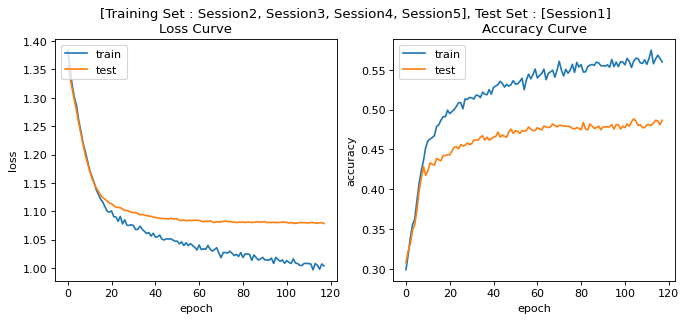

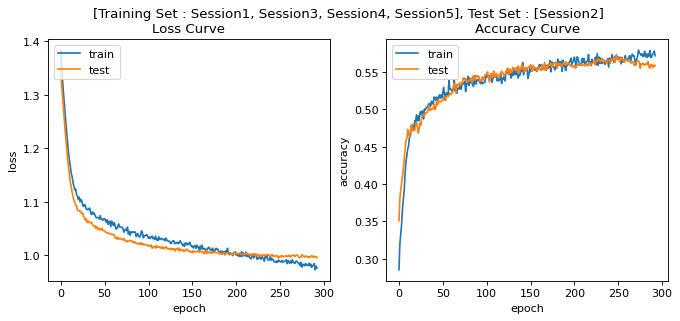

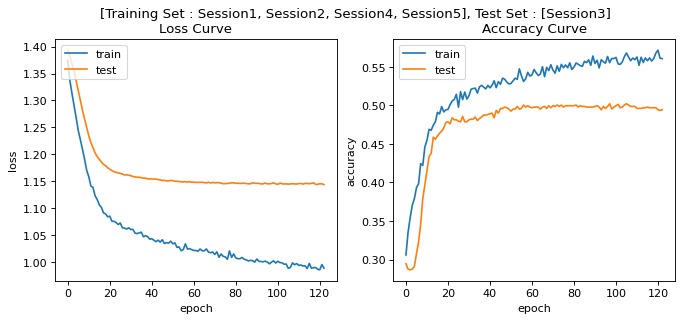

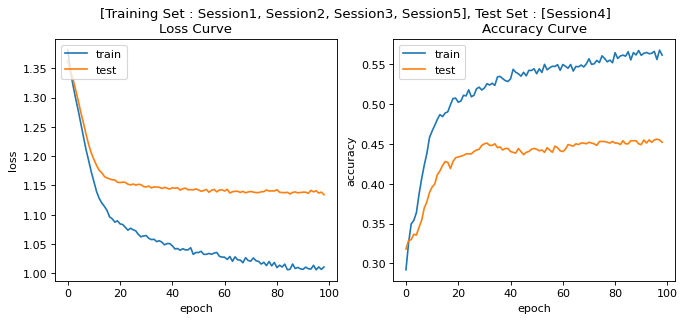

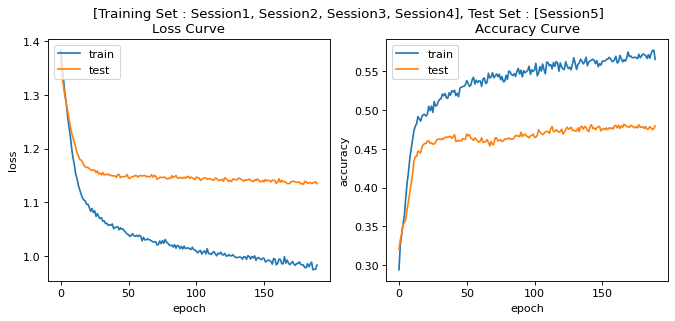

In [132]:
getLAACurves([refined30history, refined31history, refined32history, refined33history, refined34history]) 

# Refined Model 3 Scores across all iterations of 5 - fold

In [134]:
getScores(test, [model30Refined, model31Refined, model32Refined, model33Refined, model34Refined])

1. [Training Set : Session2, Session3, Session4, Session5], Test Set : [Session1]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.5203619909502262
Happy    |   0.3861566484517304
Sad      |   0.5370843989769821
Neutral  |   0.5126903553299492


-------------------------------
Macro F1 Score :  0.48907334842722194


-------------------------------
Accuracy Score :  0.48663594470046084

-------------------------------------------------------------------------------------------------

2. [Training Set : Session1, Session3, Session4, Session5], Test Set : [Session2]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.4904458598726114
Happy    |   0.526813880126183
Sad      |   0.6191780821917809
Neutral  |   0.5866302864938608


-------------------------------
Macro F1 Score :  0.555767027171109


-------------------------------
Accuracy 

In [135]:
print("\nTraining and testing on Chunk : 1-------------------------\n")
modelOSF30, historyOSF30 = thirdModel(0, 32, 150, trainOSF, testOSF, 88)     # 125 epoch --> early stopping

print("\nTraining and testing on Chunk : 2-------------------------\n")
modelOSF31, historyOSF31 = thirdModel(1, 32, 150, trainOSF, testOSF, 88)    # 125 epoch --> early stopping

print("\nTraining and testing on Chunk : 3-------------------------\n")
modelOSF32, historyOSF32 = thirdModel(2, 32, 150, trainOSF, testOSF, 88)     # 101 epoch ----> early stopping

print("\nTraining and testing on Chunk : 4-------------------------\n")
modelOSF33, historyOSF33 = thirdModel(3, 32, 150, trainOSF, testOSF, 88)     # 150 epoch ----> early stopping

print("\nTraining and testing on Chunk : 5-------------------------\n")
modelOSF34, historyOSF34 = thirdModel(4, 32, 150, trainOSF, testOSF, 88)     # 150 epoch ----> early stopping


Training and testing on Chunk : 1-------------------------

Epoch 1/150
139/139 [==============================] - 2s 7ms/step - loss: 1.4087 - accuracy: 0.2890 - val_loss: 1.3553 - val_accuracy: 0.3346
Epoch 2/150
139/139 [==============================] - 1s 5ms/step - loss: 1.3372 - accuracy: 0.3737 - val_loss: 1.2844 - val_accuracy: 0.4138
Epoch 3/150
139/139 [==============================] - 1s 4ms/step - loss: 1.2956 - accuracy: 0.3991 - val_loss: 1.2265 - val_accuracy: 0.4562
Epoch 4/150
139/139 [==============================] - 1s 4ms/step - loss: 1.2453 - accuracy: 0.4426 - val_loss: 1.1827 - val_accuracy: 0.4857
Epoch 5/150
139/139 [==============================] - 1s 5ms/step - loss: 1.2116 - accuracy: 0.4493 - val_loss: 1.1485 - val_accuracy: 0.5051
Epoch 6/150
139/139 [==============================] - 1s 4ms/step - loss: 1.1812 - accuracy: 0.4755 - val_loss: 1.1229 - val_accuracy: 0.5143
Epoch 7/150
139/139 [==============================] - 1s 4ms/step - loss: 1.1491

Epoch 114/150
139/139 [==============================] - 1s 4ms/step - loss: 0.9068 - accuracy: 0.6130 - val_loss: 1.1417 - val_accuracy: 0.5244
Epoch 115/150
139/139 [==============================] - 1s 4ms/step - loss: 0.9085 - accuracy: 0.6175 - val_loss: 1.1377 - val_accuracy: 0.5300
Epoch 116/150
139/139 [==============================] - 1s 5ms/step - loss: 0.8899 - accuracy: 0.6198 - val_loss: 1.1378 - val_accuracy: 0.5272
Epoch 117/150
139/139 [==============================] - 1s 4ms/step - loss: 0.9043 - accuracy: 0.6080 - val_loss: 1.1438 - val_accuracy: 0.5226
Epoch 118/150
139/139 [==============================] - 1s 4ms/step - loss: 0.8962 - accuracy: 0.6248 - val_loss: 1.1314 - val_accuracy: 0.5336
Epoch 119/150
139/139 [==============================] - 1s 4ms/step - loss: 0.9009 - accuracy: 0.6200 - val_loss: 1.1371 - val_accuracy: 0.5253
Epoch 120/150
139/139 [==============================] - 1s 4ms/step - loss: 0.9196 - accuracy: 0.6096 - val_loss: 1.1464 - val_ac

Epoch 77/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9380 - accuracy: 0.5875 - val_loss: 0.9227 - val_accuracy: 0.6012
Epoch 78/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9404 - accuracy: 0.5947 - val_loss: 0.9247 - val_accuracy: 0.5963
Epoch 79/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9465 - accuracy: 0.6099 - val_loss: 0.9245 - val_accuracy: 0.6022
Epoch 80/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9423 - accuracy: 0.5955 - val_loss: 0.9256 - val_accuracy: 0.5973
Epoch 81/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9509 - accuracy: 0.5899 - val_loss: 0.9233 - val_accuracy: 0.5982
Epoch 82/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9607 - accuracy: 0.5852 - val_loss: 0.9228 - val_accuracy: 0.5982
Epoch 83/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9308 - accuracy: 0.5976 - val_loss: 0.9230 - val_accuracy:

137/137 [==============================] - 1s 4ms/step - loss: 0.9449 - accuracy: 0.5941 - val_loss: 1.1559 - val_accuracy: 0.4978
Epoch 40/150
137/137 [==============================] - 1s 5ms/step - loss: 0.9420 - accuracy: 0.5933 - val_loss: 1.1572 - val_accuracy: 0.4909
Epoch 41/150
137/137 [==============================] - 1s 5ms/step - loss: 0.9262 - accuracy: 0.5958 - val_loss: 1.1496 - val_accuracy: 0.5030
Epoch 42/150
137/137 [==============================] - 1s 5ms/step - loss: 0.9292 - accuracy: 0.5922 - val_loss: 1.1496 - val_accuracy: 0.5065
Epoch 43/150
137/137 [==============================] - 1s 5ms/step - loss: 0.9217 - accuracy: 0.6079 - val_loss: 1.1477 - val_accuracy: 0.5030
Epoch 44/150
137/137 [==============================] - 1s 5ms/step - loss: 0.9174 - accuracy: 0.6030 - val_loss: 1.1516 - val_accuracy: 0.5056
Epoch 45/150
137/137 [==============================] - 1s 4ms/step - loss: 0.9570 - accuracy: 0.5849 - val_loss: 1.1548 - val_accuracy: 0.5013
Epoch

Epoch 96/150
137/137 [==============================] - 1s 4ms/step - loss: 0.9129 - accuracy: 0.6069 - val_loss: 1.1326 - val_accuracy: 0.5308
Epoch 97/150
137/137 [==============================] - 1s 4ms/step - loss: 0.8776 - accuracy: 0.6255 - val_loss: 1.1306 - val_accuracy: 0.5308
Epoch 98/150
137/137 [==============================] - 1s 5ms/step - loss: 0.8832 - accuracy: 0.6221 - val_loss: 1.1308 - val_accuracy: 0.5308
Epoch 99/150
137/137 [==============================] - 1s 5ms/step - loss: 0.8799 - accuracy: 0.6239 - val_loss: 1.1374 - val_accuracy: 0.5239
Epoch 100/150
137/137 [==============================] - 1s 5ms/step - loss: 0.8773 - accuracy: 0.6280 - val_loss: 1.1341 - val_accuracy: 0.5274
Epoch 101/150
137/137 [==============================] - 1s 5ms/step - loss: 0.9047 - accuracy: 0.6127 - val_loss: 1.1288 - val_accuracy: 0.5326
Epoch 102/150
137/137 [==============================] - 1s 4ms/step - loss: 0.8938 - accuracy: 0.6023 - val_loss: 1.1256 - val_accura

141/141 [==============================] - 1s 5ms/step - loss: 0.9463 - accuracy: 0.5860 - val_loss: 1.0013 - val_accuracy: 0.5325
Epoch 60/150
141/141 [==============================] - 1s 5ms/step - loss: 0.9551 - accuracy: 0.5895 - val_loss: 0.9975 - val_accuracy: 0.5461
Epoch 61/150
141/141 [==============================] - 1s 5ms/step - loss: 0.9254 - accuracy: 0.5949 - val_loss: 0.9958 - val_accuracy: 0.5432
Epoch 62/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9249 - accuracy: 0.6000 - val_loss: 0.9978 - val_accuracy: 0.5461
Epoch 63/150
141/141 [==============================] - 1s 5ms/step - loss: 0.9512 - accuracy: 0.5948 - val_loss: 0.9911 - val_accuracy: 0.5500
Epoch 64/150
141/141 [==============================] - 1s 5ms/step - loss: 0.9390 - accuracy: 0.5977 - val_loss: 0.9955 - val_accuracy: 0.5480
Epoch 65/150
141/141 [==============================] - 1s 5ms/step - loss: 0.9295 - accuracy: 0.6004 - val_loss: 0.9931 - val_accuracy: 0.5480
Epoch

Epoch 116/150
141/141 [==============================] - 1s 5ms/step - loss: 0.8952 - accuracy: 0.6221 - val_loss: 0.9733 - val_accuracy: 0.5577
Epoch 117/150
141/141 [==============================] - 1s 5ms/step - loss: 0.9131 - accuracy: 0.6078 - val_loss: 0.9740 - val_accuracy: 0.5597
Epoch 118/150
141/141 [==============================] - 1s 5ms/step - loss: 0.8861 - accuracy: 0.6250 - val_loss: 0.9747 - val_accuracy: 0.5548
Epoch 119/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9035 - accuracy: 0.6200 - val_loss: 0.9749 - val_accuracy: 0.5529
Epoch 120/150
141/141 [==============================] - 1s 4ms/step - loss: 0.9071 - accuracy: 0.6075 - val_loss: 0.9740 - val_accuracy: 0.5558
Epoch 121/150
141/141 [==============================] - 1s 5ms/step - loss: 0.9098 - accuracy: 0.6206 - val_loss: 0.9729 - val_accuracy: 0.5587
Epoch 122/150
141/141 [==============================] - 1s 5ms/step - loss: 0.8820 - accuracy: 0.6263 - val_loss: 0.9733 - val_ac

Epoch 79/150
135/135 [==============================] - 1s 5ms/step - loss: 0.9185 - accuracy: 0.6048 - val_loss: 1.0254 - val_accuracy: 0.5359
Epoch 80/150
135/135 [==============================] - 1s 5ms/step - loss: 0.9312 - accuracy: 0.6064 - val_loss: 1.0252 - val_accuracy: 0.5310
Epoch 81/150
135/135 [==============================] - 1s 5ms/step - loss: 0.9153 - accuracy: 0.6145 - val_loss: 1.0256 - val_accuracy: 0.5359
Epoch 82/150
135/135 [==============================] - 1s 5ms/step - loss: 0.9127 - accuracy: 0.6097 - val_loss: 1.0243 - val_accuracy: 0.5383
Epoch 83/150
135/135 [==============================] - 1s 5ms/step - loss: 0.9172 - accuracy: 0.6149 - val_loss: 1.0336 - val_accuracy: 0.5318
Epoch 84/150
135/135 [==============================] - 1s 5ms/step - loss: 0.9145 - accuracy: 0.6203 - val_loss: 1.0265 - val_accuracy: 0.5359
Epoch 85/150
135/135 [==============================] - 1s 5ms/step - loss: 0.9220 - accuracy: 0.6123 - val_loss: 1.0287 - val_accuracy:

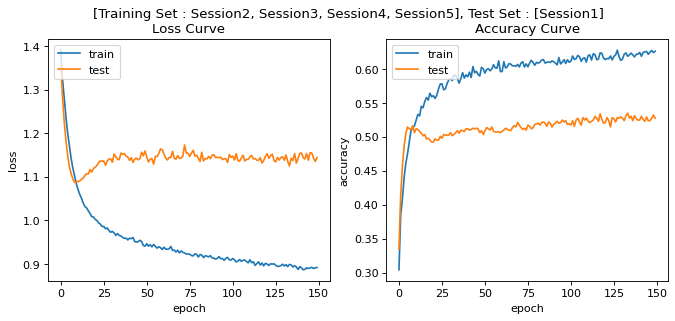

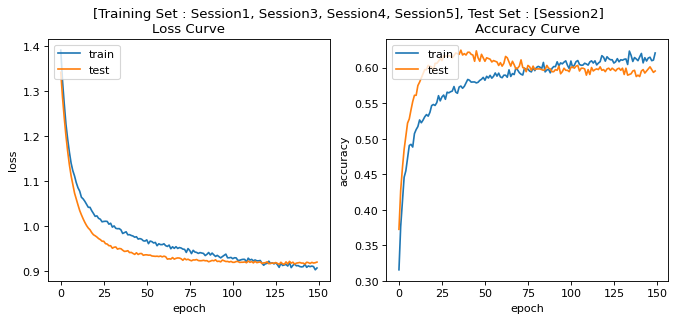

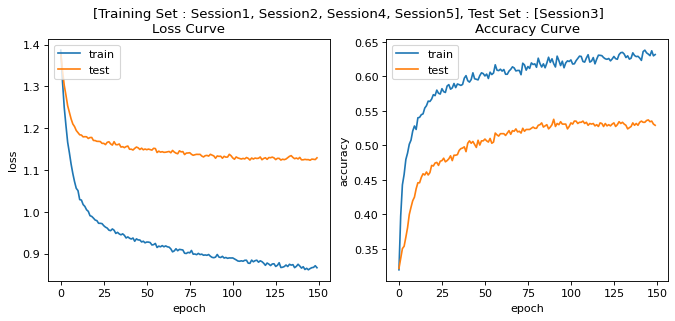

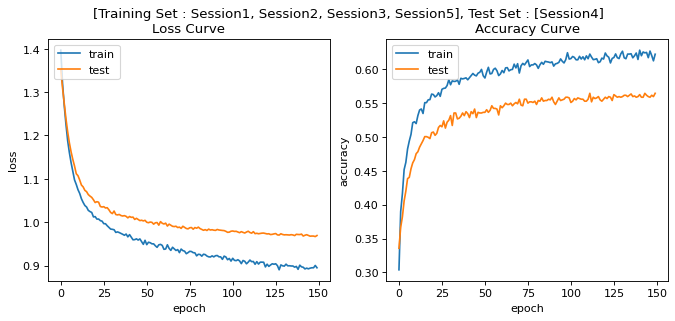

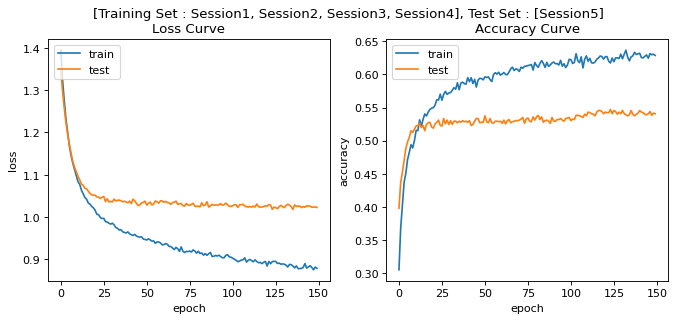

In [142]:
getLAACurves([historyOSF30, historyOSF31, historyOSF32, historyOSF33, historyOSF34]) 

In [136]:
print("Training and testing on Chunk : 1-------------------------")
modelOSRefinedF30, historyOSRefinedF30 = thirdModel(0, 32, 9, trainOSF, testOSF, 88)    

print("Training and testing on Chunk : 2-------------------------")
modelOSRefinedF31, historyOSRefinedF31 = thirdModel(1, 32, 128, trainOSF, testOSF, 88)    

print("Training and testing on Chunk : 3-------------------------")
modelOSRefinedF32, historyOSRefinedF32 = thirdModel(2, 32, 146, trainOSF, testOSF, 88)    

print("Training and testing on Chunk : 4-------------------------")
modelOSRefinedF33, historyOSRefinedF33 = thirdModel(3, 32, 149, trainOSF, testOSF, 88)     

print("Training and testing on Chunk : 5-------------------------")
modelOSRefinedF34, historyOSRefinedF34 = thirdModel(4, 32, 136, trainOSF, testOSF, 88)     

Training and testing on Chunk : 1-------------------------
Epoch 1/9
139/139 [==============================] - 1s 4ms/step - loss: 1.4087 - accuracy: 0.2890 - val_loss: 1.3553 - val_accuracy: 0.3346
Epoch 2/9
139/139 [==============================] - 0s 3ms/step - loss: 1.3372 - accuracy: 0.3737 - val_loss: 1.2844 - val_accuracy: 0.4138
Epoch 3/9
139/139 [==============================] - 0s 3ms/step - loss: 1.2956 - accuracy: 0.3991 - val_loss: 1.2265 - val_accuracy: 0.4562
Epoch 4/9
139/139 [==============================] - 0s 3ms/step - loss: 1.2453 - accuracy: 0.4426 - val_loss: 1.1827 - val_accuracy: 0.4857
Epoch 5/9
139/139 [==============================] - 0s 3ms/step - loss: 1.2116 - accuracy: 0.4493 - val_loss: 1.1485 - val_accuracy: 0.5051
Epoch 6/9
139/139 [==============================] - 0s 3ms/step - loss: 1.1812 - accuracy: 0.4755 - val_loss: 1.1229 - val_accuracy: 0.5143
Epoch 7/9
139/139 [==============================] - 0s 3ms/step - loss: 1.1491 - accuracy: 0.4

Epoch 105/128
141/141 [==============================] - 0s 3ms/step - loss: 0.9128 - accuracy: 0.6123 - val_loss: 0.9192 - val_accuracy: 0.6031
Epoch 106/128
141/141 [==============================] - 0s 3ms/step - loss: 0.9256 - accuracy: 0.6093 - val_loss: 0.9195 - val_accuracy: 0.5953
Epoch 107/128
141/141 [==============================] - 0s 3ms/step - loss: 0.9317 - accuracy: 0.5989 - val_loss: 0.9195 - val_accuracy: 0.5992
Epoch 108/128
141/141 [==============================] - 0s 3ms/step - loss: 0.9362 - accuracy: 0.5971 - val_loss: 0.9202 - val_accuracy: 0.5992
Epoch 109/128
141/141 [==============================] - 0s 3ms/step - loss: 0.9140 - accuracy: 0.6172 - val_loss: 0.9184 - val_accuracy: 0.5982
Epoch 110/128
141/141 [==============================] - 0s 3ms/step - loss: 0.9365 - accuracy: 0.5930 - val_loss: 0.9223 - val_accuracy: 0.5894
Epoch 111/128
141/141 [==============================] - 0s 3ms/step - loss: 0.9317 - accuracy: 0.6070 - val_loss: 0.9194 - val_ac

Epoch 90/146
137/137 [==============================] - 0s 3ms/step - loss: 0.8958 - accuracy: 0.6195 - val_loss: 1.1335 - val_accuracy: 0.5300
Epoch 91/146
137/137 [==============================] - 0s 3ms/step - loss: 0.9043 - accuracy: 0.6128 - val_loss: 1.1280 - val_accuracy: 0.5378
Epoch 92/146
137/137 [==============================] - 0s 3ms/step - loss: 0.9049 - accuracy: 0.6182 - val_loss: 1.1334 - val_accuracy: 0.5274
Epoch 93/146
137/137 [==============================] - 0s 3ms/step - loss: 0.9132 - accuracy: 0.6173 - val_loss: 1.1324 - val_accuracy: 0.5317
Epoch 94/146
137/137 [==============================] - 0s 3ms/step - loss: 0.8980 - accuracy: 0.6102 - val_loss: 1.1329 - val_accuracy: 0.5300
Epoch 95/146
137/137 [==============================] - 0s 3ms/step - loss: 0.8952 - accuracy: 0.6178 - val_loss: 1.1281 - val_accuracy: 0.5343
Epoch 96/146
137/137 [==============================] - 0s 3ms/step - loss: 0.9129 - accuracy: 0.6069 - val_loss: 1.1326 - val_accuracy:

141/141 [==============================] - 0s 3ms/step - loss: 0.9388 - accuracy: 0.6089 - val_loss: 0.9986 - val_accuracy: 0.5422
Epoch 57/149
141/141 [==============================] - 0s 3ms/step - loss: 0.9384 - accuracy: 0.6075 - val_loss: 0.9991 - val_accuracy: 0.5422
Epoch 58/149
141/141 [==============================] - 0s 3ms/step - loss: 0.9363 - accuracy: 0.5931 - val_loss: 0.9932 - val_accuracy: 0.5412
Epoch 59/149
141/141 [==============================] - 0s 3ms/step - loss: 0.9463 - accuracy: 0.5860 - val_loss: 1.0013 - val_accuracy: 0.5325
Epoch 60/149
141/141 [==============================] - 0s 3ms/step - loss: 0.9551 - accuracy: 0.5895 - val_loss: 0.9975 - val_accuracy: 0.5461
Epoch 61/149
141/141 [==============================] - 0s 3ms/step - loss: 0.9254 - accuracy: 0.5949 - val_loss: 0.9958 - val_accuracy: 0.5432
Epoch 62/149
141/141 [==============================] - 0s 3ms/step - loss: 0.9249 - accuracy: 0.6000 - val_loss: 0.9978 - val_accuracy: 0.5461
Epoch

Epoch 113/149
141/141 [==============================] - 0s 3ms/step - loss: 0.9137 - accuracy: 0.6129 - val_loss: 0.9781 - val_accuracy: 0.5519
Epoch 114/149
141/141 [==============================] - 0s 3ms/step - loss: 0.8929 - accuracy: 0.6220 - val_loss: 0.9736 - val_accuracy: 0.5587
Epoch 115/149
141/141 [==============================] - 0s 3ms/step - loss: 0.9126 - accuracy: 0.6160 - val_loss: 0.9744 - val_accuracy: 0.5567
Epoch 116/149
141/141 [==============================] - 0s 3ms/step - loss: 0.8952 - accuracy: 0.6221 - val_loss: 0.9733 - val_accuracy: 0.5577
Epoch 117/149
141/141 [==============================] - 0s 3ms/step - loss: 0.9131 - accuracy: 0.6078 - val_loss: 0.9740 - val_accuracy: 0.5597
Epoch 118/149
141/141 [==============================] - 0s 2ms/step - loss: 0.8861 - accuracy: 0.6250 - val_loss: 0.9747 - val_accuracy: 0.5548
Epoch 119/149
141/141 [==============================] - 0s 2ms/step - loss: 0.9035 - accuracy: 0.6200 - val_loss: 0.9749 - val_ac

Epoch 77/136
135/135 [==============================] - 0s 3ms/step - loss: 0.9165 - accuracy: 0.6084 - val_loss: 1.0302 - val_accuracy: 0.5294
Epoch 78/136
135/135 [==============================] - 0s 3ms/step - loss: 0.9120 - accuracy: 0.6176 - val_loss: 1.0325 - val_accuracy: 0.5286
Epoch 79/136
135/135 [==============================] - 0s 3ms/step - loss: 0.9185 - accuracy: 0.6048 - val_loss: 1.0254 - val_accuracy: 0.5359
Epoch 80/136
135/135 [==============================] - 0s 3ms/step - loss: 0.9312 - accuracy: 0.6064 - val_loss: 1.0252 - val_accuracy: 0.5310
Epoch 81/136
135/135 [==============================] - 0s 3ms/step - loss: 0.9153 - accuracy: 0.6145 - val_loss: 1.0256 - val_accuracy: 0.5359
Epoch 82/136
135/135 [==============================] - 0s 3ms/step - loss: 0.9127 - accuracy: 0.6097 - val_loss: 1.0243 - val_accuracy: 0.5383
Epoch 83/136
135/135 [==============================] - 0s 3ms/step - loss: 0.9172 - accuracy: 0.6149 - val_loss: 1.0336 - val_accuracy:

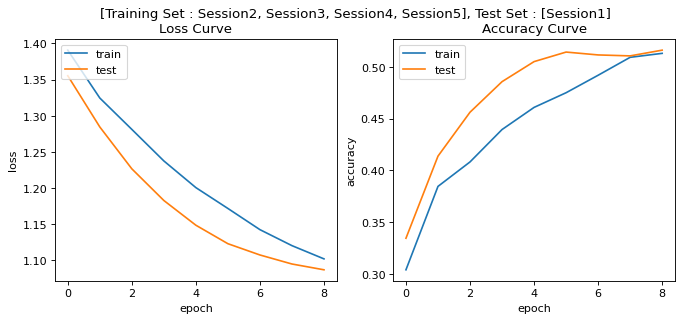

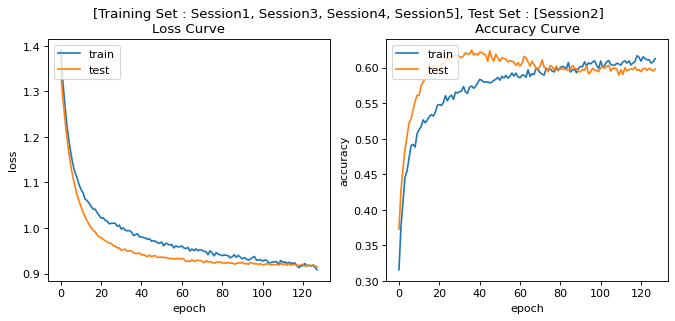

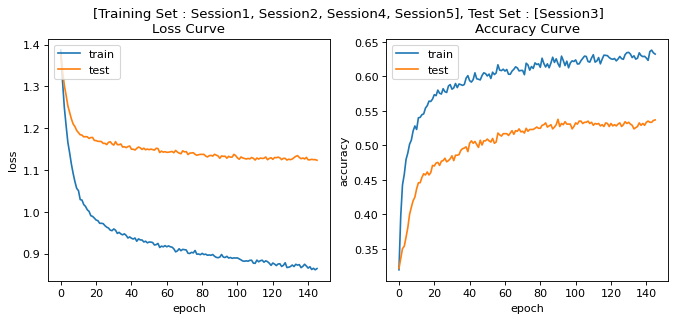

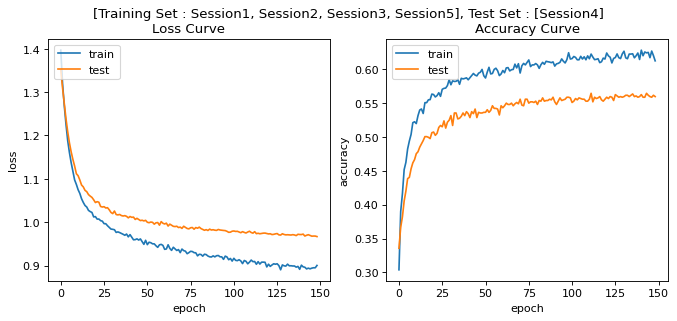

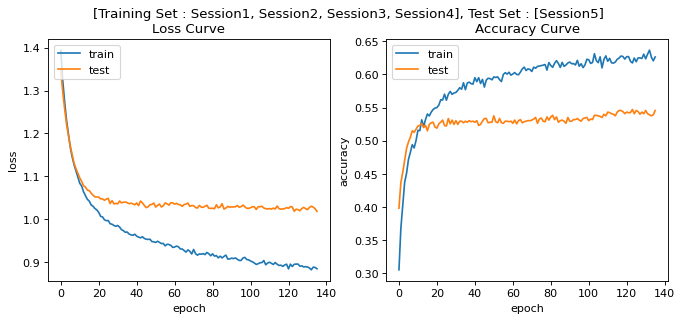

In [137]:
getLAACurves([historyOSRefinedF30, historyOSRefinedF31, historyOSRefinedF32, historyOSRefinedF33, historyOSRefinedF34]) 

In [138]:
getScores(testOSF, [modelOSRefinedF30, modelOSRefinedF31, modelOSRefinedF32, modelOSRefinedF33, modelOSRefinedF34])

1. [Training Set : Session2, Session3, Session4, Session5], Test Set : [Session1]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.608695652173913
Happy    |   0.40559440559440557
Sad      |   0.5702647657841141
Neutral  |   0.5032051282051283


-------------------------------
Macro F1 Score :  0.5219399879393902


-------------------------------
Accuracy Score :  0.5161290322580645

-------------------------------------------------------------------------------------------------

2. [Training Set : Session1, Session3, Session4, Session5], Test Set : [Session2]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.6113207547169812
Happy    |   0.5575757575757576
Sad      |   0.6595174262734586
Neutral  |   0.5989304812834224


-------------------------------
Macro F1 Score :  0.6068361049624049


-------------------------------
Accuracy 

# CNN + LSTM

In [58]:
def fourthModel(chunk, batchSize, epoc, train, test, featureVectorSize):
    
    tf.random.set_seed(42)
    
    xTrainCNN = np.expand_dims(train[chunk]["XTrain"], axis=2)
    xTestCNN = np.expand_dims(test[chunk]["XTest"], axis=2)

    yTrainCNN = keras.utils.to_categorical(train[chunk]["yTrain"])
    yTestCNN = keras.utils.to_categorical(test[chunk]["yTest"])
    
    
    # model
    model = Sequential()
    model.add(Conv1D(8, 3,input_shape = (featureVectorSize, 1), padding='same', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(4)))

    model.add(Conv1D(16, 5,padding='same',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(4)))

    model.add(Conv1D(32, 5,padding='same',kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    model.add(LSTM(units = 64, kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) 

    model.add(Flatten())

    model.add(Dense(units = 16))

    model.add(Dense(units = 4,activation='softmax'))

    # model optimizer
    opt = keras.optimizers.Adam(lr=0.00005)
    
    #model compilation
    model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])
    
    
    #model history
    history=model.fit(xTrainCNN, yTrainCNN, batch_size = batchSize, epochs = epoc, validation_data=(xTestCNN, yTestCNN))
              
    return model, history
    

In [143]:
print("\nTraining and testing on Chunk : 1-------------------------\n")
model40, history40 = fourthModel(0, 32, 300)     # 60 epoch --> early stopping

print("\nTraining and testing on Chunk : 2-------------------------\n")
model41, history41 = fourthModel(1, 32, 500)    # 489 epoch --> early stopping

print("\nTraining and testing on Chunk : 3-------------------------\n")
model42, history42 = fourthModel(2, 32, 300)     # 225 epoch ----> early stopping

print("\nTraining and testing on Chunk : 4-------------------------\n")
model43, history43 = fourthModel(3, 32, 300)     # 225 epoch ----> early stopping

print("\nTraining and testing on Chunk : 5-------------------------\n")
model44, history44 = fourthModel(4, 32, 200)     # 135 epoch ----> early stopping


Training and testing on Chunk : 5-------------------------

Epoch 1/200
135/135 [==============================] - 5s 10ms/step - loss: 1.6398 - accuracy: 0.2725 - val_loss: 1.6094 - val_accuracy: 0.3263
Epoch 2/200
135/135 [==============================] - 1s 5ms/step - loss: 1.6073 - accuracy: 0.3364 - val_loss: 1.5795 - val_accuracy: 0.3336
Epoch 3/200
135/135 [==============================] - 1s 5ms/step - loss: 1.5839 - accuracy: 0.3302 - val_loss: 1.5549 - val_accuracy: 0.3441
Epoch 4/200
135/135 [==============================] - 1s 5ms/step - loss: 1.5561 - accuracy: 0.3554 - val_loss: 1.5328 - val_accuracy: 0.3811
Epoch 5/200
135/135 [==============================] - 1s 5ms/step - loss: 1.5317 - accuracy: 0.3621 - val_loss: 1.5090 - val_accuracy: 0.3731
Epoch 6/200
135/135 [==============================] - 1s 5ms/step - loss: 1.5028 - accuracy: 0.3555 - val_loss: 1.4815 - val_accuracy: 0.3836
Epoch 7/200
135/135 [==============================] - 1s 5ms/step - loss: 1.465

Epoch 114/200
135/135 [==============================] - 1s 5ms/step - loss: 1.1487 - accuracy: 0.4898 - val_loss: 1.2163 - val_accuracy: 0.4561
Epoch 115/200
135/135 [==============================] - 1s 5ms/step - loss: 1.1586 - accuracy: 0.4859 - val_loss: 1.2144 - val_accuracy: 0.4649
Epoch 116/200
135/135 [==============================] - 1s 5ms/step - loss: 1.1542 - accuracy: 0.4935 - val_loss: 1.2164 - val_accuracy: 0.4585
Epoch 117/200
135/135 [==============================] - 1s 5ms/step - loss: 1.1389 - accuracy: 0.4989 - val_loss: 1.2101 - val_accuracy: 0.4658
Epoch 118/200
135/135 [==============================] - 1s 5ms/step - loss: 1.1478 - accuracy: 0.4943 - val_loss: 1.2101 - val_accuracy: 0.4674
Epoch 119/200
135/135 [==============================] - 1s 5ms/step - loss: 1.1513 - accuracy: 0.4796 - val_loss: 1.2111 - val_accuracy: 0.4649
Epoch 120/200
135/135 [==============================] - 1s 5ms/step - loss: 1.1393 - accuracy: 0.4972 - val_loss: 1.2137 - val_ac

# Loss and Accuracy Curve for Model - 4

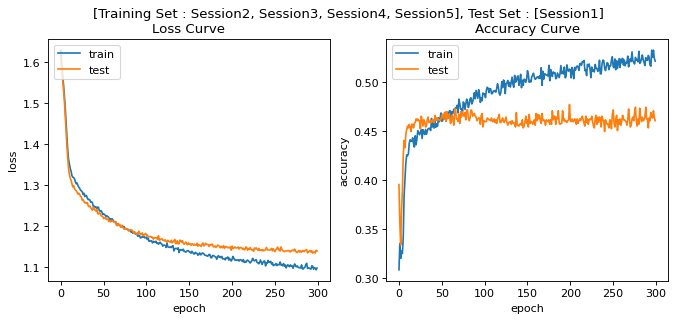

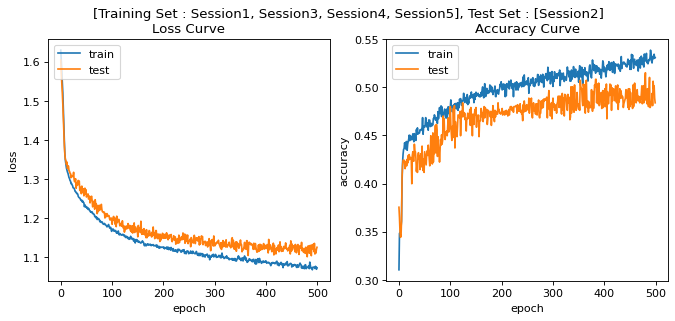

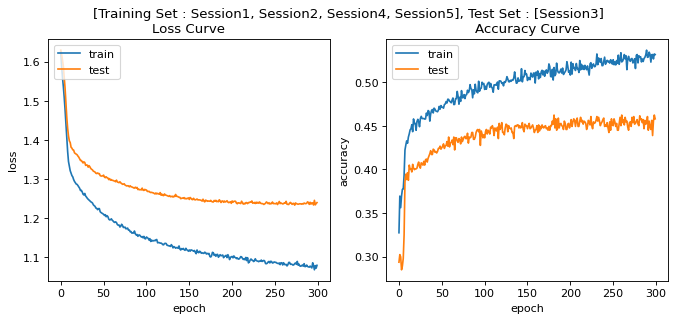

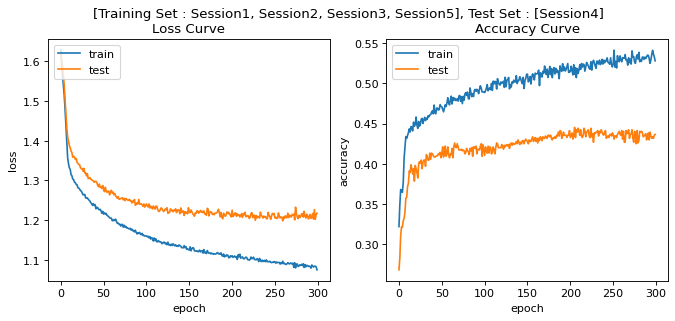

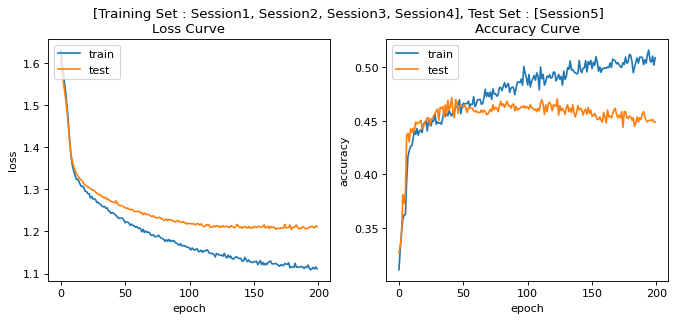

In [148]:
getLAACurves([history40, history41, history42, history43, history44]) 

# Refining Model 4

In [146]:
#
print("\nTraining Model40 with Early Stopping for chunk : 1------------------\n")
model40Refined, refined40history = fourthModel(0, 32, 60)

#
print("\nTraining Model41 with Early Stopping for chunk : 2------------------\n")
model41Refined, refined41history = fourthModel(1, 32, 489)

#
print("\nTraining Model42 with Early Stopping for chunk : 3------------------\n")
model42Refined, refined42history = fourthModel(2, 32, 225)

#
print("\nTraining Model43 with Early Stopping for chunk : 4------------------\n")
model43Refined, refined43history = fourthModel(3, 32, 225)

#
print("\nTraining Model44 with Early Stopping for chunk : 5------------------\n")
model44Refined, refined44history = fourthModel(4, 32, 52)


Training Model44 with Early Stopping for chunk : 5------------------

Epoch 1/52
135/135 [==============================] - 4s 10ms/step - loss: 1.6398 - accuracy: 0.2725 - val_loss: 1.6094 - val_accuracy: 0.3263
Epoch 2/52
135/135 [==============================] - 1s 5ms/step - loss: 1.6073 - accuracy: 0.3364 - val_loss: 1.5795 - val_accuracy: 0.3336
Epoch 3/52
135/135 [==============================] - 1s 5ms/step - loss: 1.5839 - accuracy: 0.3302 - val_loss: 1.5549 - val_accuracy: 0.3441
Epoch 4/52
135/135 [==============================] - 1s 5ms/step - loss: 1.5561 - accuracy: 0.3554 - val_loss: 1.5328 - val_accuracy: 0.3811
Epoch 5/52
135/135 [==============================] - 1s 5ms/step - loss: 1.5317 - accuracy: 0.3621 - val_loss: 1.5090 - val_accuracy: 0.3731
Epoch 6/52
135/135 [==============================] - 1s 5ms/step - loss: 1.5028 - accuracy: 0.3555 - val_loss: 1.4815 - val_accuracy: 0.3836
Epoch 7/52
135/135 [==============================] - 1s 5ms/step - loss: 1.

# Loss and Accuracy Curve for Refined Model - 4

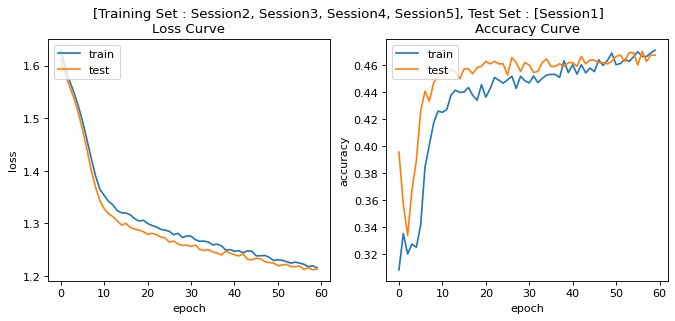

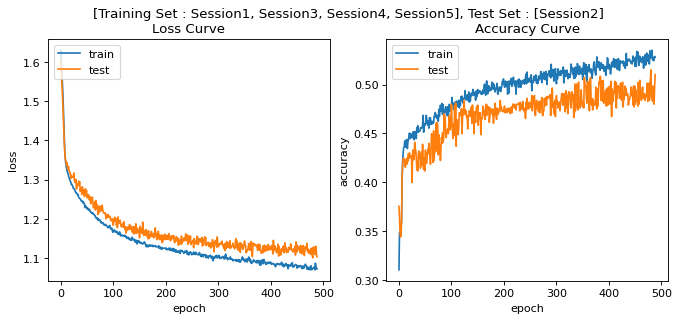

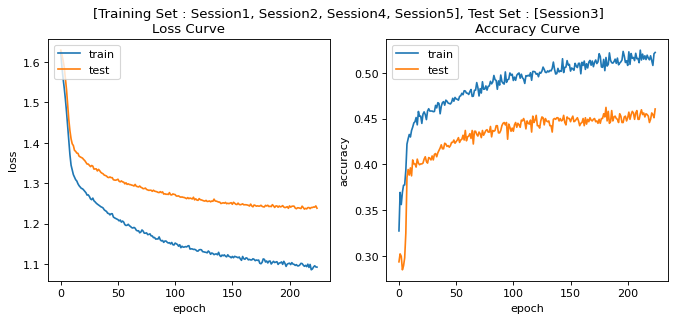

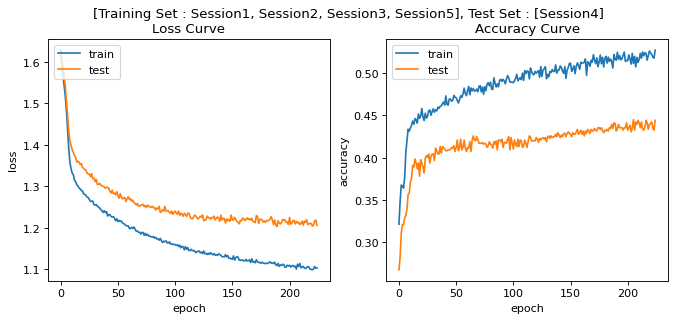

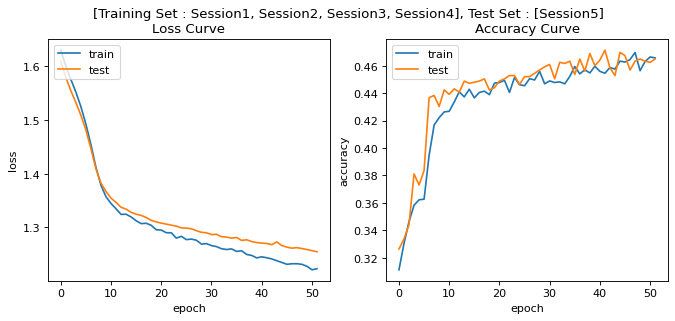

In [149]:
getLAACurves([refined40history, refined41history, refined42history, refined43history, refined44history]) 

# Refined Model 4 Scores across all iterations of 5 - fold

In [150]:
getScores([model40Refined, model41Refined, model42Refined, model43Refined, model44Refined])

1. [Training Set : Session2, Session3, Session4, Session5], Test Set : [Session1]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.39769452449567727
Happy    |   0.41353383458646614
Sad      |   0.5592592592592592
Neutral  |   0.47137150466045274


-------------------------------
Macro F1 Score :  0.4604647807504639


-------------------------------
Accuracy Score :  0.46728110599078343

-------------------------------------------------------------------------------------------------

2. [Training Set : Session1, Session3, Session4, Session5], Test Set : [Session2]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.48684210526315796
Happy    |   0.4748201438848921
Sad      |   0.6453333333333333
Neutral  |   0.4821428571428572


-------------------------------
Macro F1 Score :  0.5222846099060601


-------------------------------
Accu

In [87]:
def fourthModelTweaked(chunk, batchSize, epoc, train, test, featureVectorSize):
    
    tf.random.set_seed(42)
    
    xTrainCNN = np.expand_dims(train[chunk]["XTrain"], axis=2)
    xTestCNN = np.expand_dims(test[chunk]["XTest"], axis=2)

    yTrainCNN = keras.utils.to_categorical(train[chunk]["yTrain"])
    yTestCNN = keras.utils.to_categorical(test[chunk]["yTest"])
    
    
    # model
    model = Sequential()

    model.add(Conv1D(32, 3,padding='same',input_shape=(featureVectorSize,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    
    model.add(Conv1D(64, 5,padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    
    model.add(Conv1D(128, 5,padding='same'))
    model.add(Activation('relu'))
    
    model.add(LSTM(units = 256)) 
    
    model.add(Flatten())
    
    model.add(Dense(units = 32))
    
    model.add(Dense(units = 4, activation='softmax'))

    # model optimizer
    opt = keras.optimizers.Adam(lr=0.00005)
    
    #model compilation
    model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])
    
    
    #model history
    history=model.fit(xTrainCNN, yTrainCNN, batch_size = batchSize, epochs = epoc, validation_data=(xTestCNN, yTestCNN))
              
    return model, history
    

In [98]:
print("\nTraining and testing on Chunk : 1-------------------------\n")
modelOSF40, historyOSF40 = fourthModelTweaked(0, 32, 100, trainOSF, testOSF, 88)     # 11 epoch --> early stopping

print("\nTraining and testing on Chunk : 2-------------------------\n")
modelOSF41, historyOSF41 = fourthModelTweaked(1, 32, 100, trainOSF, testOSF, 88)    # 38 epoch --> early stopping

print("\nTraining and testing on Chunk : 3-------------------------\n")
modelOSF42, historyOSF42 = fourthModelTweaked(2, 32, 100, trainOSF, testOSF, 88)     # 23 epoch ----> early stopping

print("\nTraining and testing on Chunk : 4-------------------------\n")
modelOSF43, historyOSF43 = fourthModelTweaked(3, 32, 100, trainOSF, testOSF, 88)     # 31 epoch ----> early stopping

print("\nTraining and testing on Chunk : 5-------------------------\n")
modelOSF44, historyOSF44 = fourthModelTweaked(4, 32, 100, trainOSF, testOSF, 88)     # 41 epoch ----> early stopping


Training and testing on Chunk : 1-------------------------

Epoch 1/100
139/139 [==============================] - 10s 57ms/step - loss: 1.3727 - accuracy: 0.2975 - val_loss: 1.2274 - val_accuracy: 0.3760
Epoch 2/100
139/139 [==============================] - 7s 51ms/step - loss: 1.2069 - accuracy: 0.4087 - val_loss: 1.1555 - val_accuracy: 0.4442
Epoch 3/100
139/139 [==============================] - 7s 53ms/step - loss: 1.1587 - accuracy: 0.4534 - val_loss: 1.1072 - val_accuracy: 0.4488
Epoch 4/100
139/139 [==============================] - 7s 52ms/step - loss: 1.1369 - accuracy: 0.4675 - val_loss: 1.1175 - val_accuracy: 0.4461
Epoch 5/100
139/139 [==============================] - 7s 52ms/step - loss: 1.1206 - accuracy: 0.4728 - val_loss: 1.2222 - val_accuracy: 0.4184
Epoch 6/100
139/139 [==============================] - 7s 53ms/step - loss: 1.1038 - accuracy: 0.4932 - val_loss: 1.1648 - val_accuracy: 0.4415
Epoch 7/100
139/139 [==============================] - 8s 54ms/step - loss

141/141 [==============================] - 8s 53ms/step - loss: 1.0528 - accuracy: 0.5215 - val_loss: 1.0107 - val_accuracy: 0.5543
Epoch 14/100
141/141 [==============================] - 7s 53ms/step - loss: 1.0324 - accuracy: 0.5385 - val_loss: 0.9892 - val_accuracy: 0.5758
Epoch 15/100
141/141 [==============================] - 7s 53ms/step - loss: 1.0318 - accuracy: 0.5376 - val_loss: 0.9836 - val_accuracy: 0.5806
Epoch 16/100
141/141 [==============================] - 7s 53ms/step - loss: 1.0246 - accuracy: 0.5505 - val_loss: 0.9819 - val_accuracy: 0.5611
Epoch 17/100
141/141 [==============================] - 8s 53ms/step - loss: 1.0407 - accuracy: 0.5283 - val_loss: 1.0403 - val_accuracy: 0.5347
Epoch 18/100
141/141 [==============================] - 8s 53ms/step - loss: 1.0292 - accuracy: 0.5433 - val_loss: 0.9782 - val_accuracy: 0.5816
Epoch 19/100
141/141 [==============================] - 8s 54ms/step - loss: 1.0182 - accuracy: 0.5367 - val_loss: 0.9741 - val_accuracy: 0.573

137/137 [==============================] - 7s 54ms/step - loss: 0.9273 - accuracy: 0.5816 - val_loss: 1.2019 - val_accuracy: 0.4648
Epoch 26/100
137/137 [==============================] - 7s 54ms/step - loss: 0.9465 - accuracy: 0.5755 - val_loss: 1.1644 - val_accuracy: 0.5091
Epoch 27/100
137/137 [==============================] - 8s 57ms/step - loss: 0.9378 - accuracy: 0.5784 - val_loss: 1.1695 - val_accuracy: 0.5074
Epoch 28/100
137/137 [==============================] - 8s 59ms/step - loss: 0.9020 - accuracy: 0.5878 - val_loss: 1.1657 - val_accuracy: 0.5083
Epoch 29/100
137/137 [==============================] - 8s 60ms/step - loss: 0.9063 - accuracy: 0.6094 - val_loss: 1.2151 - val_accuracy: 0.5048
Epoch 30/100
137/137 [==============================] - 8s 61ms/step - loss: 0.9535 - accuracy: 0.5745 - val_loss: 1.2005 - val_accuracy: 0.5048
Epoch 31/100
137/137 [==============================] - 7s 54ms/step - loss: 0.9094 - accuracy: 0.6019 - val_loss: 1.1796 - val_accuracy: 0.505

141/141 [==============================] - 7s 52ms/step - loss: 0.9103 - accuracy: 0.6114 - val_loss: 1.0672 - val_accuracy: 0.4985
Epoch 38/100
141/141 [==============================] - 8s 56ms/step - loss: 0.9224 - accuracy: 0.6028 - val_loss: 1.0338 - val_accuracy: 0.5247
Epoch 39/100
141/141 [==============================] - 9s 61ms/step - loss: 0.9291 - accuracy: 0.6110 - val_loss: 1.0236 - val_accuracy: 0.5005
Epoch 40/100
141/141 [==============================] - 8s 58ms/step - loss: 0.9026 - accuracy: 0.6031 - val_loss: 1.0478 - val_accuracy: 0.5267
Epoch 41/100
141/141 [==============================] - 8s 53ms/step - loss: 0.9418 - accuracy: 0.5883 - val_loss: 0.9925 - val_accuracy: 0.5344
Epoch 42/100
141/141 [==============================] - 7s 53ms/step - loss: 0.9084 - accuracy: 0.6002 - val_loss: 1.0179 - val_accuracy: 0.5160
Epoch 43/100
141/141 [==============================] - 8s 54ms/step - loss: 0.9108 - accuracy: 0.6128 - val_loss: 0.9978 - val_accuracy: 0.525

135/135 [==============================] - 8s 59ms/step - loss: 0.8943 - accuracy: 0.6106 - val_loss: 1.0916 - val_accuracy: 0.5117
Epoch 50/100
135/135 [==============================] - 12s 91ms/step - loss: 0.8829 - accuracy: 0.6181 - val_loss: 1.0502 - val_accuracy: 0.5278
Epoch 51/100
135/135 [==============================] - 10s 78ms/step - loss: 0.8730 - accuracy: 0.6253 - val_loss: 1.0604 - val_accuracy: 0.5157
Epoch 52/100
135/135 [==============================] - 11s 78ms/step - loss: 0.8575 - accuracy: 0.6358 - val_loss: 1.0495 - val_accuracy: 0.5230
Epoch 53/100
135/135 [==============================] - 11s 79ms/step - loss: 0.8681 - accuracy: 0.6315 - val_loss: 1.1028 - val_accuracy: 0.5012
Epoch 54/100
135/135 [==============================] - 11s 79ms/step - loss: 0.8812 - accuracy: 0.6219 - val_loss: 1.0748 - val_accuracy: 0.5205
Epoch 55/100
135/135 [==============================] - 11s 79ms/step - loss: 0.8602 - accuracy: 0.6381 - val_loss: 1.0384 - val_accuracy:

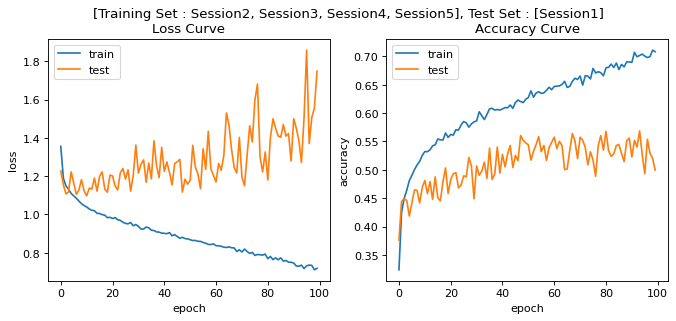

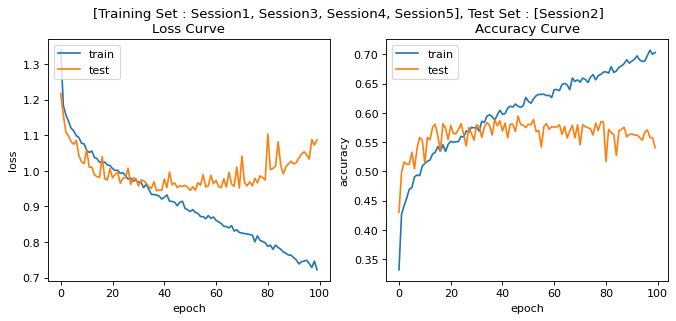

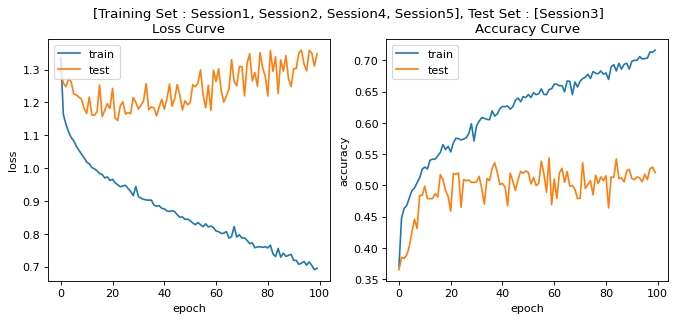

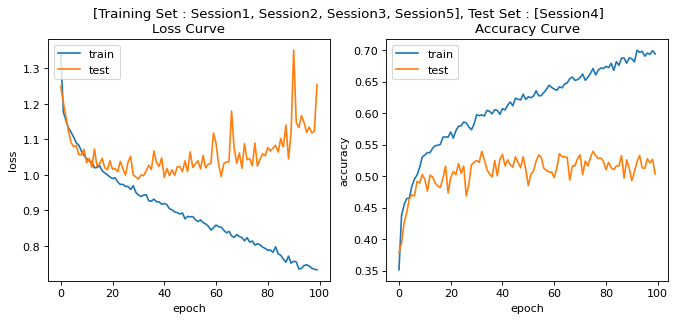

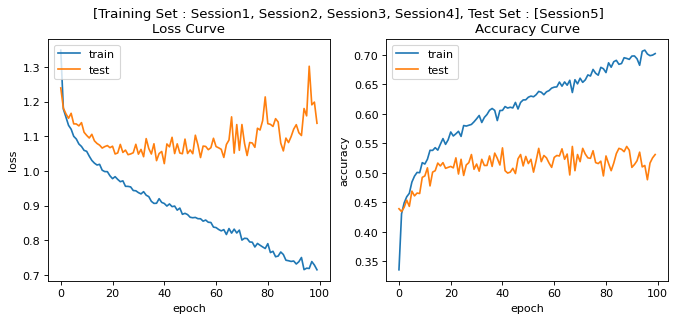

In [99]:
getLAACurves([historyOSF40, historyOSF41, historyOSF42, historyOSF43, historyOSF44]) 

In [100]:
print("Training and testing on Chunk : 1-------------------------")
modelOSRefinedF40, historyOSRefinedF40 = fourthModelTweaked(0, 32, 11, trainOSF, testOSF, 88)    

print("Training and testing on Chunk : 2-------------------------")
modelOSRefinedF41, historyOSRefinedF41 = fourthModelTweaked(1, 32, 38, trainOSF, testOSF, 88)    

print("Training and testing on Chunk : 3-------------------------")
modelOSRefinedF42, historyOSRefinedF42 = fourthModelTweaked(2, 32, 23, trainOSF, testOSF, 88)    

print("Training and testing on Chunk : 4-------------------------")
modelOSRefinedF43, historyOSRefinedF43 = fourthModelTweaked(3, 32, 31, trainOSF, testOSF, 88)     

print("Training and testing on Chunk : 5-------------------------")
modelOSRefinedF44, historyOSRefinedF44 = fourthModelTweaked(4, 32, 41, trainOSF, testOSF, 88)     

Training and testing on Chunk : 1-------------------------
Epoch 1/11
139/139 [==============================] - 14s 83ms/step - loss: 1.3727 - accuracy: 0.2975 - val_loss: 1.2274 - val_accuracy: 0.3760
Epoch 2/11
139/139 [==============================] - 9s 63ms/step - loss: 1.2069 - accuracy: 0.4087 - val_loss: 1.1555 - val_accuracy: 0.4442
Epoch 3/11
139/139 [==============================] - 9s 63ms/step - loss: 1.1587 - accuracy: 0.4534 - val_loss: 1.1072 - val_accuracy: 0.4488
Epoch 4/11
139/139 [==============================] - 9s 65ms/step - loss: 1.1369 - accuracy: 0.4675 - val_loss: 1.1175 - val_accuracy: 0.4461
Epoch 5/11
139/139 [==============================] - 9s 64ms/step - loss: 1.1206 - accuracy: 0.4728 - val_loss: 1.2222 - val_accuracy: 0.4184
Epoch 6/11
139/139 [==============================] - 9s 64ms/step - loss: 1.1038 - accuracy: 0.4932 - val_loss: 1.1648 - val_accuracy: 0.4415
Epoch 7/11
139/139 [==============================] - 9s 66ms/step - loss: 1.0999 

Epoch 8/23
137/137 [==============================] - 9s 64ms/step - loss: 1.0654 - accuracy: 0.4899 - val_loss: 1.2161 - val_accuracy: 0.4309
Epoch 9/23
137/137 [==============================] - 9s 65ms/step - loss: 1.0546 - accuracy: 0.5043 - val_loss: 1.2101 - val_accuracy: 0.4839
Epoch 10/23
137/137 [==============================] - 9s 69ms/step - loss: 1.0259 - accuracy: 0.5263 - val_loss: 1.1826 - val_accuracy: 0.4839
Epoch 11/23
137/137 [==============================] - 9s 69ms/step - loss: 1.0317 - accuracy: 0.5244 - val_loss: 1.1663 - val_accuracy: 0.4987
Epoch 12/23
137/137 [==============================] - 9s 68ms/step - loss: 1.0210 - accuracy: 0.5220 - val_loss: 1.2164 - val_accuracy: 0.4787
Epoch 13/23
137/137 [==============================] - 9s 65ms/step - loss: 1.0113 - accuracy: 0.5372 - val_loss: 1.1619 - val_accuracy: 0.4787
Epoch 14/23
137/137 [==============================] - 9s 65ms/step - loss: 0.9933 - accuracy: 0.5378 - val_loss: 1.1609 - val_accuracy: 0

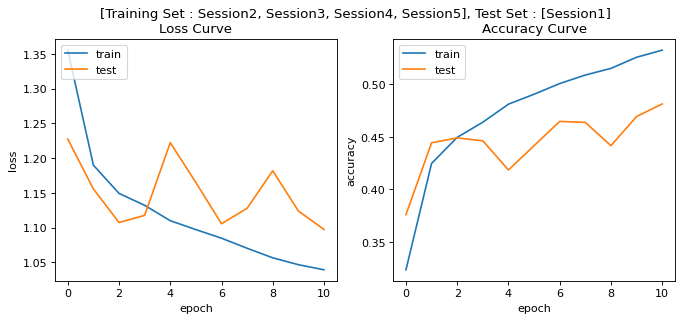

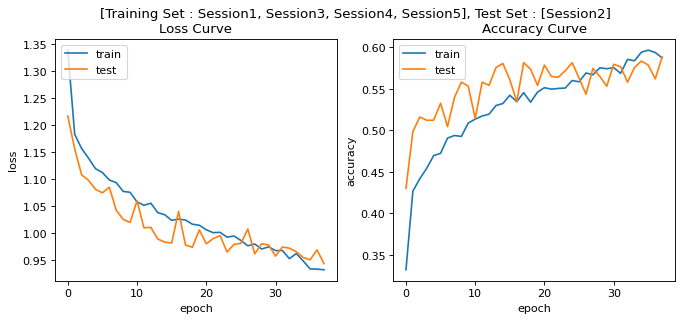

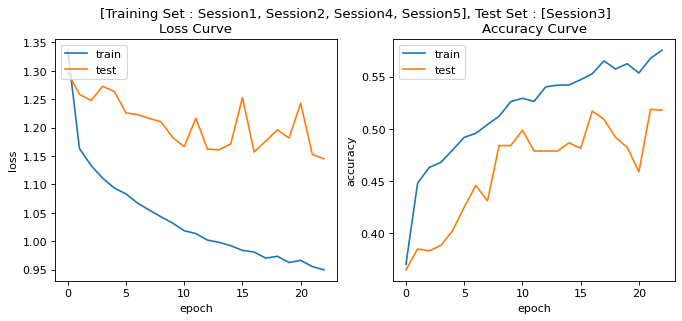

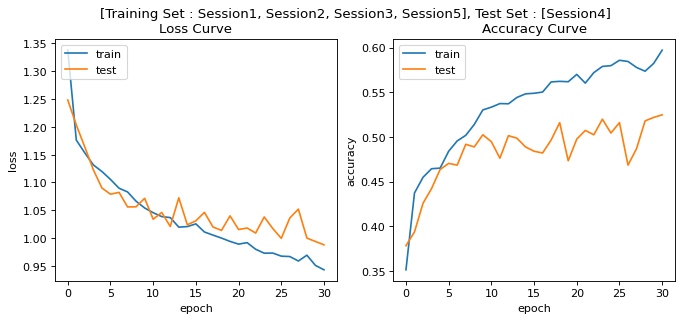

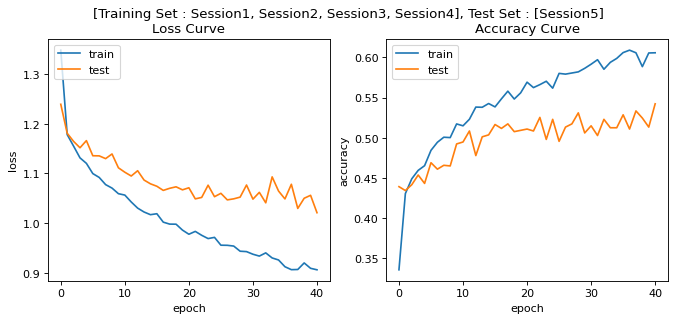

In [103]:
getLAACurves([historyOSRefinedF40, historyOSRefinedF41, historyOSRefinedF42, historyOSRefinedF43, historyOSRefinedF44]) 

In [102]:
getScores(testOSF, [modelOSRefinedF40, modelOSRefinedF41, modelOSRefinedF42, modelOSRefinedF43, modelOSRefinedF44])

1. [Training Set : Session2, Session3, Session4, Session5], Test Set : [Session1]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.5896980461811723
Happy    |   0.32122370936902483
Sad      |   0.5467625899280576
Neutral  |   0.4737631184407796


-------------------------------
Macro F1 Score :  0.4828618659797586


-------------------------------
Accuracy Score :  0.48110599078341015

-------------------------------------------------------------------------------------------------

2. [Training Set : Session1, Session3, Session4, Session5], Test Set : [Session2]

Metric Scores of the model using above scenario:
Class    |   Average F1 Score
-------------------------------
Angry    |   0.5174129353233831
Happy    |   0.517799352750809
Sad      |   0.6577540106951872
Neutral  |   0.6260257913247362


-------------------------------
Macro F1 Score :  0.5797480225235289


-------------------------------
Accuracy